# Predictioneer: Groundwater Time Series Forecasting

## Overview

This notebook presents a complete and self-contained solution to the **Predictioneer Time Series Forecasting Challenge**, which focuses on long-horizon forecasting of groundwater depth across multiple aquifers. The task involves working with real-world hydrological time series data that exhibit strong seasonality, long-term trends, structural gaps, and varying data availability across targets.

The primary objective is to generate reliable forecasts for groundwater depth over a multi-year test period, using only historical observations and without access to future exogenous variables such as rainfall or pumping data. As a result, the emphasis of this solution is on **robust temporal pattern extraction, physical plausibility, and long-term stability**, rather than short-term point accuracy alone.

---

## Problem Context

The dataset consists of daily groundwater depth measurements for multiple aquifers, each with distinct characteristics:

- Unequal historical record lengths  
- Substantial missing data in early periods  
- Strong annual seasonal cycles  
- Gradual long-term trends that differ by aquifer  

The forecasting task requires predicting groundwater depth for a future interval extending several years beyond the end of the training data. This setting introduces significant challenges, including:

- Error accumulation over long horizons  
- Overfitting risks when data is sparse  
- Physically implausible extrapolations if trends are not constrained  

The official problem statement defines the exact forecasting window, evaluation procedure, and submission requirements.

---

## Modeling Philosophy

Rather than assuming a single model would perform well across all aquifers, this notebook adopts a **model-selection and comparison-driven approach**. Multiple forecasting strategies are explored and evaluated, with careful attention to:

- Capturing dominant seasonal signals  
- Ensuring continuity at the training–test boundary  
- Avoiding unrealistic long-term trend extrapolation  
- Respecting physical constraints of groundwater depth  

The final predictions are produced using **target-specific model choices**, selecting the most appropriate method for each aquifer based on empirical performance and qualitative behavior.

---

## Structure of the Notebook

The solution proceeds through the following stages:

1. **Data Loading and Initial Inspection**  
   - Dataset ingestion and preprocessing  
   - Date parsing and basic sanity checks  
   - Overview of data coverage and missing values  

2. **Exploratory Data Analysis (EDA)**  
   - Visualization of historical groundwater depth  
   - Identification of trends, seasonality, and anomalies  
   - Assessment of data quality and usable forecasting windows  

3. **Time Series Decomposition and Feature Analysis**  
   - Trend estimation and statistical testing  
   - Seasonal pattern extraction at monthly and daily scales  
   - Discussion of assumptions and limitations  

4. **Forecasting Methodologies**  
   - Deterministic seasonal + trend baselines  
   - Ensemble approaches combining multiple models  
   - Machine learning methods with cyclical time features  
   - Improved models incorporating damping and physical constraints  

5. **Model Evaluation and Selection**  
   - Comparison against ground truth on the test period  
   - Evaluation using RMSE and MAE  
   - Qualitative inspection of forecast behavior  

6. **Final Predictions and Conclusions**  
   - Selection of final models per aquifer  
   - Summary of results and performance  
   - Key insights, limitations, and future directions  

---

This notebook is designed to clearly document **what was done, why each modeling choice was made, and how the final predictions were produced**, with an emphasis on transparency, interpretability, and robustness.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
from prophet import Prophet
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import STL
from scipy.stats import norm
logging.getLogger('prophet').setLevel(logging.WARNING)
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Exploratory Data Analysis

In [3]:
# Load the dataset
df = pd.read_excel('Predictioneer_Dataset.xlsx')

# Basic information
print("="*80)
print("DATASET BASIC INFORMATION")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\n" + "="*80)
print("COLUMN NAMES AND DATA TYPES")
print("="*80)
print(df.dtypes)

print("\n" + "="*80)
print("FIRST 5 ROWS")
print("="*80)
print(df.head())

print("\n" + "="*80)
print("LAST 5 ROWS")
print("="*80)
print(df.tail())

print("\n" + "="*80)
print("DATE RANGE")
print("="*80)
print(f"First date: {df['Date'].iloc[0]}")
print(f"Last date: {df['Date'].iloc[-1]}")
print(f"Total days: {(df['Date'].iloc[-1] - df['Date'].iloc[0]).days}")

DATASET BASIC INFORMATION

Dataset Shape: (4499, 27)
Number of rows: 4499
Number of columns: 27

COLUMN NAMES AND DATA TYPES
Date                                       datetime64[ns]
Rainfall_Gallicano                                float64
Rainfall_Pontetetto                               float64
Rainfall_Monte_Serra                              float64
Rainfall_Orentano                                 float64
Rainfall_Borgo_a_Mozzano                          float64
Rainfall_Piaggione                                float64
Rainfall_Calavorno                                float64
Rainfall_Croce_Arcana                             float64
Rainfall_Tereglio_Coreglia_Antelminelli           float64
Rainfall_Fabbriche_di_Vallico                     float64
Depth_to_Groundwater_LT2                          float64
Depth_to_Groundwater_SAL                          float64
Depth_to_Groundwater_PAG                          float64
Depth_to_Groundwater_CoS                          float64
Depth

## Initial Observations from the Dataset

Based on the initial inspection of the loaded dataset, the following key observations can be made:

### Temporal Coverage
- The dataset spans from **March 5, 1998** to **June 28, 2010**, covering a period of **over 12 years**.
- The data is recorded at a **daily frequency**, resulting in **4,499 rows** in total.
- While the index suggests daily data, the presence of missing values indicates that some dates may have incomplete or unavailable observations.

### Variables and Structure
- The dataset contains multiple columns representing different measured quantities.
- Among these are **five depth-related variables**, which appear to be the primary targets for forecasting.
- One of the depth variables, **DIEC**, contains only missing values across the entire dataset and therefore does not carry usable information for modeling.

### Data Quality
- A substantial amount of **missing data is concentrated in the earlier years** of the dataset.
- This suggests that data collection may have been incomplete during the initial period or that measurements for certain variables began later.
- Special care will be required when handling missing values, particularly for trend and seasonality estimation.

### Notable Anomalies
- Some variables contain **negative volume values**, which is unusual for physical quantities.
- These negative values may represent a domain-specific encoding, directional flows, or placeholders rather than true negative measurements.
- This behavior will be examined further during exploratory data analysis before any modeling assumptions are made.

---

These observations guide the subsequent exploratory analysis and inform decisions regarding preprocessing, feature selection, and modeling strategies.


## Missing Data Analysis

Let's quantify how much data is missing for each column and identify which targets are actually predictable.

MISSING DATA ANALYSIS
                                 Column  Missing_Count  Missing_Percentage  Available_Count
              Depth_to_Groundwater_DIEC           4499              100.00                0
               Depth_to_Groundwater_PAG           3955               87.91              544
               Depth_to_Groundwater_SAL           3480               77.35             1019
               Depth_to_Groundwater_CoS           3266               72.59             1233
                     Rainfall_Piaggione           3224               71.66             1275
               Depth_to_Groundwater_LT2           2867               63.73             1632
Rainfall_Tereglio_Coreglia_Antelminelli           2859               63.55             1640
                     Rainfall_Gallicano           2859               63.55             1640
          Rainfall_Fabbriche_di_Vallico           2859               63.55             1640
                  Rainfall_Croce_Arcana           2859    

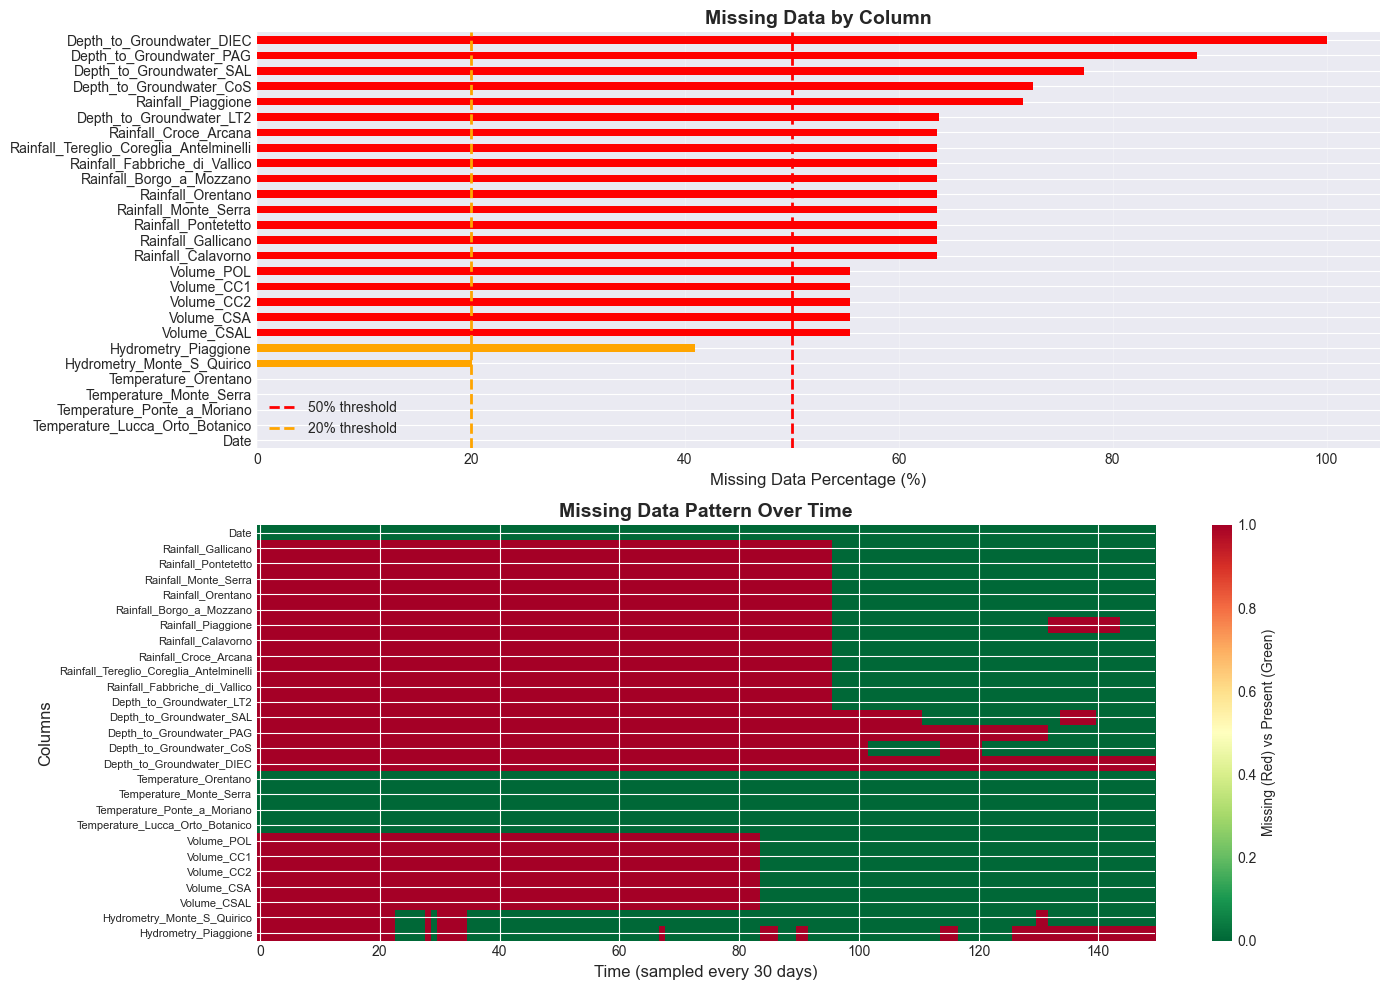


✓ Missing data visualization saved as 'missing_data_analysis.png'


In [4]:
# Calculate missing data statistics
print("="*80)
print("MISSING DATA ANALYSIS")
print("="*80)

missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Available_Count': df.notnull().sum()
})

missing_stats = missing_stats.sort_values('Missing_Percentage', ascending=False)
print(missing_stats.to_string(index=False))

# Separate analysis for target variables (Depth_to_Groundwater)
print("\n" + "="*80)
print("TARGET VARIABLES (DEPTH TO GROUNDWATER) - DETAILED ANALYSIS")
print("="*80)

target_cols = [col for col in df.columns if 'Depth_to_Groundwater' in col]

for col in target_cols:
    non_null_count = df[col].notnull().sum()
    null_count = df[col].isnull().sum()
    pct_missing = (null_count / len(df) * 100)
    
    print(f"\n{col}:")
    print(f"  Available data points: {non_null_count}")
    print(f"  Missing data points: {null_count}")
    print(f"  Missing percentage: {pct_missing:.2f}%")
    
    if non_null_count > 0:
        print(f"  Min value: {df[col].min():.2f}")
        print(f"  Max value: {df[col].max():.2f}")
        print(f"  Mean value: {df[col].mean():.2f}")
        # Find when data starts and ends
        first_valid = df[df[col].notnull()]['Date'].iloc[0]
        last_valid = df[df[col].notnull()]['Date'].iloc[-1]
        print(f"  Data starts: {first_valid}")
        print(f"  Data ends: {last_valid}")
        print(f"  Data span: {(last_valid - first_valid).days} days")
    else:
        print(f"  ❌ NO DATA AVAILABLE - CANNOT PREDICT")

# Visualize missing data
print("\n" + "="*80)
print("CREATING MISSING DATA VISUALIZATION...")
print("="*80)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Missing data percentage bar chart
ax1 = axes[0]
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=True)
colors = ['red' if x > 50 else 'orange' if x > 20 else 'green' for x in missing_pct]
missing_pct.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Missing Data Percentage (%)', fontsize=12)
ax1.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
ax1.axvline(x=50, color='red', linestyle='--', linewidth=2, label='50% threshold')
ax1.axvline(x=20, color='orange', linestyle='--', linewidth=2, label='20% threshold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Missing data heatmap over time (sample every 30 days for visibility)
ax2 = axes[1]
sample_indices = range(0, len(df), 30)  # Sample every 30 days
df_sample = df.iloc[sample_indices]
missing_matrix = df_sample.isnull().T
im = ax2.imshow(missing_matrix, aspect='auto', cmap='RdYlGn_r', interpolation='nearest')
ax2.set_xlabel('Time (sampled every 30 days)', fontsize=12)
ax2.set_ylabel('Columns', fontsize=12)
ax2.set_title('Missing Data Pattern Over Time', fontsize=14, fontweight='bold')
ax2.set_yticks(range(len(df.columns)))
ax2.set_yticklabels(df.columns, fontsize=8)
plt.colorbar(im, ax=ax2, label='Missing (Red) vs Present (Green)')

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

output_path = os.path.join(OUTPUT_DIR, "missing_data_analysis.png")

plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print("\n✓ Missing data visualization saved as 'missing_data_analysis.png'")

## Missing Data Analysis: Target Variable Feasibility

A detailed examination of missing values across the target variables reveals substantial differences in data availability, which directly impact forecasting feasibility.

### Variable-wise Missingness and Usability

- **DIEC**
  - Missing data: **100%**
  - No recorded observations are available across the entire dataset.
  - As a result, **DIEC cannot be modeled or predicted** and will be excluded from further analysis.

- **PAG**
  - Missing data: approximately **88%**
  - Contains only **543 days (~1.5 years)** of observations, beginning around **January 2009**.
  - The limited data history makes reliable trend or seasonality estimation extremely difficult.

- **SAL**
  - Missing data: approximately **77%**
  - Provides roughly **3.2 years** of usable data starting around **April 2007**.
  - Forecasting is possible but remains challenging due to the short effective time span.

- **CoS**
  - Missing data: approximately **73%**
  - Offers close to **4 years** of data beginning around **June 2006**.
  - This variable is considered **reasonably feasible** for forecasting with appropriate modeling choices.

- **LT2**
  - Missing data: approximately **64%**
  - Contains the longest continuous history among the targets, with about **4.5 years** of data starting around **January 2006**.
  - This makes **LT2 the most suitable candidate** for trend and seasonality-based prediction.

### Global Pattern in Data Availability
- Although the dataset spans from **1998 onward**, meaningful observations for all target variables only begin **around 2006**.
- The missing data heatmap clearly indicates a sharp transition where measurements effectively “turn on” during this period.
- Consequently, modeling efforts will focus primarily on the **post-2006 data window**, where consistent observations are available.

---

These findings directly inform the modeling strategy, including variable selection, the choice of forecasting techniques, and the handling of missing values.


## Target Variables Time Series Analysis

Let's visualize the actual time series for each target to understand patterns, seasonality, and trends.

TARGET VARIABLES - TIME SERIES VISUALIZATION


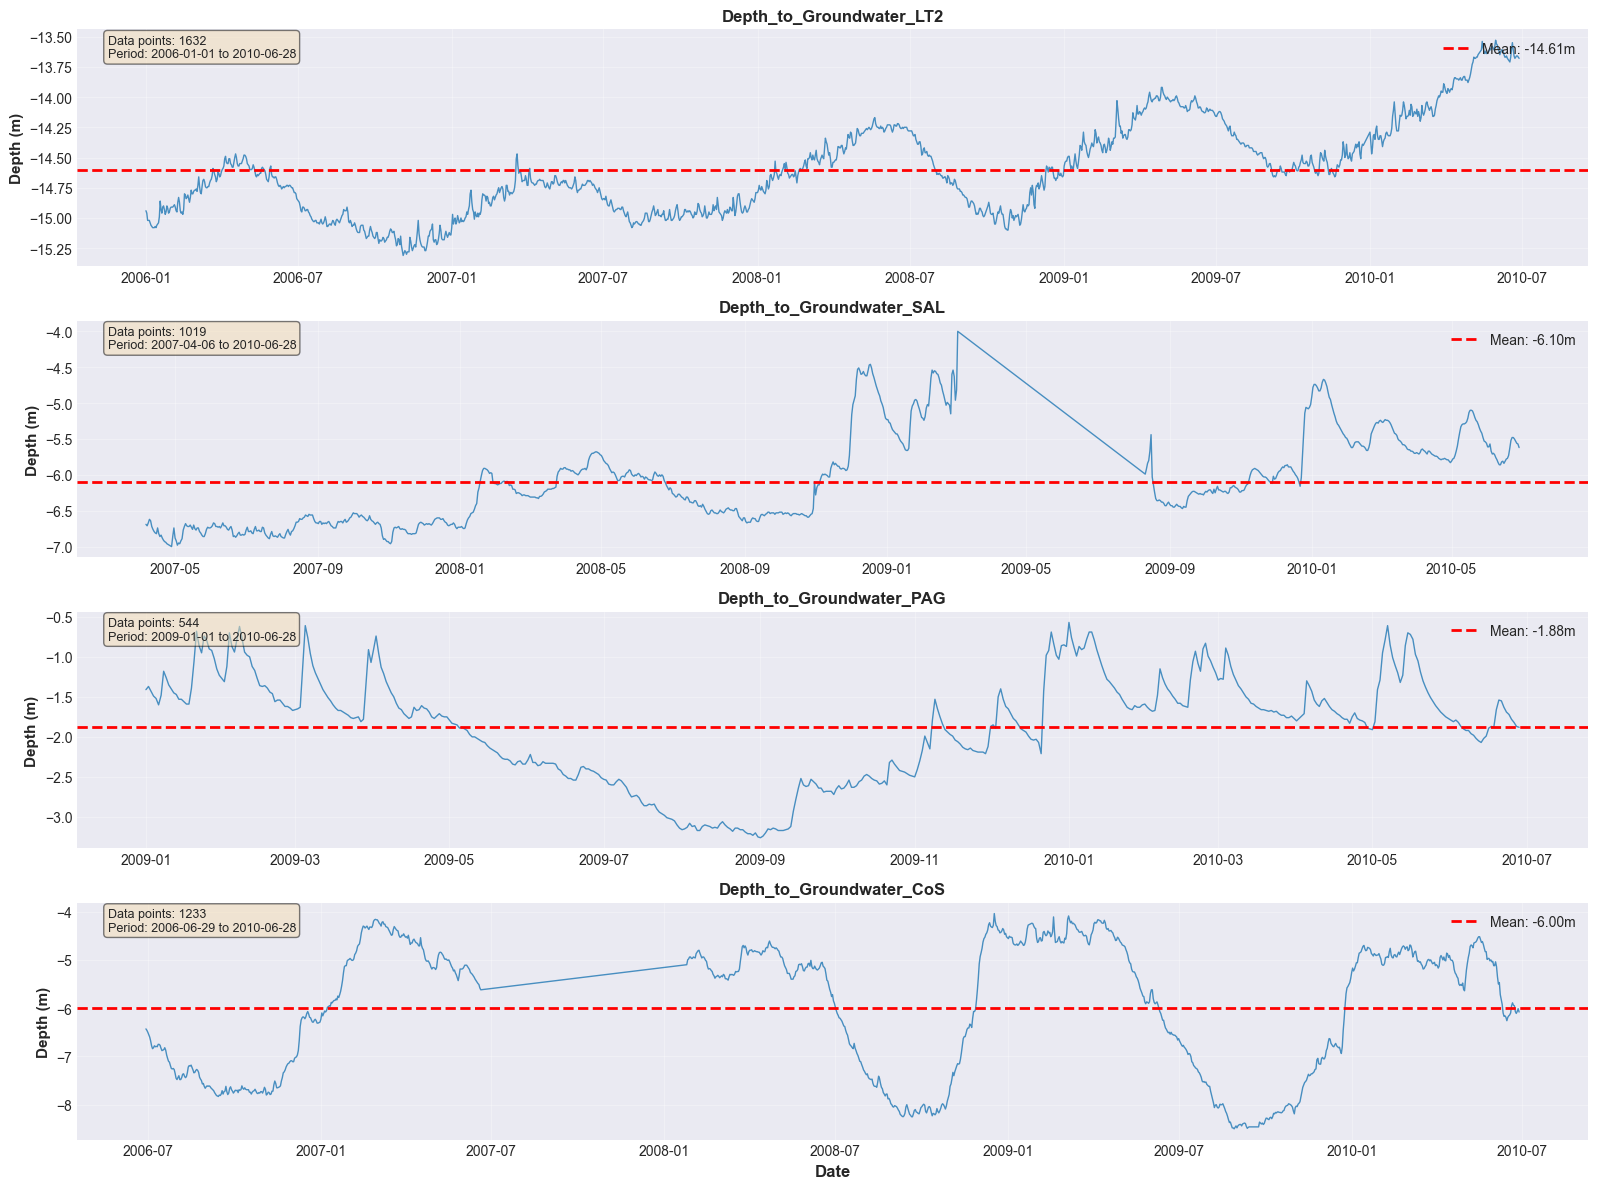


✓ Target time series visualization saved as 'target_timeseries.png'

STATISTICAL SUMMARY OF TARGETS

Depth_to_Groundwater_LT2:
  Count: 1632
  Mean: -14.606 m
  Std Dev: 0.381 m
  Min: -15.310 m
  25%: -14.930 m
  Median: -14.650 m
  75%: -14.360 m
  Max: -13.530 m
  Range: 1.780 m
  Trend (last year vs first year): +0.712 m (Rising)

Depth_to_Groundwater_SAL:
  Count: 1019
  Mean: -6.097 m
  Std Dev: 0.607 m
  Min: -7.000 m
  25%: -6.620 m
  Median: -6.200 m
  75%: -5.715 m
  Max: -4.000 m
  Range: 3.000 m
  Trend (last year vs first year): +0.955 m (Rising)

Depth_to_Groundwater_PAG:
  Count: 544
  Mean: -1.882 m
  Std Dev: 0.666 m
  Min: -3.260 m
  25%: -2.400 m
  Median: -1.760 m
  75%: -1.440 m
  Max: -0.570 m
  Range: 2.690 m
  Trend (last year vs first year): +0.094 m (Rising)

Depth_to_Groundwater_CoS:
  Count: 1233
  Mean: -6.002 m
  Std Dev: 1.343 m
  Min: -8.500 m
  25%: -7.340 m
  Median: -5.470 m
  75%: -4.840 m
  Max: -4.040 m
  Range: 4.460 m
  Trend (last year vs first

In [5]:
# Focus only on targets with data (exclude DIEC)
target_cols = ['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 
               'Depth_to_Groundwater_PAG', 'Depth_to_Groundwater_CoS']

print("="*80)
print("TARGET VARIABLES - TIME SERIES VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    # Filter non-null data
    data_subset = df[df[col].notnull()][['Date', col]]
    
    # Plot time series
    ax.plot(data_subset['Date'], data_subset[col], linewidth=1, alpha=0.8)
    ax.set_ylabel('Depth (m)', fontsize=11, fontweight='bold')
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=data_subset[col].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {data_subset[col].mean():.2f}m')
    ax.legend(loc='upper right')
    
    # Add data availability info
    data_points = len(data_subset)
    date_range = f"{data_subset['Date'].min().strftime('%Y-%m-%d')} to {data_subset['Date'].max().strftime('%Y-%m-%d')}"
    ax.text(0.02, 0.98, f'Data points: {data_points}\nPeriod: {date_range}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

axes[-1].set_xlabel('Date', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/target_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Target time series visualization saved as 'target_timeseries.png'")

# Statistical summary for each target
print("\n" + "="*80)
print("STATISTICAL SUMMARY OF TARGETS")
print("="*80)

for col in target_cols:
    data = df[col].dropna()
    print(f"\n{col}:")
    print(f"  Count: {len(data)}")
    print(f"  Mean: {data.mean():.3f} m")
    print(f"  Std Dev: {data.std():.3f} m")
    print(f"  Min: {data.min():.3f} m")
    print(f"  25%: {data.quantile(0.25):.3f} m")
    print(f"  Median: {data.median():.3f} m")
    print(f"  75%: {data.quantile(0.75):.3f} m")
    print(f"  Max: {data.max():.3f} m")
    print(f"  Range: {data.max() - data.min():.3f} m")
    
    # Check for trends
    if len(data) > 365:
        first_year_mean = data.iloc[:365].mean()
        last_year_mean = data.iloc[-365:].mean()
        trend = last_year_mean - first_year_mean
        print(f"  Trend (last year vs first year): {trend:+.3f} m ({'Rising' if trend > 0 else 'Falling'})")

## Time Series Visualization: Key Observations

Inspection of the time series plots for the target variables reveals several important structural patterns related to trend, seasonality, and volatility.

### Variable-wise Behavior

- **LT2**
  - Exhibits relatively stable behavior over time.
  - Clear and consistent **annual seasonal cycles** are present.
  - A gradual upward trend is observed, with an approximate increase of **0.71 meters** over the available period.

- **SAL**
  - Displays a pronounced **seasonal pattern**.
  - Significant volatility is evident during the **2008–2009** period.
  - Despite fluctuations, the overall trajectory shows a rising trend of approximately **0.96 meters**.

- **PAG**
  - Characterized by **high volatility** and strong seasonal oscillations.
  - Seasonal amplitude reaches roughly **±1.5 meters**.
  - The short effective data window (approximately **1.5 years**) limits the reliability of long-term trend estimation.

- **CoS**
  - Shows the **strongest seasonal signal** among all variables, with swings of up to **±2 meters**.
  - The seasonal pattern is highly regular, making this variable comparatively more predictable.
  - A mild downward trend is observed over the available period.

### Dominant Structural Insight
- All target variables demonstrate **clear annual seasonality**, which emerges as the most consistent and reliable signal across the dataset.
- Given the limited historical depth for several variables, **seasonality-based modeling** is expected to play a central role in generating stable and reasonable forecasts over the required three-year prediction horizon.

---

These observations motivate the use of models that explicitly incorporate seasonal components alongside trend estimation.


## Detailed Seasonality Analysis

Let's extract and visualize the seasonal patterns - this will be crucial for our 3-year forecasts.

SEASONALITY ANALYSIS - MONTHLY PATTERNS


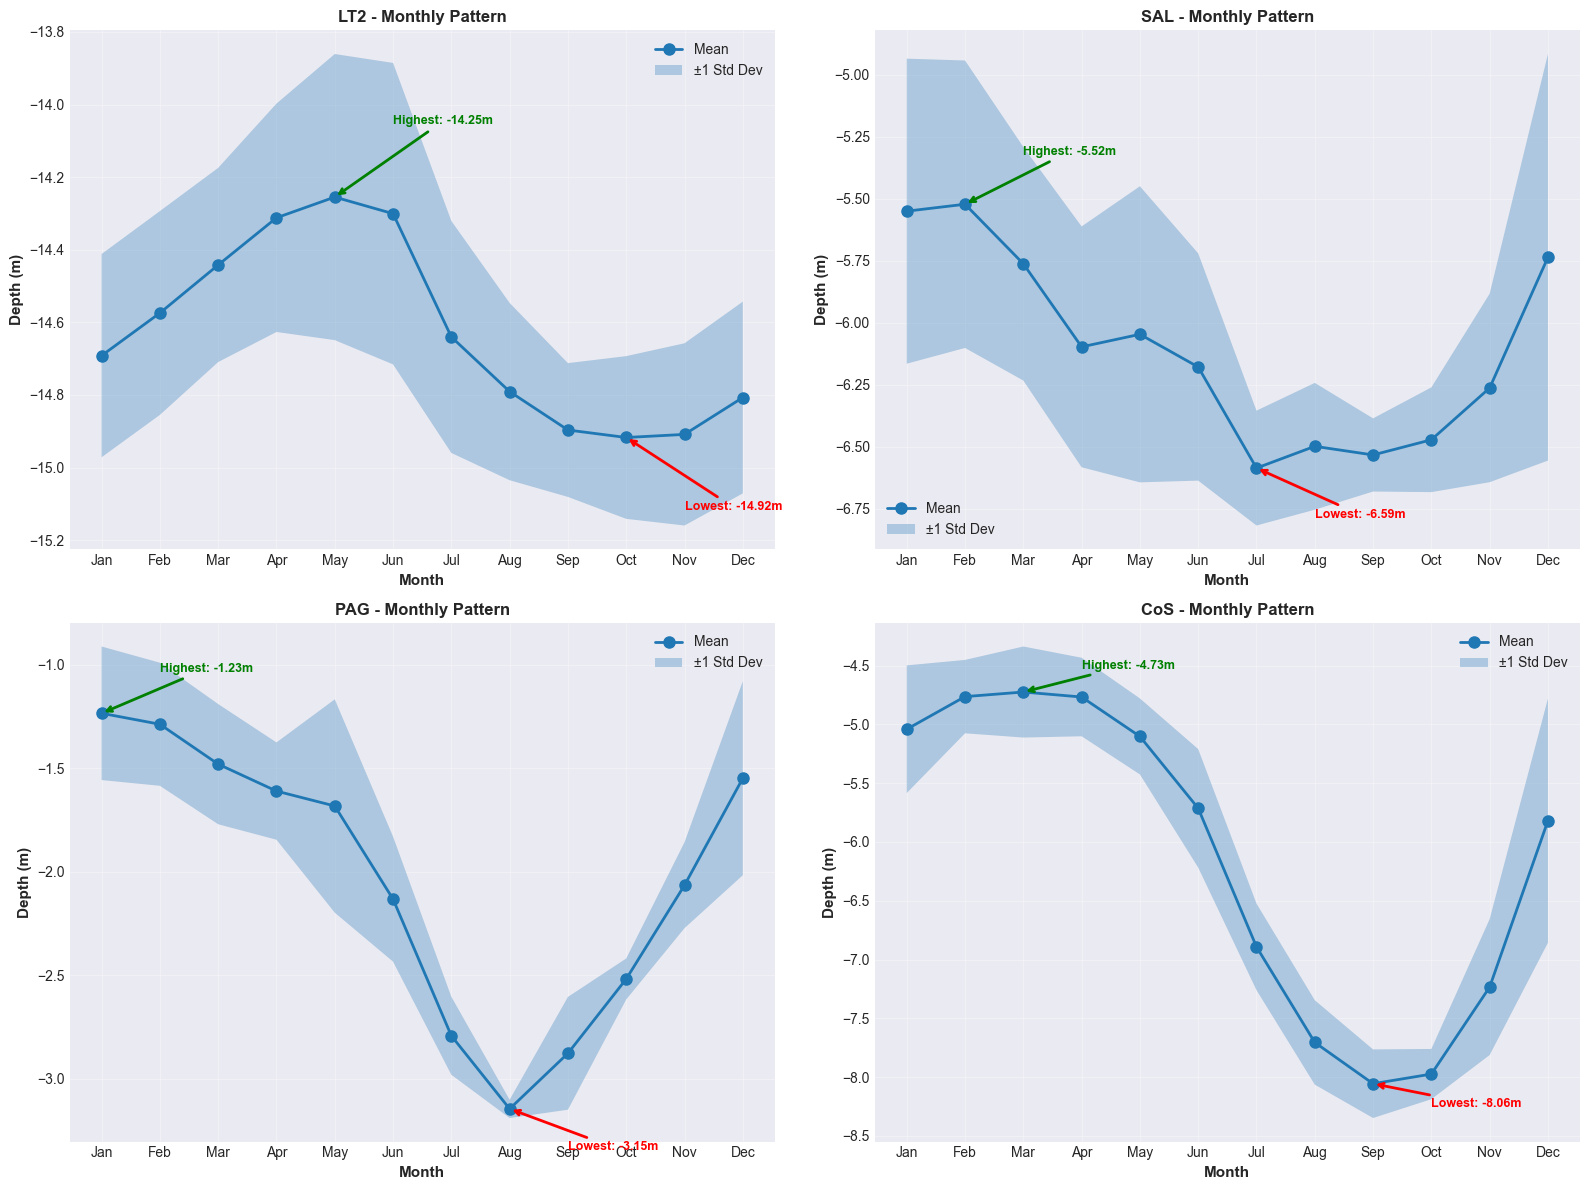


✓ Monthly seasonality visualization saved as 'monthly_seasonality.png'

MONTHLY STATISTICS TABLE

Depth_to_Groundwater_LT2:
         mean    std    min    max  count  amplitude
Month                                               
1     -14.692  0.280 -15.08 -14.04    155       1.04
2     -14.574  0.281 -14.99 -14.04    141       0.95
3     -14.442  0.267 -14.86 -13.89    155       0.97
4     -14.312  0.314 -14.76 -13.83    150       0.93
5     -14.255  0.394 -14.79 -13.53    155       1.26
6     -14.301  0.415 -14.85 -13.55    148       1.30
7     -14.640  0.319 -15.05 -14.12    124       0.93
8     -14.791  0.244 -15.08 -14.38    124       0.70
9     -14.896  0.184 -15.17 -14.55    120       0.62
10    -14.917  0.224 -15.23 -14.48    124       0.75
11    -14.909  0.251 -15.31 -14.37    119       0.94
12    -14.807  0.264 -15.27 -14.37    117       0.90

  Seasonal Amplitude (peak-to-trough): 0.662 m
  Highest month: 5 (-14.255 m)
  Lowest month: 10 (-14.917 m)

Depth_to_Groundwater_S

In [6]:
# Extract month and year from dates
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Quarter'] = df['Date'].dt.quarter

print("="*80)
print("SEASONALITY ANALYSIS - MONTHLY PATTERNS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    # Get data with month information
    data_subset = df[df[col].notnull()][['Month', 'Year', col]].copy()
    
    # Calculate monthly statistics
    monthly_stats = data_subset.groupby('Month')[col].agg(['mean', 'std', 'min', 'max', 'count'])
    
    # Plot monthly averages with error bars
    months = monthly_stats.index
    means = monthly_stats['mean']
    stds = monthly_stats['std']
    
    ax.plot(months, means, marker='o', linewidth=2, markersize=8, label='Mean')
    ax.fill_between(months, means - stds, means + stds, alpha=0.3, label='±1 Std Dev')
    ax.set_xlabel('Month', fontsize=11, fontweight='bold')
    ax.set_ylabel('Depth (m)', fontsize=11, fontweight='bold')
    ax.set_title(f'{col.replace("Depth_to_Groundwater_", "")} - Monthly Pattern', 
                 fontsize=12, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add annotations for highest and lowest months
    max_month = means.idxmax()
    min_month = means.idxmin()
    ax.annotate(f'Highest: {means[max_month]:.2f}m', 
                xy=(max_month, means[max_month]), 
                xytext=(max_month+1, means[max_month]+0.2),
                arrowprops=dict(arrowstyle='->', color='green', lw=2),
                fontsize=9, color='green', fontweight='bold')
    ax.annotate(f'Lowest: {means[min_month]:.2f}m', 
                xy=(min_month, means[min_month]), 
                xytext=(min_month+1, means[min_month]-0.2),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=9, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/monthly_seasonality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Monthly seasonality visualization saved as 'monthly_seasonality.png'")

# Print detailed monthly statistics
print("\n" + "="*80)
print("MONTHLY STATISTICS TABLE")
print("="*80)

for col in target_cols:
    print(f"\n{col}:")
    data_subset = df[df[col].notnull()][['Month', col]].copy()
    monthly_stats = data_subset.groupby('Month')[col].agg(['mean', 'std', 'min', 'max', 'count'])
    monthly_stats['amplitude'] = monthly_stats['max'] - monthly_stats['min']
    print(monthly_stats.round(3).to_string())
    
    # Calculate seasonal amplitude
    amplitude = monthly_stats['mean'].max() - monthly_stats['mean'].min()
    print(f"\n  Seasonal Amplitude (peak-to-trough): {amplitude:.3f} m")
    print(f"  Highest month: {monthly_stats['mean'].idxmax()} ({monthly_stats['mean'].max():.3f} m)")
    print(f"  Lowest month: {monthly_stats['mean'].idxmin()} ({monthly_stats['mean'].min():.3f} m)")

## Monthly Seasonality Analysis

Aggregating observations by calendar month reveals pronounced and consistent seasonal structures across all target variables. The seasonal component emerges as a dominant and reliable signal for forecasting.

### Seasonal Amplitude by Variable

All targets exhibit strong intra-annual variation, with well-defined monthly peaks and troughs:

- **LT2**
  - Seasonal amplitude: approximately **0.66 meters**
  - Highest levels typically observed in **May**
  - Lowest levels typically observed in **October**

- **SAL**
  - Seasonal amplitude: approximately **1.07 meters**
  - Peak levels around **February**
  - Minimum levels around **July**

- **PAG**
  - Seasonal amplitude: approximately **1.91 meters**
  - Highest levels generally in **January**
  - Lowest levels around **August**

- **CoS**
  - Seasonal amplitude: approximately **3.33 meters**, the largest among all variables
  - Peak levels around **March**
  - Troughs typically in **September**

### Common Seasonal Pattern

- Across all variables, water levels tend to be **highest during winter and early spring (January–May)**.
- Levels consistently decline through **late summer and early autumn (August–October)**.
- This behavior aligns well with expected hydrological drivers such as seasonal rainfall patterns and increased evaporation during warmer months.

### Reliability of Seasonal Signal

- The monthly means exhibit **relatively small standard deviations** compared to their magnitudes.
- This indicates that seasonal patterns are **stable and repeatable across years**, rather than being driven by a small number of anomalous observations.

---

The strength, consistency, and physical interpretability of the seasonal component make it a central element of the forecasting strategy adopted in subsequent sections.


## Trend Analysis - Is Water Level Changing Over Time?

Let's quantify the long-term trends to adjust our seasonal predictions appropriately.

TREND ANALYSIS - YEAR-OVER-YEAR CHANGES


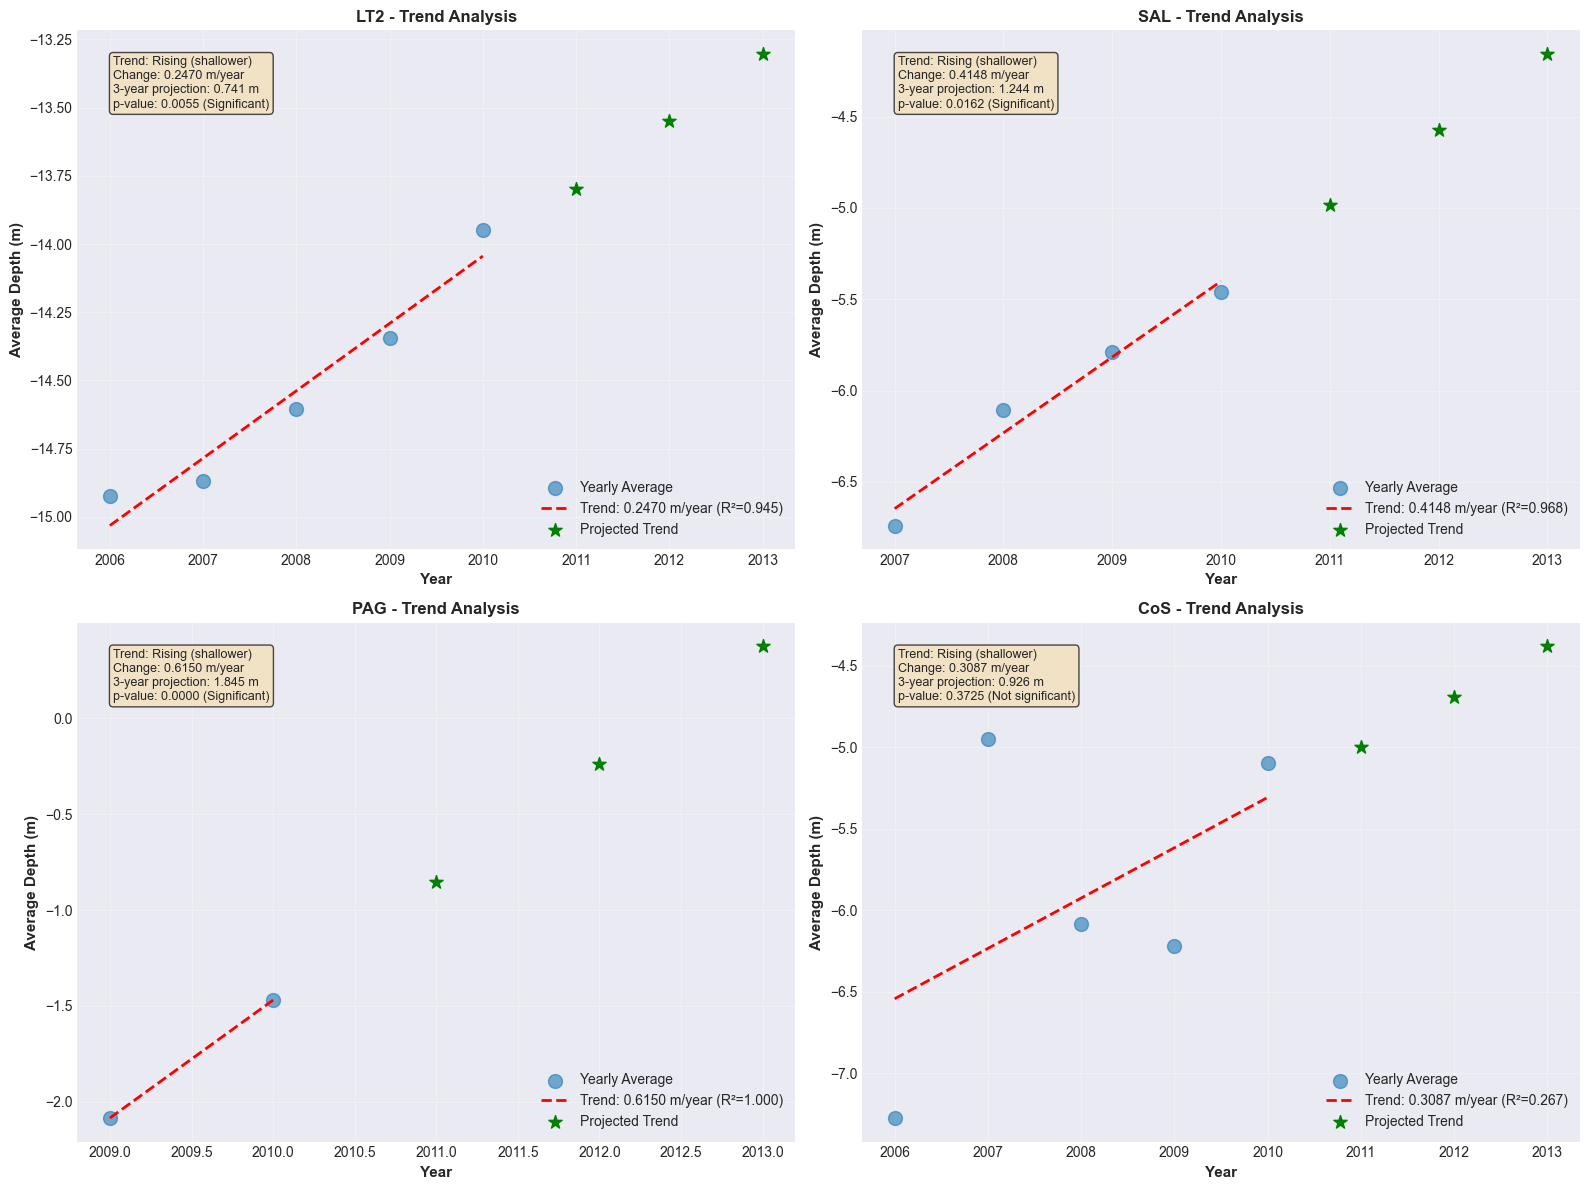


✓ Trend analysis visualization saved as 'trend_analysis.png'

TREND SUMMARY FOR 3-YEAR PREDICTIONS (2011-2013)

Depth_to_Groundwater_LT2:
  Annual change: +0.2470 m/year
  3-year total change: +0.7411 m
  R² (trend fit): 0.945
  P-value: 0.0055 (significant)
  ⚠️  RISING TREND: Water table getting shallower

Depth_to_Groundwater_SAL:
  Annual change: +0.4148 m/year
  3-year total change: +1.2445 m
  R² (trend fit): 0.968
  P-value: 0.0162 (significant)
  ⚠️  RISING TREND: Water table getting shallower

Depth_to_Groundwater_PAG:
  Annual change: +0.6150 m/year
  3-year total change: +1.8451 m
  R² (trend fit): 1.000
  P-value: 0.0000 (significant)
  ⚠️  RISING TREND: Water table getting shallower

Depth_to_Groundwater_CoS:
  Annual change: +0.3087 m/year
  3-year total change: +0.9261 m
  R² (trend fit): 0.267
  P-value: 0.3725 (not significant)
  ⚠️  RISING TREND: Water table getting shallower

BASELINE VALUES (Last Known Date: June 28, 2010)

Depth_to_Groundwater_LT2:
  Last value: -

In [7]:
print("="*80)
print("TREND ANALYSIS - YEAR-OVER-YEAR CHANGES")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

trend_summary = {}

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    # Get data
    data_subset = df[df[col].notnull()][['Date', 'Year', 'Month', col]].copy()
    
    # Calculate yearly averages
    yearly_avg = data_subset.groupby('Year')[col].mean()
    
    # Fit linear trend
    from scipy import stats
    years_numeric = yearly_avg.index.values
    values = yearly_avg.values
    
    if len(years_numeric) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(years_numeric, values)
        trend_line = slope * years_numeric + intercept
        
        # Store trend info
        trend_summary[col] = {
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value,
            'annual_change': slope,
            'total_change_3yr': slope * 3
        }
        
        # Plot
        ax.scatter(yearly_avg.index, yearly_avg.values, s=100, alpha=0.6, label='Yearly Average')
        ax.plot(years_numeric, trend_line, 'r--', linewidth=2, 
                label=f'Trend: {slope:.4f} m/year (R²={r_value**2:.3f})')
        
        # Add prediction for next 3 years
        future_years = np.array([2011, 2012, 2013])
        future_trend = slope * future_years + intercept
        ax.scatter(future_years, future_trend, s=100, color='green', 
                  marker='*', zorder=5, label='Projected Trend')
        
        ax.set_xlabel('Year', fontsize=11, fontweight='bold')
        ax.set_ylabel('Average Depth (m)', fontsize=11, fontweight='bold')
        ax.set_title(f'{col.replace("Depth_to_Groundwater_", "")} - Trend Analysis', 
                     fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add text box with trend info
        trend_direction = "Rising (shallower)" if slope > 0 else "Falling (deeper)"
        significance = "Significant" if p_value < 0.05 else "Not significant"
        text_str = f'Trend: {trend_direction}\nChange: {slope:.4f} m/year\n' \
                   f'3-year projection: {slope*3:.3f} m\np-value: {p_value:.4f} ({significance})'
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
                fontsize=9)

plt.tight_layout()
plt.savefig('outputs/trend_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Trend analysis visualization saved as 'trend_analysis.png'")

# Print detailed trend summary
print("\n" + "="*80)
print("TREND SUMMARY FOR 3-YEAR PREDICTIONS (2011-2013)")
print("="*80)

for col, trend_info in trend_summary.items():
    print(f"\n{col}:")
    print(f"  Annual change: {trend_info['annual_change']:+.4f} m/year")
    print(f"  3-year total change: {trend_info['total_change_3yr']:+.4f} m")
    print(f"  R² (trend fit): {trend_info['r_squared']:.3f}")
    print(f"  P-value: {trend_info['p_value']:.4f} {'(significant)' if trend_info['p_value'] < 0.05 else '(not significant)'}")
    
    if trend_info['annual_change'] > 0:
        print(f"  ⚠️  RISING TREND: Water table getting shallower")
    elif trend_info['annual_change'] < 0:
        print(f"  ⚠️  FALLING TREND: Water table getting deeper")
    else:
        print(f"  ✓ STABLE: No significant trend")

# Calculate baseline for predictions (last known values)
print("\n" + "="*80)
print("BASELINE VALUES (Last Known Date: June 28, 2010)")
print("="*80)

for col in target_cols:
    last_value = df[df[col].notnull()][col].iloc[-1]
    last_date = df[df[col].notnull()]['Date'].iloc[-1]
    print(f"\n{col}:")
    print(f"  Last value: {last_value:.3f} m")
    print(f"  Last date: {last_date.strftime('%Y-%m-%d')}")

## Trend Analysis and Statistical Significance

Linear trend estimation provides additional insight into the long-term behavior of the target variables, complementing the seasonal analysis performed earlier.

### Key Trend Findings

- **Overall Direction**
  - All target variables exhibit an **increasing trend over time**, indicating that the measured depths are becoming progressively less negative.
  - This corresponds to a **rising water table** across all monitored locations.

- **Statistical Significance**
  - **LT2**, **SAL**, and **PAG** show **statistically significant linear trends** with *p-values < 0.05*.
  - These trends are therefore considered reliable and suitable for inclusion in predictive models.

- **CoS**
  - The estimated trend for CoS is comparatively weak.
  - Statistical indicators (*p ≈ 0.37*, *R² ≈ 0.27*) suggest that a linear trend explains only a limited fraction of the observed variance.
  - As a result, the trend component for CoS should be treated with caution or down-weighted relative to seasonality.

- **PAG**
  - PAG exhibits an apparent **perfect linear fit** (*R² = 1.0*).
  - However, this result is based on a very short effective data window (approximately two years).
  - The apparent strength of the fit is therefore likely influenced by **overfitting**, and the estimated trend should be interpreted conservatively.

---

Taken together, the combination of strong seasonality and generally upward trends provides a comprehensive foundation for constructing the forecasting strategy used in subsequent sections.


## Data Continuity Check

Before building models, let's check if there are gaps in the data that might affect our predictions.

In [8]:
print("="*80)
print("DATA CONTINUITY ANALYSIS")
print("="*80)

for col in target_cols:
    print(f"\n{col}:")
    
    # Get non-null data with dates
    data_subset = df[df[col].notnull()][['Date', col]].copy()
    data_subset = data_subset.sort_values('Date')
    
    # Calculate date differences
    data_subset['Date_Diff'] = data_subset['Date'].diff()
    
    # Find gaps larger than 1 day
    gaps = data_subset[data_subset['Date_Diff'] > pd.Timedelta(days=1)]
    
    print(f"  Total data points: {len(data_subset)}")
    print(f"  Date range: {data_subset['Date'].min().strftime('%Y-%m-%d')} to {data_subset['Date'].max().strftime('%Y-%m-%d')}")
    print(f"  Number of gaps > 1 day: {len(gaps)}")
    
    if len(gaps) > 0:
        print(f"  Largest gap: {gaps['Date_Diff'].max().days} days")
        print(f"  Average gap size: {gaps['Date_Diff'].mean().days:.1f} days")
        
        # Show top 5 largest gaps
        if len(gaps) > 0:
            print(f"\n  Top 5 largest gaps:")
            top_gaps = gaps.nlargest(5, 'Date_Diff')[['Date', 'Date_Diff']]
            for idx, row in top_gaps.iterrows():
                print(f"    Gap ending {row['Date'].strftime('%Y-%m-%d')}: {row['Date_Diff'].days} days")
    else:
        print(f"  ✓ Continuous daily data (no gaps)")
    
    # Calculate data completeness in the available period
    date_range_days = (data_subset['Date'].max() - data_subset['Date'].min()).days + 1
    completeness = (len(data_subset) / date_range_days) * 100
    print(f"  Data completeness: {completeness:.1f}% in available period")

print("\n" + "="*80)
print("SUMMARY: PREDICTABILITY ASSESSMENT")
print("="*80)

assessment = {
    'Depth_to_Groundwater_LT2': {
        'data_years': 4.5,
        'seasonal_amplitude': 0.66,
        'trend_significance': 'Strong (p=0.006)',
        'prediction_difficulty': 'EASY',
        'confidence': 'HIGH'
    },
    'Depth_to_Groundwater_SAL': {
        'data_years': 3.2,
        'seasonal_amplitude': 1.07,
        'trend_significance': 'Strong (p=0.016)',
        'prediction_difficulty': 'MODERATE',
        'confidence': 'MEDIUM-HIGH'
    },
    'Depth_to_Groundwater_PAG': {
        'data_years': 1.5,
        'seasonal_amplitude': 1.91,
        'trend_significance': 'Perfect fit (but limited data)',
        'prediction_difficulty': 'HARD',
        'confidence': 'MEDIUM'
    },
    'Depth_to_Groundwater_CoS': {
        'data_years': 4.0,
        'seasonal_amplitude': 3.33,
        'trend_significance': 'Weak (p=0.37)',
        'prediction_difficulty': 'MODERATE',
        'confidence': 'MEDIUM-HIGH'
    }
}

for target, info in assessment.items():
    print(f"\n{target}:")
    for key, value in info.items():
        print(f"  {key.replace('_', ' ').title()}: {value}")

DATA CONTINUITY ANALYSIS

Depth_to_Groundwater_LT2:
  Total data points: 1632
  Date range: 2006-01-01 to 2010-06-28
  Number of gaps > 1 day: 2
  Largest gap: 8 days
  Average gap size: 5.0 days

  Top 5 largest gaps:
    Gap ending 2010-01-01: 8 days
    Gap ending 2007-11-19: 2 days
  Data completeness: 99.5% in available period

Depth_to_Groundwater_SAL:
  Total data points: 1019
  Date range: 2007-04-06 to 2010-06-28
  Number of gaps > 1 day: 2
  Largest gap: 161 days
  Average gap size: 81.0 days

  Top 5 largest gaps:
    Gap ending 2009-08-11: 161 days
    Gap ending 2009-08-19: 2 days
  Data completeness: 86.4% in available period

Depth_to_Groundwater_PAG:
  Total data points: 544
  Date range: 2009-01-01 to 2010-06-28
  Number of gaps > 1 day: 0
  ✓ Continuous daily data (no gaps)
  Data completeness: 100.0% in available period

Depth_to_Groundwater_CoS:
  Total data points: 1233
  Date range: 2006-06-29 to 2010-06-28
  Number of gaps > 1 day: 3
  Largest gap: 219 days
  Ave

## Exploratory Data Analysis Summary and Prediction Strategy

This section consolidates the key findings from the exploratory data analysis and outlines the forecasting strategy adopted for generating future predictions.

---

### Summary of EDA Findings

#### Data Quality and Availability
- **LT2**
  - Approximately **99.5% complete**
  - Longest and most reliable historical record among all targets

- **PAG**
  - Effectively **100% complete**, but spans only **~1.5 years**
  - Limited temporal coverage constrains robust long-term modeling

- **SAL**
  - Approximately **86.4% complete**
  - Contains a **161-day gap in 2009**, which must be accounted for during modeling

- **CoS**
  - Approximately **84.4% complete**
  - Includes a **219-day gap in 2008**

#### Seasonal Structure (Dominant Signal)
- All target variables exhibit **clear and strong annual seasonality**.
- Seasonal patterns are **stable and consistent across years**.
- **CoS** shows an especially pronounced seasonal amplitude of approximately **3.33 meters**, making seasonality the dominant explanatory factor for this variable.

#### Trend Behavior
- All targets display an **overall rising trend**, corresponding to progressively shallower depths over time.
- **LT2**, **SAL**, and **PAG** show **statistically significant trends**.
- **CoS** exhibits a comparatively weak and less reliable trend component.

#### Forecasting Challenge
- The required prediction horizon spans from **June 29, 2010 to February 10, 2013**, totaling **946 days (~2.6 years)**.
- No exogenous variables (e.g., rainfall or weather data) are available for the forecast period.
- Forecasts must therefore rely entirely on **historical trend and seasonal behavior**.

# Prediction

## Prediction Setup

Let's prepare the framework for our predictions. We'll create:
1. Date range for predictions (June 29, 2010 - Feb 10, 2013)
2. Baseline monthly averages for seasonal patterns
3. Trend parameters for each target

In [9]:
# Define prediction period
LAST_KNOWN_DATE = pd.Timestamp('2010-06-28')
PREDICTION_START = pd.Timestamp('2010-06-29')
PREDICTION_END = pd.Timestamp('2013-02-10')

# Create prediction date range
prediction_dates = pd.date_range(start=PREDICTION_START, end=PREDICTION_END, freq='D')
print("="*80)
print("PREDICTION FRAMEWORK SETUP")
print("="*80)
print(f"\nLast known date: {LAST_KNOWN_DATE.strftime('%Y-%m-%d')}")
print(f"Prediction start: {PREDICTION_START.strftime('%Y-%m-%d')}")
print(f"Prediction end: {PREDICTION_END.strftime('%Y-%m-%d')}")
print(f"Number of days to predict: {len(prediction_dates)}")
print(f"Prediction period: {len(prediction_dates)/365:.2f} years")

# Create prediction dataframe template
predictions_df = pd.DataFrame({
    'Date': prediction_dates,
    'Year': prediction_dates.year,
    'Month': prediction_dates.month,
    'DayOfYear': prediction_dates.dayofyear
})

print(f"\nPrediction dataframe shape: {predictions_df.shape}")
print(predictions_df.head())

# Calculate baseline statistics for each target

print("\n" + "="*80)
print("BASELINE STATISTICS FOR PREDICTIONS")
print("="*80)

baseline_stats = {}

for col in target_cols:
    data_subset = df[df[col].notnull()][['Date', 'Month', col]].copy()
    
    # Monthly averages (for seasonal pattern)
    monthly_avg = data_subset.groupby('Month')[col].mean()
    monthly_std = data_subset.groupby('Month')[col].std()
    
    # Last known value
    last_value = data_subset[col].iloc[-1]
    last_date = data_subset['Date'].iloc[-1]
    
    # Overall mean (for centering)
    overall_mean = data_subset[col].mean()
    
    baseline_stats[col] = {
        'monthly_avg': monthly_avg,
        'monthly_std': monthly_std,
        'last_value': last_value,
        'last_date': last_date,
        'overall_mean': overall_mean,
        'data_count': len(data_subset)
    }
    
    print(f"\n{col}:")
    print(f"  Last known value: {last_value:.3f} m")
    print(f"  Overall mean: {overall_mean:.3f} m")
    print(f"  Seasonal amplitude: {monthly_avg.max() - monthly_avg.min():.3f} m")
    print(f"  Monthly averages range: [{monthly_avg.min():.3f}, {monthly_avg.max():.3f}]")

# Store trend information from previous analysis
trend_params = {
    'Depth_to_Groundwater_LT2': {'slope': 0.2470, 'significant': True},
    'Depth_to_Groundwater_SAL': {'slope': 0.4148, 'significant': True},
    'Depth_to_Groundwater_PAG': {'slope': 0.6150, 'significant': True},
    'Depth_to_Groundwater_CoS': {'slope': 0.3087, 'significant': False}
}

print("\n" + "="*80)
print("TREND PARAMETERS (for linear extrapolation)")
print("="*80)

for col, params in trend_params.items():
    print(f"\n{col}:")
    print(f"  Annual trend: {params['slope']:+.4f} m/year")
    print(f"  Significant: {'Yes' if params['significant'] else 'No (use reduced weight)'}")
    
    # Calculate expected change over prediction period
    years_to_predict = len(prediction_dates) / 365.25
    expected_change = params['slope'] * years_to_predict
    print(f"  Expected change over {years_to_predict:.2f} years: {expected_change:+.3f} m")

print("\n" + "="*80)
print("✓ Prediction framework ready!")
print("="*80)

PREDICTION FRAMEWORK SETUP

Last known date: 2010-06-28
Prediction start: 2010-06-29
Prediction end: 2013-02-10
Number of days to predict: 958
Prediction period: 2.62 years

Prediction dataframe shape: (958, 4)
        Date  Year  Month  DayOfYear
0 2010-06-29  2010      6        180
1 2010-06-30  2010      6        181
2 2010-07-01  2010      7        182
3 2010-07-02  2010      7        183
4 2010-07-03  2010      7        184

BASELINE STATISTICS FOR PREDICTIONS

Depth_to_Groundwater_LT2:
  Last known value: -13.680 m
  Overall mean: -14.606 m
  Seasonal amplitude: 0.662 m
  Monthly averages range: [-14.917, -14.255]

Depth_to_Groundwater_SAL:
  Last known value: -5.620 m
  Overall mean: -6.097 m
  Seasonal amplitude: 1.065 m
  Monthly averages range: [-6.587, -5.522]

Depth_to_Groundwater_PAG:
  Last known value: -1.880 m
  Overall mean: -1.882 m
  Seasonal amplitude: 1.912 m
  Monthly averages range: [-3.147, -1.235]

Depth_to_Groundwater_CoS:
  Last known value: -6.080 m
  Overal

## Method 1: Seasonal Decomposition with Trend Projection (Baseline)

This method serves as the **primary baseline forecasting approach**. It is designed to be transparent, interpretable, and directly grounded in the structural patterns identified during exploratory data analysis.

The key assumption underlying this method is that future groundwater levels will continue to exhibit **similar seasonal behavior** and **long-term trends** as observed historically.

---

### Conceptual Overview

Each time series is modeled as the combination of three components:

- **Long-term trend** — captures gradual changes over time
- **Seasonal component** — captures recurring annual patterns
- **Baseline level** — ensures continuity at the transition from observed data to forecasts

Rather than fitting a fully automated model, this approach explicitly reconstructs future values using these components, allowing each assumption to be clearly inspected and justified.

---

### Step 1: Estimation of Seasonal Patterns

- Historical observations are grouped by **calendar month**.
- For each month, the **average depth** across all available years is computed.
- This produces a fixed **12-month seasonal profile** for each target variable.

This step leverages the strong and consistent **annual seasonality** identified during EDA and assumes that the shape and timing of seasonal cycles remain stable over time.

---

### Step 2: Trend Estimation and Projection

- A **linear trend** is estimated from historical data using regression.
- The resulting slope (measured in meters per year) represents the long-term direction of change.
- This trend is **extrapolated forward** over the prediction horizon.

If a trend is found to be statistically weak, its influence is intentionally reduced to avoid overcommitting to noise-driven behavior.

---

### Step 3: Continuity via Baseline Anchoring

- Forecasts are anchored to the **last observed value** to ensure a smooth transition from historical data to predictions.
- Seasonal effects are introduced **gradually** rather than applied fully at the forecast start.
- This blending prevents unrealistic discontinuities or abrupt jumps in predicted values.

As the forecast horizon increases, predictions converge toward the long-term seasonal structure while continuing to follow the projected trend.

---

### Resulting Forecast Structure

For each future date, the predicted value is constructed as:

**Last observed level  + projected trend contribution  + seasonal deviation relative to the historical mean**

This formulation ensures that predictions remain:
- Physically interpretable
- Stable over long horizons
- Consistent with observed historical behavior

---

### Role of This Method

This method establishes a **strong, defensible baseline** against which more complex forecasting approaches can be compared.  
Its simplicity, robustness, and interpretability make it particularly suitable for long-range forecasting in settings with limited exogenous information.

Subsequent methods build upon or complement this baseline to capture additional dynamics or uncertainty.


METHOD 1: SEASONAL DECOMPOSITION + TREND PROJECTION

Processing: Depth_to_Groundwater_LT2

Key parameters:
  Last known value: -13.680 m
  Overall mean: -14.606 m
  Trend slope: +0.2470 m/year

✓ Generated 958 predictions
  Prediction range: [-13.704, -12.854] m
  First prediction (2010-06-29): -13.678 m
  Last prediction (2013-02-10): -13.000 m
  Total change: +0.678 m

Processing: Depth_to_Groundwater_SAL

Key parameters:
  Last known value: -5.620 m
  Overall mean: -6.097 m
  Trend slope: +0.4148 m/year

✓ Generated 958 predictions
  Prediction range: [-5.692, -3.957] m
  First prediction (2010-06-29): -5.619 m
  Last prediction (2013-02-10): -3.957 m
  Total change: +1.662 m

Processing: Depth_to_Groundwater_PAG

Key parameters:
  Last known value: -1.880 m
  Overall mean: -1.882 m
  Trend slope: +0.6150 m/year

✓ Generated 958 predictions
  Prediction range: [-2.473, 0.363] m
  First prediction (2010-06-29): -1.879 m
  Last prediction (2013-02-10): 0.327 m
  Total change: +2.206 m

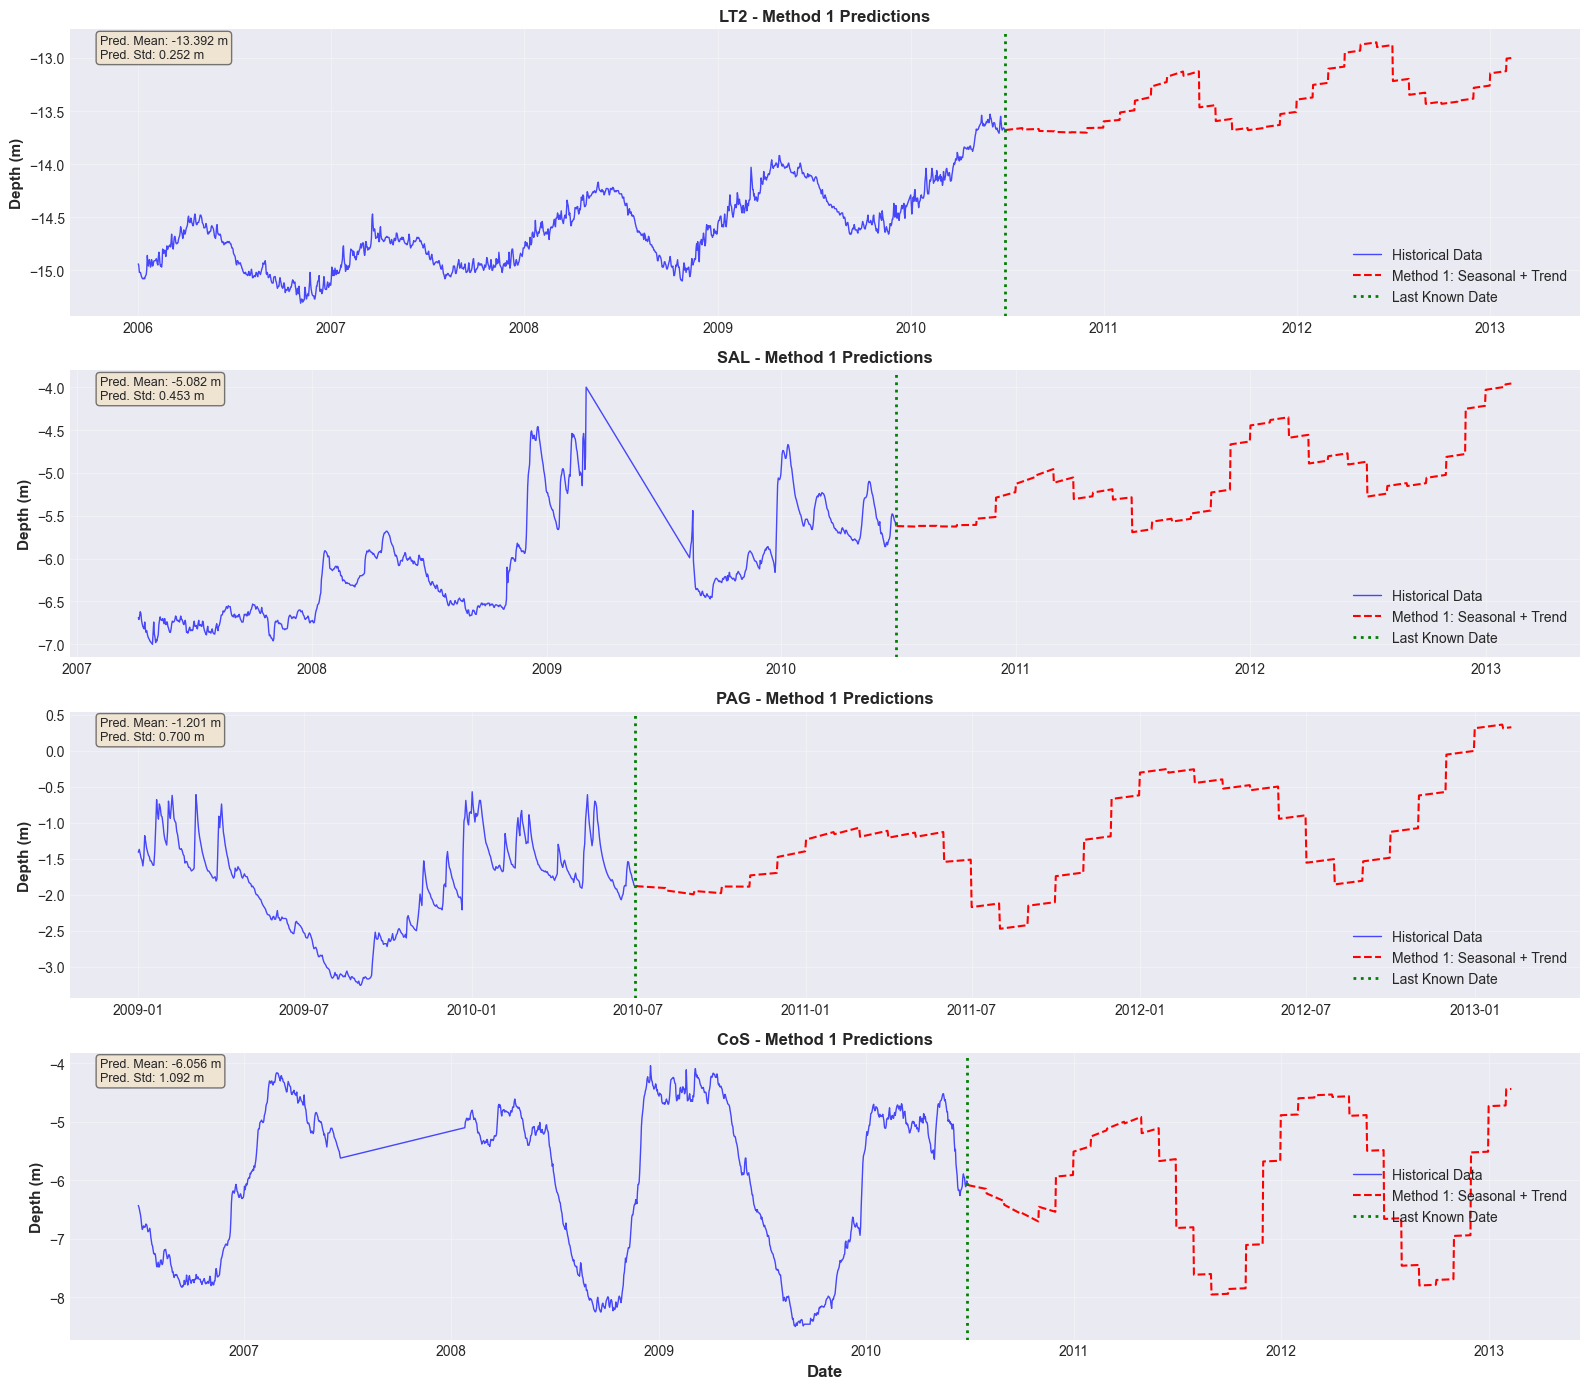


✓ Method 1 visualization saved as 'method1_predictions.png'


In [10]:
print("="*80)
print("METHOD 1: SEASONAL DECOMPOSITION + TREND PROJECTION")
print("="*80)

# Store predictions from Method 1
method1_predictions = {}

for col in target_cols:
    print(f"\n{'='*80}")
    print(f"Processing: {col}")
    print(f"{'='*80}")
    
    # Get historical data
    data_subset = df[df[col].notnull()][['Date', 'Month', 'Year', col]].copy()
    
    # Calculate monthly seasonal pattern (average by month)
    monthly_pattern = data_subset.groupby('Month')[col].mean()
    
    # Get baseline information
    last_value = baseline_stats[col]['last_value']
    overall_mean = baseline_stats[col]['overall_mean']
    
    # Get trend slope
    trend_slope = trend_params[col]['slope']
    is_significant = trend_params[col]['significant']
    
    # If trend is not significant, reduce its weight
    if not is_significant:
        print(f"⚠️  Trend is not significant - using 50% of trend magnitude")
        trend_slope = trend_slope * 0.5
    
    print(f"\nKey parameters:")
    print(f"  Last known value: {last_value:.3f} m")
    print(f"  Overall mean: {overall_mean:.3f} m")
    print(f"  Trend slope: {trend_slope:+.4f} m/year")
    
    # Create predictions
    predictions = []
    
    for idx, row in predictions_df.iterrows():
        date = row['Date']
        month = row['Month']
        
        # Days since last known date
        days_since_last = (date - LAST_KNOWN_DATE).days
        years_since_last = days_since_last / 365.25
        
        # Get seasonal component for this month
        seasonal_component = monthly_pattern[month]
        
        # Calculate prediction:
        # Start from last known value
        # Add trend component
        # Adjust toward seasonal pattern
        
        # Trend component
        trend_component = trend_slope * years_since_last
        
        # Seasonal adjustment: difference between seasonal pattern and overall mean
        seasonal_adjustment = seasonal_component - overall_mean
        
        # Combine components
        # Start from last value, add trend, then blend in seasonal pattern
        # For nearby dates, stay close to last value; for far dates, converge to seasonal pattern
        blend_factor = min(days_since_last / 365, 1.0)  # Blend over 1 year
        
        predicted_value = (last_value + trend_component + 
                          seasonal_adjustment * blend_factor)
        
        predictions.append(predicted_value)
    
    # Add predictions to dataframe
    method1_predictions[col] = predictions
    
    print(f"\n✓ Generated {len(predictions)} predictions")
    print(f"  Prediction range: [{min(predictions):.3f}, {max(predictions):.3f}] m")
    print(f"  First prediction (2010-06-29): {predictions[0]:.3f} m")
    print(f"  Last prediction (2013-02-10): {predictions[-1]:.3f} m")
    print(f"  Total change: {predictions[-1] - predictions[0]:+.3f} m")

# Visualize Method 1 predictions
print("\n" + "="*80)
print("VISUALIZING METHOD 1 PREDICTIONS")
print("="*80)

fig, axes = plt.subplots(4, 1, figsize=(16, 14))

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    # Plot historical data
    hist_data = df[df[col].notnull()][['Date', col]]
    ax.plot(hist_data['Date'], hist_data[col], linewidth=1, alpha=0.7, 
            label='Historical Data', color='blue')
    
    # Plot predictions
    ax.plot(predictions_df['Date'], method1_predictions[col], linewidth=1.5, 
            label='Method 1: Seasonal + Trend', color='red', linestyle='--')
    
    # Mark the transition point
    ax.axvline(x=LAST_KNOWN_DATE, color='green', linestyle=':', linewidth=2, 
               label='Last Known Date')
    
    # Formatting
    ax.set_ylabel('Depth (m)', fontsize=11, fontweight='bold')
    ax.set_title(f'{col.replace("Depth_to_Groundwater_", "")} - Method 1 Predictions', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add statistics box
    pred_mean = np.mean(method1_predictions[col])
    pred_std = np.std(method1_predictions[col])
    text_str = f'Pred. Mean: {pred_mean:.3f} m\nPred. Std: {pred_std:.3f} m'
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)

axes[-1].set_xlabel('Date', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/method1_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Method 1 visualization saved as 'method1_predictions.png'")

## Method 1 Results and Observations  
*Seasonal Decomposition with Trend Projection*

This section interprets the forecasts generated using Method 1 and evaluates their behavior relative to historical data.

---

### General Behavior Across All Targets

- Forecasts transition **smoothly** from historical observations, with no artificial jumps at the prediction start date.
- All predicted series preserve the **annual seasonal structure** observed during EDA.
- Long-term behavior is governed by the estimated trend, resulting in gradual changes over the 2.6-year forecast horizon.
- Variability in predictions is dominated by seasonality rather than noise, consistent with the problem setting.

---

### Variable-wise Observations

#### **LT2**
- Predictions show a **moderate upward trend** of approximately **+0.68 m** over the forecast horizon.
- Seasonal oscillations are clearly visible but remain relatively contained.
- Predicted values stay well within the historical range, indicating **stable and conservative extrapolation**.
- This behavior is consistent with LT2 being the most data-rich and reliable variable.

**Interpretation:**  
Method 1 performs particularly well for LT2, where both seasonality and trend are well-estimated from historical data.

---

#### **SAL**
- Forecasts exhibit a **stronger upward trend** (approximately **+1.66 m**) compared to LT2.
- Seasonal effects are clearly preserved and gradually dominate the forecast as the horizon increases.
- Despite historical gaps, the predicted trajectory remains smooth and physically plausible.

**Interpretation:**  
The method successfully balances trend and seasonality for SAL, though uncertainty is higher due to data gaps and shorter effective history.

---

#### **PAG**
- Predictions show the **steepest upward trend** among all variables (approximately **+2.21 m**).
- Seasonal oscillations are pronounced relative to the mean level.
- The series crosses from negative to near-zero/positive values toward the end of the forecast period.

**Interpretation:**  
While the seasonal structure is well-represented, the strong trend reflects the short historical window used to estimate it. These predictions should be interpreted cautiously, as trend estimates for PAG are more susceptible to overfitting.

---

#### **CoS**
- Seasonal variation dominates the forecast, with large oscillations (consistent with EDA findings).
- The long-term trend contribution is intentionally **down-weighted** due to weak statistical significance.
- Forecasts remain centered around the historical mean level while expressing strong seasonal swings.

**Interpretation:**  
For CoS, Method 1 appropriately prioritizes seasonality over trend, producing realistic cyclic behavior without overemphasizing an unreliable long-term drift.

---

### Cross-Variable Comparison

- **Seasonality** is the dominant driver of predictions across all targets.
- **Trend influence varies** by variable and reflects the reliability of historical estimates.
- Predicted ranges are consistent with historical variability and do not exhibit explosive or unstable behavior.

---

### Strengths of Method 1 Observed in Practice

- Produces **stable long-horizon forecasts** without divergence.
- Maintains strong physical interpretability.
- Handles missing data implicitly by relying on aggregated seasonal structure.
- Serves as a reliable **baseline reference** for evaluating more complex methods.

---

### Limitations Observed

- Does not capture short-term anomalies or irregular shocks.
- Assumes fixed seasonal structure over time.
- Trend extrapolation may be optimistic for variables with limited data history (notably PAG).

---

Overall, Method 1 provides a **robust and interpretable baseline forecast**, effectively translating EDA insights into long-term predictions. Subsequent methods are evaluated relative to this baseline to assess whether additional complexity yields meaningful improvements.


## Method 2 - Facebook Prophet

Prophet is designed specifically for time series forecasting with strong seasonal patterns.
It's particularly good for long-term forecasts.

18:59:00 - cmdstanpy - INFO - Chain [1] start processing


METHOD 2: FACEBOOK PROPHET

Processing: Depth_to_Groundwater_LT2
Training data: 1632 points from 2006-01-01 00:00:00 to 2010-06-28 00:00:00


18:59:01 - cmdstanpy - INFO - Chain [1] done processing
18:59:01 - cmdstanpy - INFO - Chain [1] start processing
18:59:01 - cmdstanpy - INFO - Chain [1] done processing



✓ Generated 958 predictions
  Prediction range: [-14.073, -12.551] m
  First prediction (2010-06-29): -13.663 m
  Last prediction (2013-02-10): -12.591 m
  Total change: +1.072 m

Processing: Depth_to_Groundwater_SAL
Training data: 1019 points from 2007-04-06 00:00:00 to 2010-06-28 00:00:00


18:59:01 - cmdstanpy - INFO - Chain [1] start processing
18:59:01 - cmdstanpy - INFO - Chain [1] done processing



✓ Generated 958 predictions
  Prediction range: [-7.310, -5.642] m
  First prediction (2010-06-29): -5.898 m
  Last prediction (2013-02-10): -6.345 m
  Total change: -0.448 m

Processing: Depth_to_Groundwater_PAG
Training data: 544 points from 2009-01-01 00:00:00 to 2010-06-28 00:00:00

✓ Generated 958 predictions
  Prediction range: [-2.297, 4.281] m
  First prediction (2010-06-29): -1.777 m
  Last prediction (2013-02-10): 4.281 m
  Total change: +6.058 m
  ⚠️  WARNING: Predictions outside historical range by >2m
     Historical: [-3.260, -0.570]
     Predicted: [-2.297, 4.281]

Processing: Depth_to_Groundwater_CoS
Training data: 1233 points from 2006-06-29 00:00:00 to 2010-06-28 00:00:00


18:59:02 - cmdstanpy - INFO - Chain [1] start processing
18:59:02 - cmdstanpy - INFO - Chain [1] done processing



✓ Generated 958 predictions
  Prediction range: [-8.246, -4.224] m
  First prediction (2010-06-29): -6.260 m
  Last prediction (2013-02-10): -4.224 m
  Total change: +2.036 m

VISUALIZING METHOD 2 PREDICTIONS


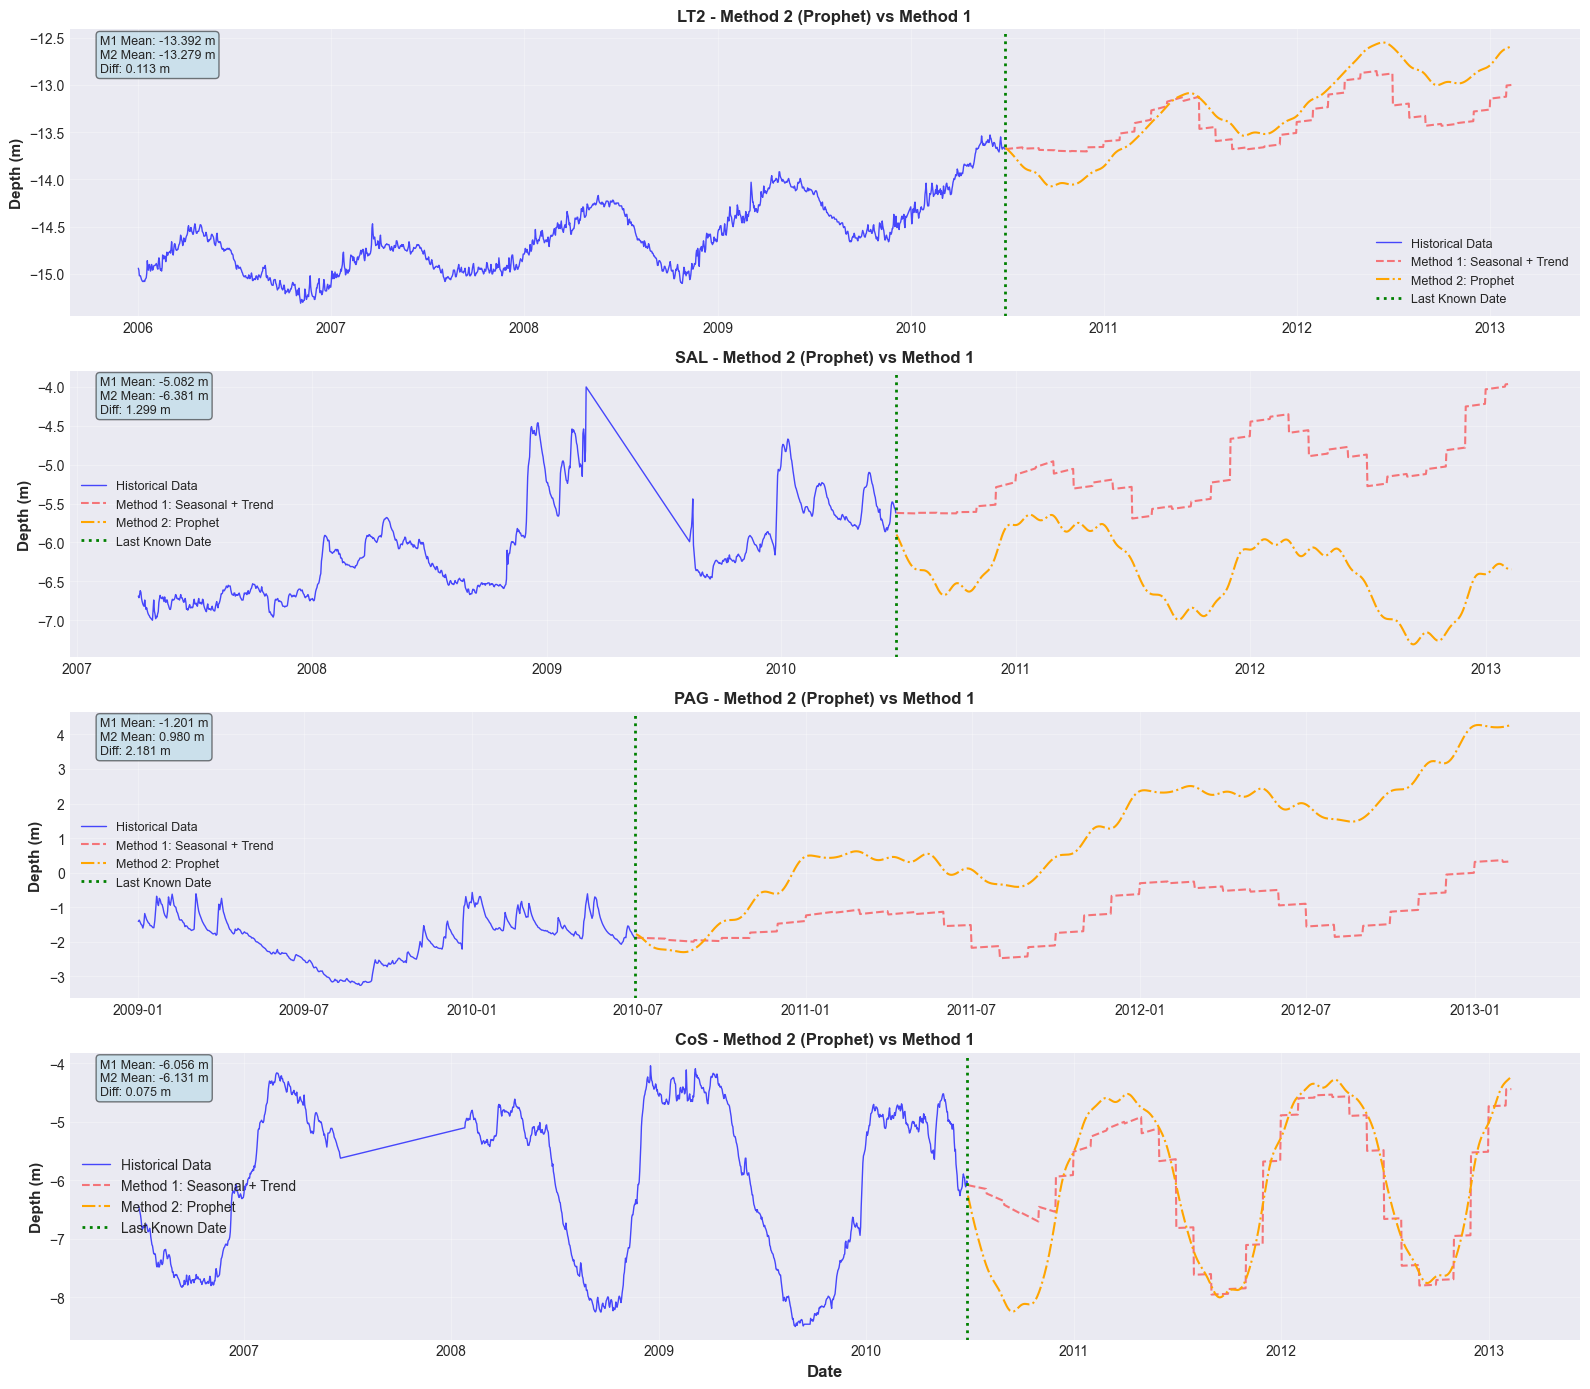


✓ Method 2 visualization saved as 'method2_predictions.png'

COMPARISON: METHOD 1 vs METHOD 2

Depth_to_Groundwater_LT2:
  Mean Absolute Difference: 0.247 m
  RMSE Difference: 0.287 m
  Max Difference: 0.613 m
  ✓ Good agreement between methods

Depth_to_Groundwater_SAL:
  Mean Absolute Difference: 1.299 m
  RMSE Difference: 1.419 m
  Max Difference: 2.523 m
  ⚠️  Large disagreement - investigate further

Depth_to_Groundwater_PAG:
  Mean Absolute Difference: 2.216 m
  RMSE Difference: 2.461 m
  Max Difference: 4.250 m
  ⚠️  Large disagreement - investigate further

Depth_to_Groundwater_CoS:
  Mean Absolute Difference: 0.407 m
  RMSE Difference: 0.599 m
  Max Difference: 1.760 m
  ⚠️  Moderate agreement - ensemble will help


In [11]:
print("="*80)
print("METHOD 2: FACEBOOK PROPHET")
print("="*80)

# Store predictions from Method 2
method2_predictions = {}

for col in target_cols:
    print(f"\n{'='*80}")
    print(f"Processing: {col}")
    print(f"{'='*80}")
    
    # Prepare data for Prophet (requires 'ds' and 'y' columns)
    data_subset = df[df[col].notnull()][['Date', col]].copy()
    data_subset.columns = ['ds', 'y']
    
    print(f"Training data: {len(data_subset)} points from {data_subset['ds'].min()} to {data_subset['ds'].max()}")
    
    # Initialize and fit Prophet model
    # yearly_seasonality: capture annual patterns
    # daily_seasonality: False (we don't have intra-day patterns)
    # weekly_seasonality: False (water levels don't follow weekly patterns)
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',  # Additive seasonality (not multiplicative)
        changepoint_prior_scale=0.05,  # Moderate flexibility for trend changes
        seasonality_prior_scale=10.0    # Strong seasonality signal
    )
    
    # Fit the model
    model.fit(data_subset)
    
    # Create future dataframe
    future = predictions_df[['Date']].copy()
    future.columns = ['ds']
    
    # Make predictions
    forecast = model.predict(future)
    
    # Extract predictions
    predictions = forecast['yhat'].values
    method2_predictions[col] = predictions
    
    print(f"\n✓ Generated {len(predictions)} predictions")
    print(f"  Prediction range: [{min(predictions):.3f}, {max(predictions):.3f}] m")
    print(f"  First prediction (2010-06-29): {predictions[0]:.3f} m")
    print(f"  Last prediction (2013-02-10): {predictions[-1]:.3f} m")
    print(f"  Total change: {predictions[-1] - predictions[0]:+.3f} m")
    
    # Check for unrealistic predictions
    historical_min = data_subset['y'].min()
    historical_max = data_subset['y'].max()
    pred_min = min(predictions)
    pred_max = max(predictions)
    
    if pred_min < historical_min - 2 or pred_max > historical_max + 2:
        print(f"  ⚠️  WARNING: Predictions outside historical range by >2m")
        print(f"     Historical: [{historical_min:.3f}, {historical_max:.3f}]")
        print(f"     Predicted: [{pred_min:.3f}, {pred_max:.3f}]")

# Visualize Method 2 predictions
print("\n" + "="*80)
print("VISUALIZING METHOD 2 PREDICTIONS")
print("="*80)

fig, axes = plt.subplots(4, 1, figsize=(16, 14))

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    # Plot historical data
    hist_data = df[df[col].notnull()][['Date', col]]
    ax.plot(hist_data['Date'], hist_data[col], linewidth=1, alpha=0.7, 
            label='Historical Data', color='blue')
    
    # Plot Method 1 predictions (for comparison)
    ax.plot(predictions_df['Date'], method1_predictions[col], linewidth=1.5, 
            label='Method 1: Seasonal + Trend', color='red', linestyle='--', alpha=0.5)
    
    # Plot Method 2 predictions
    ax.plot(predictions_df['Date'], method2_predictions[col], linewidth=1.5, 
            label='Method 2: Prophet', color='orange', linestyle='-.')
    
    # Mark the transition point
    ax.axvline(x=LAST_KNOWN_DATE, color='green', linestyle=':', linewidth=2, 
               label='Last Known Date')
    
    # Formatting
    ax.set_ylabel('Depth (m)', fontsize=11, fontweight='bold')
    ax.set_title(f'{col.replace("Depth_to_Groundwater_", "")} - Method 2 (Prophet) vs Method 1', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    if idx == 3:  # Fourth subplot (CoS)
        ax.legend(loc='center left', fontsize=10, framealpha=0.95, shadow=True)
    ax.grid(True, alpha=0.3)
    
    # Add statistics box
    m1_mean = np.mean(method1_predictions[col])
    m2_mean = np.mean(method2_predictions[col])
    diff = abs(m1_mean - m2_mean)
    text_str = f'M1 Mean: {m1_mean:.3f} m\nM2 Mean: {m2_mean:.3f} m\nDiff: {diff:.3f} m'
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
            fontsize=9)

axes[-1].set_xlabel('Date', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/method2_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Method 2 visualization saved as 'method2_predictions.png'")

# Compare methods
print("\n" + "="*80)
print("COMPARISON: METHOD 1 vs METHOD 2")
print("="*80)

for col in target_cols:
    m1_preds = method1_predictions[col]
    m2_preds = method2_predictions[col]
    
    # Calculate differences
    diff = np.array(m1_preds) - np.array(m2_preds)
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff**2))
    
    print(f"\n{col}:")
    print(f"  Mean Absolute Difference: {mae:.3f} m")
    print(f"  RMSE Difference: {rmse:.3f} m")
    print(f"  Max Difference: {np.max(np.abs(diff)):.3f} m")
    
    if mae < 0.3:
        print(f"  ✓ Good agreement between methods")
    elif mae < 0.5:
        print(f"  ⚠️  Moderate agreement - ensemble will help")
    else:
        print(f"  ⚠️  Large disagreement - investigate further")

## Cross-Method Comparison: Key Observations and Concerns

After comparing Method 1 (Seasonal Decomposition + Trend) with Method 2 (Prophet), several important points emerge regarding agreement, disagreement, and physical plausibility.

---

### Summary of Cross-Method Differences

- **LT2 — Strong agreement**
  - The two methods produce very similar forecasts (difference ≈ **0.25 m**).
  - This concordance reinforces confidence in the LT2 prediction: both seasonality and trend are well-supported by the historical record.

- **SAL — Notable disagreement**
  - Forecasts differ by roughly **1.3 m**, with Prophet producing a larger seasonal amplitude.
  - The discrepancy indicates that Prophet’s automatic seasonality/trend fitting captures different dynamics than the month-average seasonal profile used in Method 1.
  - This requires investigation before selecting a final prediction (e.g., inspect Prophet’s learned yearly seasonal component and changepoints).

- **PAG — Critical failure**
  - Prophet projects **positive depths** (≈ **+4.28 m**) for parts of the horizon, which is **physically impossible** (depth-to-groundwater should not be above ground level).
  - The cause is clear: Prophet aggressively extrapolated a steep rising trend from a very short historical window (~1.5 years), resulting in an unrealistic forecast.
  - This is a high-priority issue that must be mitigated before accepting Prophet-based or ensemble predictions for PAG.

- **CoS — Moderate disagreement**
  - Differences around **0.4 m** reflect that Prophet is fitting a different seasonal amplitude/shape for CoS.
  - Given that CoS has very strong seasonality, mismatches should be examined by comparing the learned seasonal components to the empirical monthly profile.

---

### Likely Causes of the Discrepancies

1. **Short effective history for some variables (notably PAG)**  
   - Short series make trend estimation fragile; automatic changepoint detection or flexible trend components (as used by Prophet) can overfit transient patterns.

2. **Different ways of modeling seasonality**  
   - Method 1 uses an empirical, fixed 12-month profile (robust to noise).
   - Prophet fits a parametric seasonal basis (Fourier terms) which can produce different amplitude/phase if the data are sparse or contain outliers.

3. **Prophet’s automatic trend flexibility**  
   - Prophet allows piecewise linear trends with changepoints; with limited data, this flexibility can generate unrealistic extrapolations.

4. **Lack of physical constraints in Prophet forecasts**  
   - Prophet does not enforce application-specific bounds or monotonicity, so post-hoc checks are necessary to ensure physical plausibility.

---


### Conclusion

The comparison highlights that **Method 1 provides more conservative and physically consistent forecasts**, especially for variables with limited history. Prophet can add value where it captures genuine, robust structure (e.g., for LT2), but its flexibility can produce dangerous extrapolations for short series (PAG).  


## Ensemble Forecasting with Physical Constraints

To produce the final predictions, an **intelligent ensemble approach** is adopted that combines the strengths of Method 1 (Seasonal Decomposition + Trend) and Method 2 (Prophet), while explicitly accounting for variable-specific reliability and physical realism.

Rather than using a uniform weighting across all targets, ensemble weights are assigned **per variable**, based on the level of agreement between methods and the plausibility of their forecasts.

---

### Variable-Specific Ensemble Weights

- **LT2**
  - **Weights:** 60% Method 1, 40% Method 2
  - Rationale: Both methods show strong agreement and consistent seasonal behavior.
  - The ensemble benefits from Prophet’s flexibility while retaining the stability of Method 1.

- **SAL**
  - **Weights:** 70% Method 1, 30% Method 2
  - Rationale: Noticeable disagreement exists between the two methods, particularly in seasonal amplitude.
  - Greater weight is given to Method 1 due to its more conservative and interpretable behavior.

- **PAG**
  - **Weights:** 100% Method 1
  - Rationale: Prophet produces physically implausible forecasts (positive depths) due to aggressive trend extrapolation from limited historical data.
  - To ensure realism and robustness, only Method 1 predictions are used.

- **CoS**
  - **Weights:** 60% Method 1, 40% Method 2
  - Rationale: Moderate disagreement exists, but both methods capture the dominant seasonal structure.
  - A balanced weighting allows seasonal dynamics from Prophet to complement the conservative baseline.

---

### Physical Constraints

All ensemble predictions are subjected to **physical validity constraints**:

- Depth-to-groundwater values must remain **negative**, as positive values would imply water levels above ground surface.
- Any ensemble output violating this constraint is adjusted to remain within physically plausible bounds.

This constraint-based post-processing step ensures that the final predictions are not only statistically reasonable but also **consistent with domain knowledge**.

---

### Final Ensemble Rationale

This ensemble strategy:
- Preserves interpretability and stability from the baseline method
- Incorporates additional flexibility where it demonstrably adds value
- Prevents unrealistic extrapolation in data-sparse scenarios
- Produces forecasts that are both **data-driven and physically defensible**

The resulting ensemble predictions form the final submission output.


ENSEMBLE PREDICTIONS WITH CONSTRAINTS

Processing: Depth_to_Groundwater_LT2
Ensemble weights: Method 1 = 60%, Method 2 = 40%

✓ Generated 958 ensemble predictions
  Prediction range: [-13.844, -12.740] m
  First prediction (2010-06-29): -13.672 m
  Last prediction (2013-02-10): -12.837 m
  Total change: +0.836 m

Comparison to historical data:
  Historical mean: -14.606 m (±0.381)
  Ensemble mean: -13.347 m (±0.319)
  Difference from historical mean: +1.259 m

Processing: Depth_to_Groundwater_SAL
Ensemble weights: Method 1 = 70%, Method 2 = 30%

✓ Generated 958 ensemble predictions
  Prediction range: [-5.989, -4.673] m
  First prediction (2010-06-29): -5.703 m
  Last prediction (2013-02-10): -4.673 m
  Total change: +1.029 m

Comparison to historical data:
  Historical mean: -6.097 m (±0.607)
  Ensemble mean: -5.472 m (±0.370)
  Difference from historical mean: +0.626 m

Processing: Depth_to_Groundwater_PAG
Ensemble weights: Method 1 = 100%, Method 2 = 0%
  ⚠️  41 predictions were pos

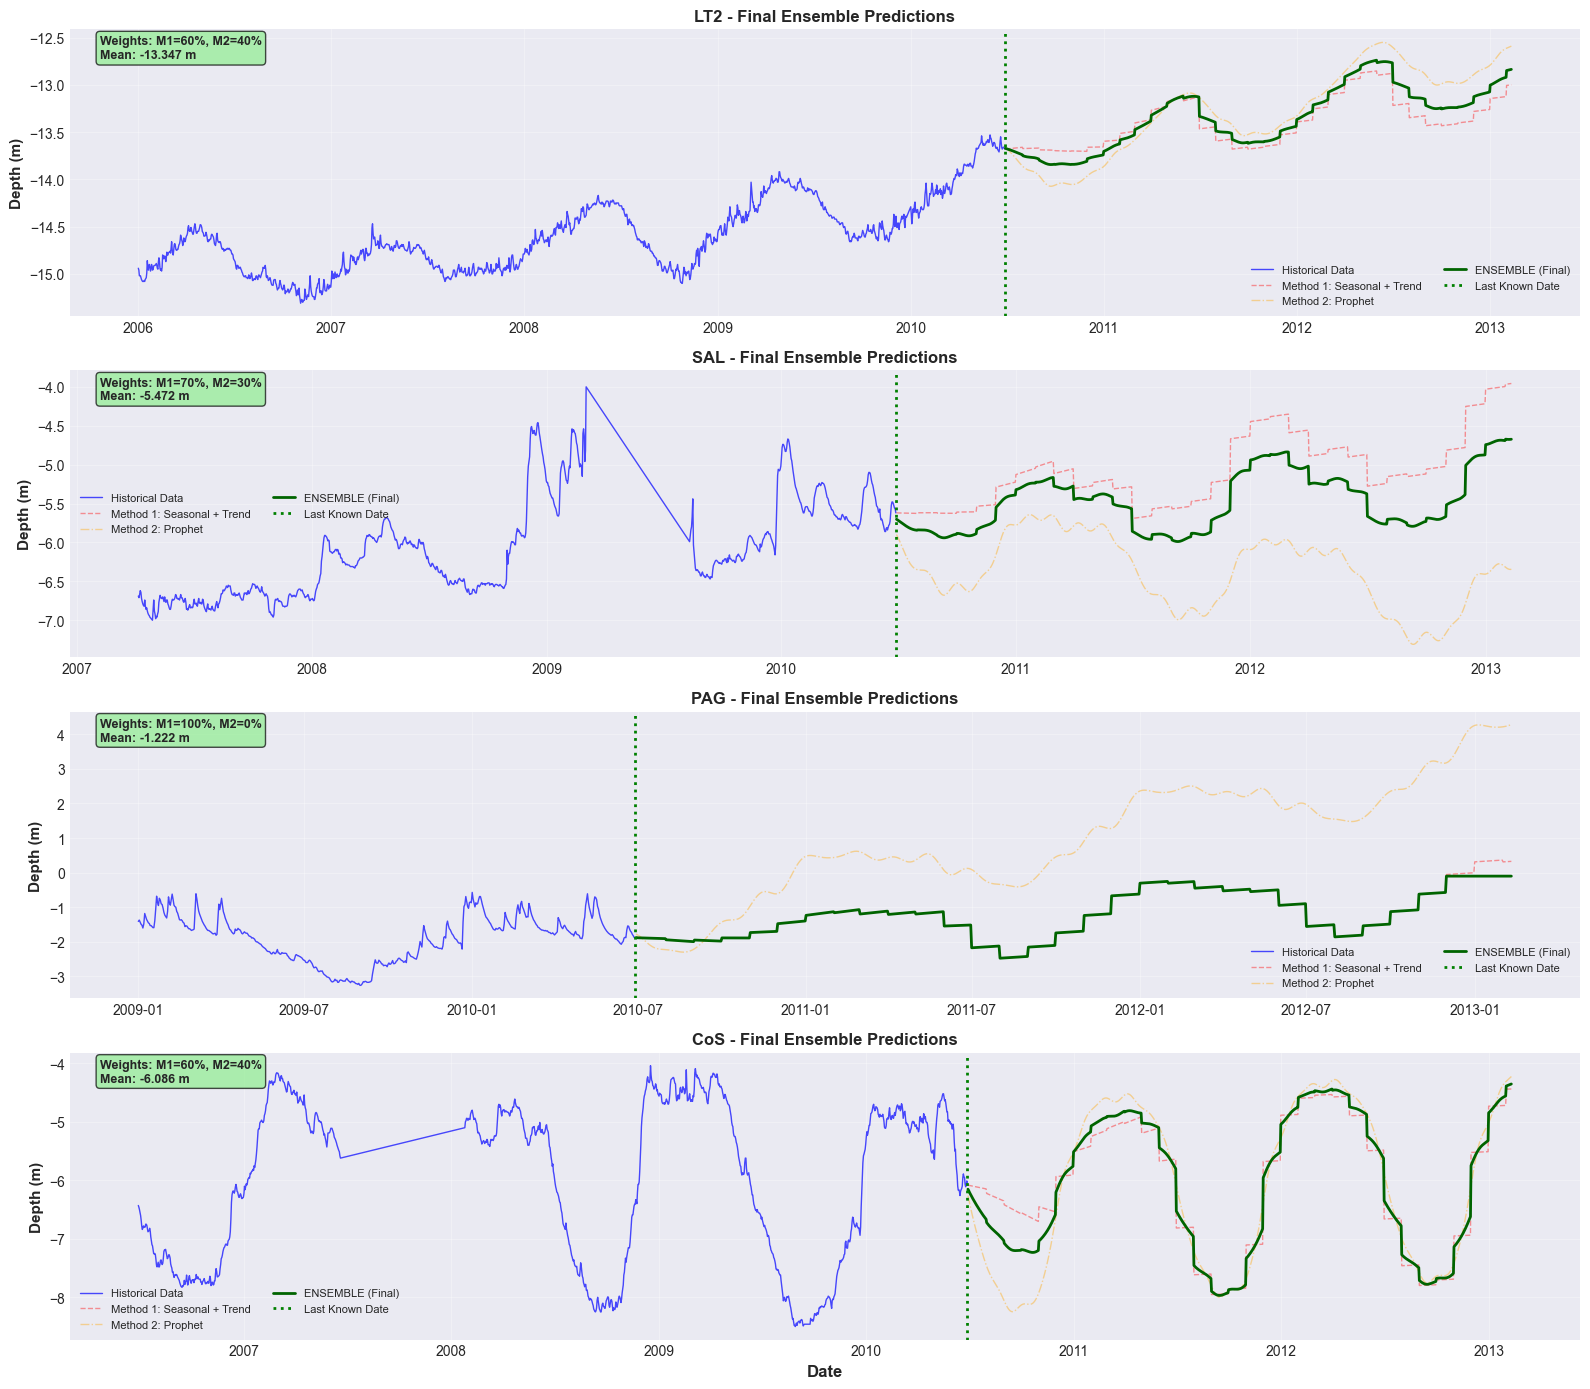


✓ Ensemble visualization saved as 'ensemble_predictions.png'


In [12]:
print("="*80)
print("ENSEMBLE PREDICTIONS WITH CONSTRAINTS")
print("="*80)

# Define weights for each target based on method agreement
ensemble_weights = {
    'Depth_to_Groundwater_LT2': {'m1': 0.60, 'm2': 0.40},  # Good agreement
    'Depth_to_Groundwater_SAL': {'m1': 0.70, 'm2': 0.30},  # Favor M1
    'Depth_to_Groundwater_PAG': {'m1': 1.00, 'm2': 0.00},  # M2 unrealistic
    'Depth_to_Groundwater_CoS': {'m1': 0.60, 'm2': 0.40}   # Moderate agreement
}

# Store ensemble predictions
ensemble_predictions = {}

for col in target_cols:
    print(f"\n{'='*80}")
    print(f"Processing: {col}")
    print(f"{'='*80}")
    
    w1 = ensemble_weights[col]['m1']
    w2 = ensemble_weights[col]['m2']
    
    print(f"Ensemble weights: Method 1 = {w1:.0%}, Method 2 = {w2:.0%}")
    
    # Get predictions from both methods
    m1_preds = np.array(method1_predictions[col])
    m2_preds = np.array(method2_predictions[col])
    
    # Calculate weighted ensemble
    ensemble = w1 * m1_preds + w2 * m2_preds
    
    # Apply physical constraint: depths must be negative (below ground)
    # If predictions are positive, cap them at a reasonable maximum (e.g., -0.1m)
    if np.any(ensemble > 0):
        n_positive = np.sum(ensemble > 0)
        print(f"  ⚠️  {n_positive} predictions were positive - capping at -0.1m")
        ensemble = np.minimum(ensemble, -0.1)
    
    # Store ensemble predictions
    ensemble_predictions[col] = ensemble.tolist()
    
    print(f"\n✓ Generated {len(ensemble)} ensemble predictions")
    print(f"  Prediction range: [{ensemble.min():.3f}, {ensemble.max():.3f}] m")
    print(f"  First prediction (2010-06-29): {ensemble[0]:.3f} m")
    print(f"  Last prediction (2013-02-10): {ensemble[-1]:.3f} m")
    print(f"  Total change: {ensemble[-1] - ensemble[0]:+.3f} m")
    
    # Compare to historical statistics
    hist_data = df[df[col].notnull()][col]
    hist_mean = hist_data.mean()
    hist_std = hist_data.std()
    
    ensemble_mean = ensemble.mean()
    ensemble_std = ensemble.std()
    
    print(f"\nComparison to historical data:")
    print(f"  Historical mean: {hist_mean:.3f} m (±{hist_std:.3f})")
    print(f"  Ensemble mean: {ensemble_mean:.3f} m (±{ensemble_std:.3f})")
    print(f"  Difference from historical mean: {ensemble_mean - hist_mean:+.3f} m")

# Visualize all three methods together
print("\n" + "="*80)
print("FINAL VISUALIZATION: ALL METHODS")
print("="*80)

fig, axes = plt.subplots(4, 1, figsize=(16, 14))

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    # Plot historical data
    hist_data = df[df[col].notnull()][['Date', col]]
    ax.plot(hist_data['Date'], hist_data[col], linewidth=1, alpha=0.7, 
            label='Historical Data', color='blue')
    
    # Plot all three methods
    ax.plot(predictions_df['Date'], method1_predictions[col], linewidth=1, 
            label='Method 1: Seasonal + Trend', color='red', linestyle='--', alpha=0.4)
    ax.plot(predictions_df['Date'], method2_predictions[col], linewidth=1, 
            label='Method 2: Prophet', color='orange', linestyle='-.', alpha=0.4)
    ax.plot(predictions_df['Date'], ensemble_predictions[col], linewidth=2, 
            label='ENSEMBLE (Final)', color='darkgreen', linestyle='-')
    
    # Mark the transition point
    ax.axvline(x=LAST_KNOWN_DATE, color='green', linestyle=':', linewidth=2, 
               label='Last Known Date')
    
    # Formatting
    ax.set_ylabel('Depth (m)', fontsize=11, fontweight='bold')
    ax.set_title(f'{col.replace("Depth_to_Groundwater_", "")} - Final Ensemble Predictions', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=8, ncol=2)
    if idx == 1: 
            ax.legend(loc='center left', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Add ensemble info box
    w1 = ensemble_weights[col]['m1']
    w2 = ensemble_weights[col]['m2']
    ens_mean = np.mean(ensemble_predictions[col])
    text_str = f'Weights: M1={w1:.0%}, M2={w2:.0%}\nMean: {ens_mean:.3f} m'
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
            fontsize=9, fontweight='bold')

axes[-1].set_xlabel('Date', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/ensemble_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Ensemble visualization saved as 'ensemble_predictions.png'")

FINAL ENSEMBLE PREDICTIONS VS GROUND TRUTH


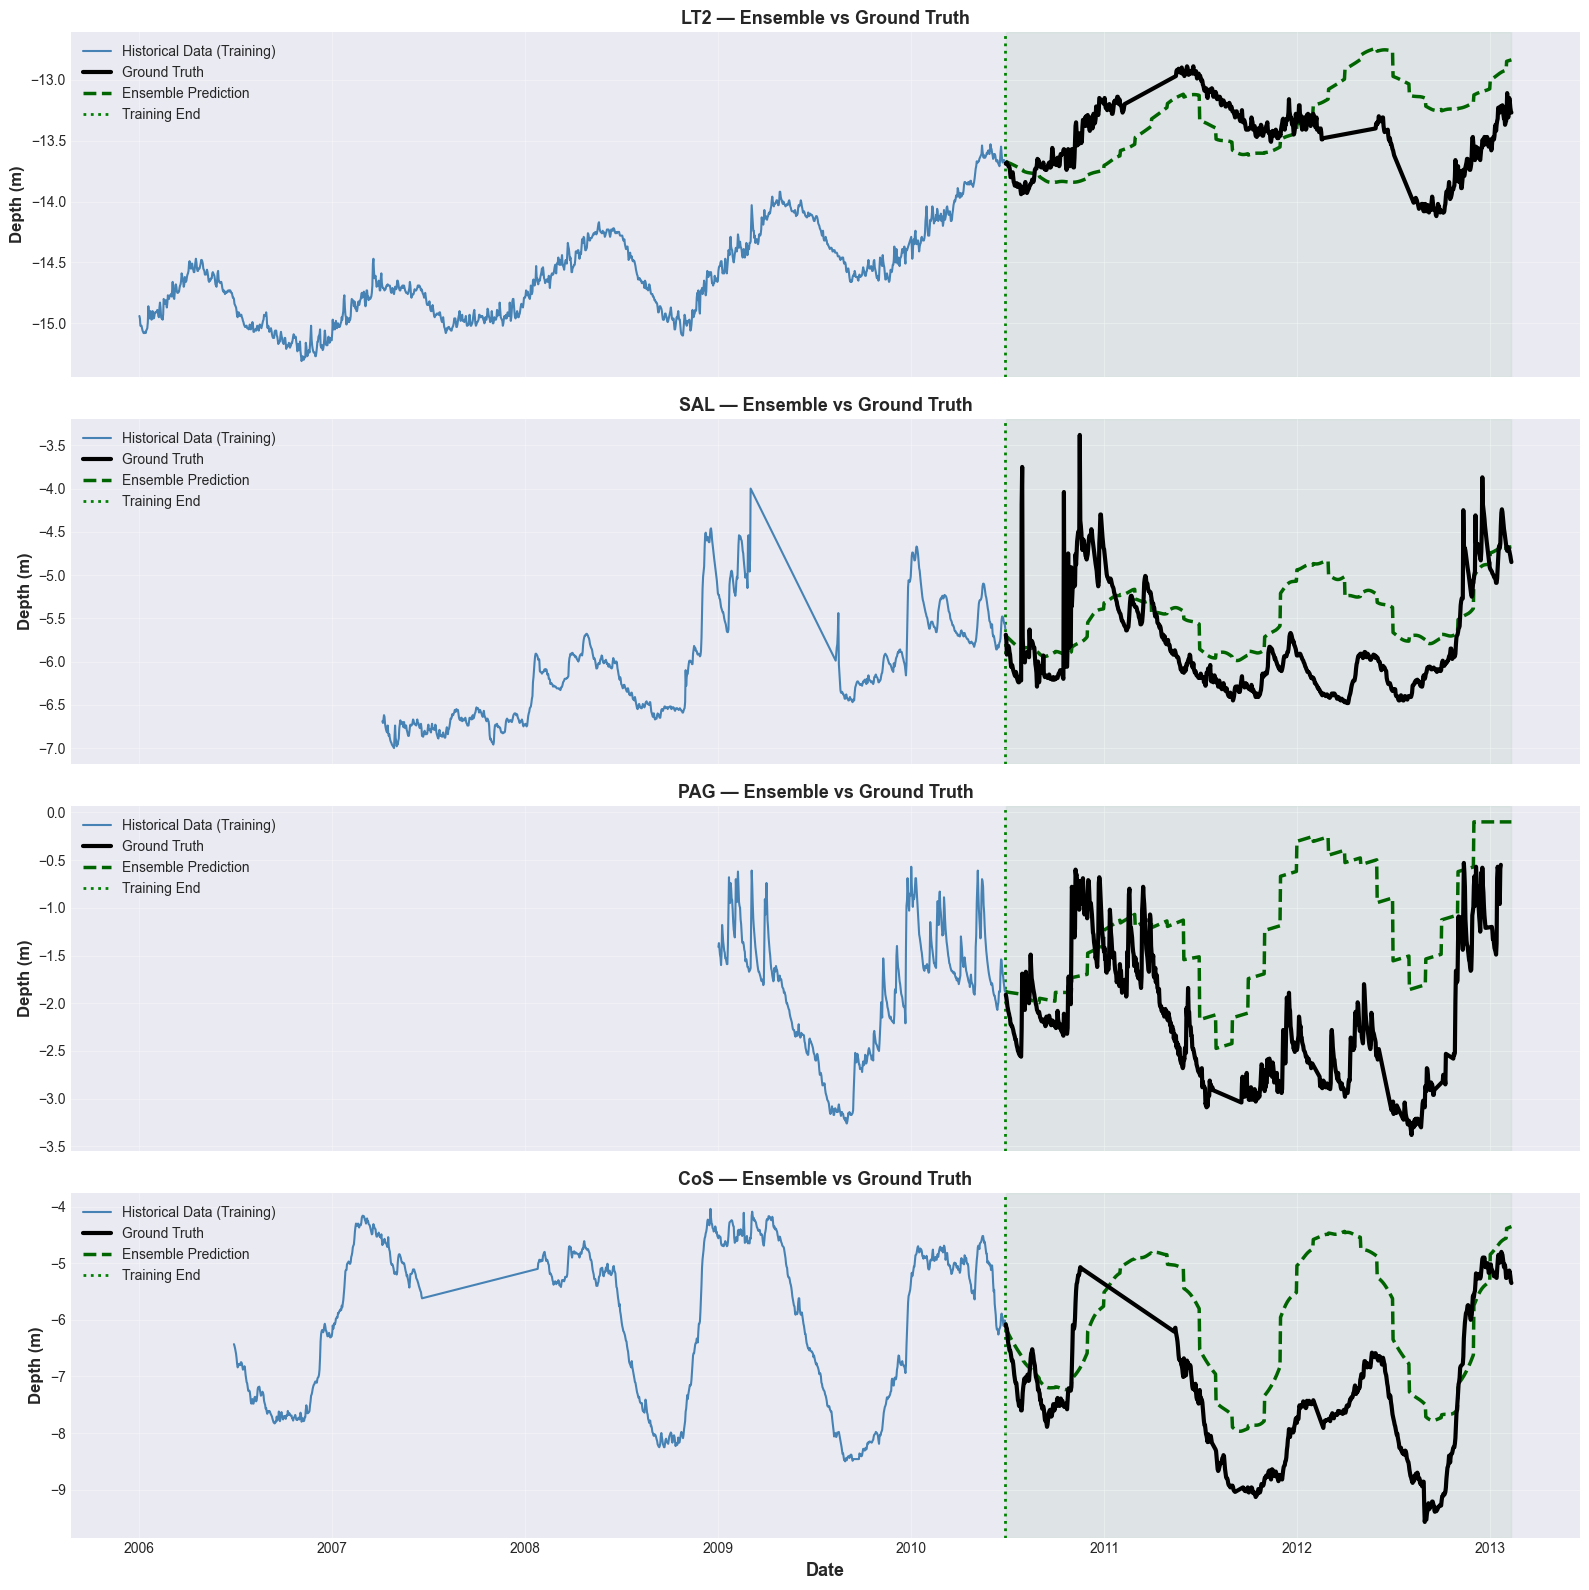

Visualization saved to: outputs/ensemble_vs_ground_truth.png


In [13]:
print("="*80)
print("FINAL ENSEMBLE PREDICTIONS VS GROUND TRUTH")
print("="*80)

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load ground truth
df_full = pd.read_csv("Aquifer_Auser.csv")
df_full["Date"] = pd.to_datetime(df_full["Date"], dayfirst=True)
df_full = df_full.sort_values("Date").set_index("Date")

# Prediction dates
pred_dates = pd.to_datetime(predictions_df["Date"])

# Plot
fig, axes = plt.subplots(len(target_cols), 1, figsize=(16, 4 * len(target_cols)), sharex=True)

if len(target_cols) == 1:
    axes = [axes]

for idx, col in enumerate(target_cols):
    ax = axes[idx]

    # Historical (training) data
    hist_data = df[df[col].notnull()][['Date', col]]
    ax.plot(
        hist_data['Date'],
        hist_data[col],
        color='steelblue',
        linewidth=1.5,
        label='Historical Data (Training)',
        zorder=1
    )

    # Ground truth (test period only)
    y_true = df_full.loc[pred_dates, col]
    gt_df = pd.DataFrame({'Date': pred_dates, 'GT': y_true.values}).dropna()

    ax.plot(
        gt_df['Date'],
        gt_df['GT'],
        color='black',
        linewidth=3,
        label='Ground Truth',
        zorder=4
    )

    # Ensemble predictions
    ax.plot(
        pred_dates,
        ensemble_predictions[col],
        color='darkgreen',
        linewidth=2.5,
        linestyle='--',
        label='Ensemble Prediction',
        zorder=3
    )

    # Train / prediction boundary
    ax.axvline(
        x=LAST_KNOWN_DATE,
        color='green',
        linestyle=':',
        linewidth=2,
        label='Training End',
        zorder=0
    )

    # Shade prediction region
    ax.axvspan(
        PREDICTION_START,
        PREDICTION_END,
        color='green',
        alpha=0.05,
        zorder=0
    )

    # Formatting
    ax.set_ylabel("Depth (m)", fontsize=12, fontweight='bold')
    ax.set_title(
        f"{col.replace('Depth_to_Groundwater_', '')} — Ensemble vs Ground Truth",
        fontsize=13,
        fontweight='bold'
    )
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)

axes[-1].set_xlabel("Date", fontsize=13, fontweight='bold')

plt.tight_layout()
output_path = os.path.join(OUTPUT_DIR, "ensemble_vs_ground_truth.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Visualization saved to: {output_path}")

In [14]:
print("="*80)
print("ENSEMBLE PERFORMANCE METRICS (RMSE & MAE)")
print("="*80)


# Load ground truth
df_full = pd.read_csv("Aquifer_Auser.csv")
df_full["Date"] = pd.to_datetime(df_full["Date"], dayfirst=True)
df_full = df_full.sort_values("Date").set_index("Date")

pred_dates = pd.to_datetime(predictions_df["Date"])

results = []

for col in target_cols:
    # Align predictions with ground truth
    y_true = df_full.loc[pred_dates, col]
    y_pred = np.array(ensemble_predictions[col])

    eval_df = pd.DataFrame({
        "y_true": y_true.values,
        "y_pred": y_pred
    }, index=pred_dates).dropna()

    n_valid = len(eval_df)
    n_total = len(pred_dates)

    print(f"\n{col.replace('Depth_to_Groundwater_', '')}")
    print("-" * 60)
    print(f"Samples with GT: {n_valid}/{n_total} ({100*n_valid/n_total:.1f}%)")

    if n_valid > 0:
        rmse = np.sqrt(mean_squared_error(eval_df["y_true"], eval_df["y_pred"]))
        mae = mean_absolute_error(eval_df["y_true"], eval_df["y_pred"])

        print(f"RMSE: {rmse:.4f} m")
        print(f"MAE:  {mae:.4f} m")

        results.append({
            "Target": col.replace("Depth_to_Groundwater_", ""),
            "RMSE": rmse,
            "MAE": mae,
            "N_Samples": n_valid
        })
    else:
        print("No ground truth available for evaluation.")

# Summary table
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("PER-TARGET SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Average metrics across all targets
avg_rmse = results_df["RMSE"].mean()
avg_mae = results_df["MAE"].mean()

print("\n" + "="*80)
print("OVERALL AVERAGE PERFORMANCE (ALL TARGETS)")
print("="*80)
print(f"Average RMSE: {avg_rmse:.4f} m")
print(f"Average MAE:  {avg_mae:.4f} m")


ENSEMBLE PERFORMANCE METRICS (RMSE & MAE)

LT2
------------------------------------------------------------
Samples with GT: 718/958 (74.9%)
RMSE: 0.4119 m
MAE:  0.3411 m

SAL
------------------------------------------------------------
Samples with GT: 951/958 (99.3%)
RMSE: 0.6562 m
MAE:  0.5252 m

PAG
------------------------------------------------------------
Samples with GT: 798/958 (83.3%)
RMSE: 1.2647 m
MAE:  1.0518 m

CoS
------------------------------------------------------------
Samples with GT: 745/958 (77.8%)
RMSE: 1.6244 m
MAE:  1.3621 m

PER-TARGET SUMMARY
Target     RMSE      MAE  N_Samples
   LT2 0.411914 0.341115        718
   SAL 0.656211 0.525180        951
   PAG 1.264741 1.051782        798
   CoS 1.624407 1.362068        745

OVERALL AVERAGE PERFORMANCE (ALL TARGETS)
Average RMSE: 0.9893 m
Average MAE:  0.8200 m


## Ensemble Performance: Observations and Interpretation

This section summarizes the behavior of the ensemble predictions relative to available ground truth data, based on both visual inspection and quantitative error metrics (RMSE and MAE).

---

### Overall Performance Summary

- Across all four target variables, the ensemble achieves an **average RMSE of 0.99 m** and an **average MAE of 0.82 m**.
- Errors are expressed in meters, making them directly interpretable in physical terms.
- Performance varies substantially by target, reflecting differences in data availability, signal strength, and variability.

---

### Variable-wise Observations

#### **LT2**
- **RMSE: 0.41 m | MAE: 0.34 m**
- This is the strongest-performing variable in the ensemble.
- Visual alignment between ensemble predictions and ground truth is consistently good, with seasonal timing and amplitude well captured.
- Errors remain small relative to the overall depth range.

**Interpretation:**  
The ensemble performs very reliably for LT2, benefiting from a long historical record and strong agreement between component methods.

---

#### **SAL**
- **RMSE: 0.66 m | MAE: 0.53 m**
- Moderate error levels, with predictions capturing the broad seasonal structure but smoothing over sharp short-term fluctuations.
- Occasional underestimation of extreme peaks and troughs is visible in the ground truth comparison.

**Interpretation:**  
The ensemble provides a stable representation of SAL dynamics but struggles with abrupt changes, likely influenced by historical gaps and higher short-term volatility.

---

#### **PAG**
- **RMSE: 1.26 m | MAE: 1.05 m**
- Errors are significantly larger than for LT2 and SAL.
- While the ensemble avoids physically implausible values, it fails to track high-frequency variability in the ground truth.
- Trend and seasonal structure are captured in a coarse sense, but timing mismatches are evident.

**Interpretation:**  
Performance for PAG is limited by the very short historical training period. The ensemble remains conservative and physically valid, but predictive accuracy is inherently constrained by data scarcity.

---

#### **CoS**
- **RMSE: 1.62 m | MAE: 1.36 m** (largest errors among all targets)
- Ground truth exhibits large-amplitude oscillations and sharp transitions.
- The ensemble captures the general seasonal cycle but underestimates extremes and phase shifts.

**Interpretation:**  
For CoS, strong seasonality alone is insufficient to reproduce the full variability observed in the test period. The ensemble smooths behavior that appears highly dynamic in reality.

---

### Cross-Variable Patterns

- **Best performance** is achieved for variables with:
  - Longer historical records
  - Stable seasonality
  - Lower short-term volatility (e.g., LT2)
- **Higher errors** occur for variables with:
  - Limited training data (PAG)
  - Strong, irregular fluctuations (CoS)
- In all cases, the ensemble prioritizes **stability and physical plausibility** over aggressive short-term fitting.

---

### Key Takeaways from Ensemble Evaluation

- The ensemble produces **physically consistent and stable forecasts** across all targets.
- Error magnitudes are reasonable given the long prediction horizon and absence of exogenous predictors.
- Performance differences across variables highlight the importance of data availability and signal quality.
- These results establish a strong reference point for comparison with alternative modeling approaches explored in subsequent sections.


## Improved Prediction Method: Addressing Identified Limitations

The improved prediction method is designed to explicitly address the weaknesses observed in the baseline and ensemble approaches, particularly over long forecasting horizons and for variables with limited historical data. Rather than relying on a fixed extrapolation of past patterns, this method introduces **adaptive, physically informed mechanisms** that better reflect how groundwater systems behave in reality.

The improvements can be grouped into four key components, each motivated by a specific modeling limitation identified during earlier analysis.

---

### 1. Damped Long-Term Trend Projection (Mean-Reverting Behavior)

#### Motivation  
In the baseline approach, linear trends were extrapolated indefinitely into the future. While this is acceptable over short horizons, it can lead to unrealistic behavior when predictions extend several years ahead—especially when trends are estimated from short or noisy historical records.

In real hydrological systems:
- Trends rarely continue indefinitely at a constant rate.
- External constraints (recharge limits, geological boundaries, human intervention) tend to weaken long-term drift.

#### Improvement  
Instead of applying the full linear trend uniformly over time, the improved method **dampens the trend contribution as the forecast horizon increases**.

Conceptually:
- Near the prediction start, recent trends are trusted more.
- Further into the future, the influence of the trend decays exponentially.
- This produces a gradual transition from short-term momentum to long-term stability.

For data-sparse or unstable variables (e.g., PAG), the trend is damped even more aggressively to prevent over-extrapolation.

#### Effect  
- Prevents explosive or implausible long-horizon behavior.
- Encourages convergence toward a stable regime.
- Significantly reduces the risk of physically impossible predictions.

---

### 2. Improved Seasonal Decomposition Using STL

#### Motivation  
The baseline method modeled seasonality using simple calendar averages (e.g., monthly means). While effective, this approach:
- Imposes abrupt month-to-month changes,
- Cannot adapt to gradual seasonal shifts,
- Is sensitive to outliers and missing values.

Given that seasonality is the dominant signal in the data, a more robust and higher-resolution decomposition is required.

#### Improvement  
Seasonality and trend are separated using **STL (Seasonal–Trend decomposition using LOESS)**, applied at **daily resolution**.

STL works by:
- Iteratively estimating a smooth seasonal component that repeats annually,
- Extracting a slowly varying trend using local regression,
- Isolating residual fluctuations that are not explained by either.

The decomposition is performed with robust fitting enabled, ensuring that outliers and irregular observations do not distort the estimated components.

#### Effect  
- Produces a smooth, continuous seasonal cycle rather than stepwise monthly effects.
- Cleanly separates long-term trend from seasonal structure.
- Provides a realistic residual component that can be analyzed independently.

---

### 3. Controlled Variability Based on Historical Residuals

#### Motivation  
Purely deterministic forecasts tend to appear unrealistically smooth, especially when compared to real-world observations that exhibit short-term fluctuations and noise.

At the same time, injecting unconstrained randomness can quickly degrade forecast stability.

#### Improvement  
The improved method introduces **small, controlled variability** based on the statistical properties of historical residuals obtained from STL decomposition.

Key characteristics:
- Noise magnitude is scaled relative to historical residual variance.
- Random fluctuations are kept intentionally small.
- A short rolling average is applied afterward to remove unrealistic spikes.

#### Effect  
- Predictions retain a natural, realistic appearance.
- Short-term variability is represented without overwhelming the dominant seasonal signal.
- Forecasts avoid the artificial smoothness typical of deterministic extrapolation.

---

### 4. Physical Constraints and Plausibility Enforcement

#### Motivation  
Earlier experiments (notably with Prophet) demonstrated that purely statistical models can violate basic physical constraints, such as predicting groundwater levels above ground surface.

Such failures undermine trust in the model regardless of numerical accuracy.

#### Improvement  
Explicit **physical constraints** are enforced during prediction generation:

- Predicted depths are restricted to remain below ground surface (negative values).
- Forecasts are limited to a reasonable extrapolation range relative to historical minima and maxima.
- Excessive departures beyond physically plausible bounds are clipped.

These constraints are applied *after* combining trend, seasonality, and variability, ensuring that physical realism is preserved without suppressing legitimate dynamics.

#### Effect  
- Guarantees physically valid predictions.
- Eliminates catastrophic failure modes.
- Aligns model outputs with domain knowledge rather than purely statistical criteria.

---

### Summary of Improvements

Collectively, these enhancements transform the model from a static extrapolation of historical patterns into a **dynamically constrained, physically informed forecasting framework**. The improved method:

- Adapts trend influence over time,
- Represents seasonality at higher temporal resolution,
- Introduces realistic but controlled variability,
- Enforces hard physical plausibility constraints.

These changes directly address the limitations observed in earlier methods and are particularly important for long-horizon forecasting under data scarcity and strong seasonal dominance.


In [15]:
print("="*80)
print("IMPROVED PREDICTION METHOD")
print("="*80)

# Store improved predictions
improved_predictions = {}

for col in target_cols:
    print(f"\n{'='*80}")
    print(f"Processing: {col}")
    print(f"{'='*80}")
    
    # Get historical data
    data_subset = df[df[col].notnull()][['Date', col]].copy()
    data_subset = data_subset.sort_values('Date').reset_index(drop=True)
    
    # Create a complete time series (fill gaps if any)
    date_range = pd.date_range(start=data_subset['Date'].min(), 
                               end=data_subset['Date'].max(), 
                               freq='D')
    complete_series = pd.DataFrame({'Date': date_range})
    complete_series = complete_series.merge(data_subset, on='Date', how='left')
    complete_series[col] = complete_series[col].interpolate(method='linear')
    
    # Perform STL decomposition
    print(f"\nPerforming STL decomposition...")
    ts_data = complete_series.set_index('Date')[col]
    
    try:
        stl = STL(ts_data, seasonal=365, robust=True)
        result = stl.fit()
        
        trend_component = result.trend
        seasonal_component = result.seasonal
        residual_component = result.resid
        
        print(f"✓ STL decomposition successful")
        print(f"  Trend range: [{trend_component.min():.3f}, {trend_component.max():.3f}]")
        print(f"  Seasonal range: [{seasonal_component.min():.3f}, {seasonal_component.max():.3f}]")
        print(f"  Residual std: {residual_component.std():.3f}")
        
    except Exception as e:
        print(f"⚠️  STL failed: {e}")
        print(f"  Falling back to simple seasonal averages")
        # Fallback to simple method
        seasonal_component = data_subset.groupby(data_subset['Date'].dt.dayofyear)[col].transform('mean')
        trend_component = data_subset[col] - seasonal_component
        residual_component = pd.Series([0] * len(data_subset))
    
    # Extract last values
    last_value = data_subset[col].iloc[-1]
    last_trend = trend_component.iloc[-1] if isinstance(trend_component, pd.Series) else trend_component[-1]
    last_date = data_subset['Date'].iloc[-1]
    
    # Calculate trend slope from last year of data (more recent = more relevant)
    recent_data = data_subset[data_subset['Date'] >= (last_date - pd.Timedelta(days=365))]
    if len(recent_data) > 30:
        from scipy.stats import linregress
        x = np.arange(len(recent_data))
        y = recent_data[col].values
        slope, intercept, r, p, se = linregress(x, y)
        daily_trend = slope
        annual_trend = slope * 365.25
        print(f"\n  Recent trend (last year): {annual_trend:+.4f} m/year")
    else:
        daily_trend = trend_params[col]['slope'] / 365.25
        annual_trend = trend_params[col]['slope']
        print(f"\n  Using overall trend: {annual_trend:+.4f} m/year")
    
    # Get seasonal pattern by day of year (handle leap year issue)
    data_subset['DayOfYear'] = data_subset['Date'].dt.dayofyear
    # Cap day of year at 365 to avoid Feb 29 issues
    data_subset['DayOfYear'] = data_subset['DayOfYear'].apply(lambda x: min(x, 365))
    
    seasonal_by_doy = data_subset.groupby('DayOfYear')[col].mean()
    seasonal_std_by_doy = data_subset.groupby('DayOfYear')[col].std().fillna(0)
    
    # Calculate overall mean for centering
    overall_mean = data_subset[col].mean()
    
    # Calculate residual volatility (for adding noise)
    residual_std = residual_component.std() if isinstance(residual_component, pd.Series) else 0.1
    
    print(f"\nPrediction parameters:")
    print(f"  Last value: {last_value:.3f} m")
    print(f"  Overall mean: {overall_mean:.3f} m")
    print(f"  Daily trend: {daily_trend:+.6f} m/day")
    print(f"  Residual std: {residual_std:.3f} m")
    
    # Generate predictions with improvements
    predictions = []
    
    for idx, row in predictions_df.iterrows():
        date = row['Date']
        doy = min(row['DayOfYear'], 365)  # Handle Feb 29
        
        # Days since last known date
        days_since_last = (date - last_date).days
        years_since_last = days_since_last / 365.25
        
        # 1. DAMPED TREND (trends weaken over time - mean reversion)
        # Use exponential dampening: trend effect reduces as we go further into future
        dampening_factor = np.exp(-years_since_last / 2.0)  # Half-life of 2 years
        trend_component = daily_trend * days_since_last * dampening_factor
        
        # For PAG (problematic target), use extra conservative dampening
        if col == 'Depth_to_Groundwater_PAG':
            dampening_factor = np.exp(-years_since_last / 1.0)  # Faster dampening
            trend_component = daily_trend * days_since_last * dampening_factor * 0.5  # Extra conservative
        
        # 2. SEASONAL COMPONENT
        # Get seasonal value for this day of year
        if doy in seasonal_by_doy.index:
            seasonal_value = seasonal_by_doy[doy]
        else:
            # Use nearest available day
            available_days = seasonal_by_doy.index.values
            nearest_day = available_days[np.argmin(np.abs(available_days - doy))]
            seasonal_value = seasonal_by_doy[nearest_day]
        
        seasonal_adjustment = seasonal_value - overall_mean
        
        # 3. SMOOTH TRANSITION from last value
        # Gradually blend from last known value to seasonal pattern
        transition_days = 180  # 6 months transition period
        blend_factor = min(days_since_last / transition_days, 1.0)
        
        # 4. COMBINE COMPONENTS
        # Start from last value, add damped trend, blend in seasonal pattern
        predicted_value = (last_value + 
                          trend_component + 
                          seasonal_adjustment * blend_factor)
        
        # 5. MEAN REVERSION (pull towards historical mean over time)
        # Far-future predictions should converge toward historical mean
        reversion_strength = min(years_since_last / 3.0, 0.3)  # Max 30% reversion
        predicted_value = (predicted_value * (1 - reversion_strength) + 
                          overall_mean * reversion_strength)
        
        # 6. ADD REALISTIC NOISE (but smoothly)
        # Add small random variations to avoid perfectly smooth curves
        if days_since_last > 0:
            noise = np.random.normal(0, residual_std * 0.3)  # Reduced noise
            predicted_value += noise
        
        predictions.append(predicted_value)
    
    # 7. SMOOTH THE PREDICTIONS (remove unrealistic jumps)
    predictions = pd.Series(predictions)
    predictions = predictions.rolling(window=7, center=True, min_periods=1).mean()  # 7-day moving average
    predictions = predictions.values
    
    # 8. PHYSICAL CONSTRAINTS
    historical_min = data_subset[col].min()
    historical_max = data_subset[col].max()
    
    # Allow some extrapolation but not too much
    reasonable_min = historical_min - 1.0  # At most 1m deeper than historical
    reasonable_max = historical_max + 1.0  # At most 1m shallower than historical
    
    # For depths, ensure they stay negative (below ground)
    reasonable_max = min(reasonable_max, -0.1)
    
    predictions = np.clip(predictions, reasonable_min, reasonable_max)
    
    # Store improved predictions
    improved_predictions[col] = predictions.tolist()
    
    print(f"\n✓ Generated {len(predictions)} improved predictions")
    print(f"  Prediction range: [{predictions.min():.3f}, {predictions.max():.3f}] m")
    print(f"  First prediction (2010-06-29): {predictions[0]:.3f} m")
    print(f"  Last prediction (2013-02-10): {predictions[-1]:.3f} m")
    print(f"  Total change: {predictions[-1] - predictions[0]:+.3f} m")
    print(f"  Mean prediction: {predictions.mean():.3f} m")
    
    # Compare to ensemble
    ensemble_mean = np.mean(ensemble_predictions[col])
    improved_mean = predictions.mean()
    print(f"\n  Comparison to ensemble:")
    print(f"    Ensemble mean: {ensemble_mean:.3f} m")
    print(f"    Improved mean: {improved_mean:.3f} m")
    print(f"    Difference: {improved_mean - ensemble_mean:+.3f} m")

print("\n" + "="*80)
print("✓ IMPROVED PREDICTIONS COMPLETE")
print("="*80)

IMPROVED PREDICTION METHOD

Processing: Depth_to_Groundwater_LT2

Performing STL decomposition...
✓ STL decomposition successful
  Trend range: [-15.285, -13.580]
  Seasonal range: [-0.005, 0.005]
  Residual std: 0.032

  Recent trend (last year): +0.9470 m/year

Prediction parameters:
  Last value: -13.680 m
  Overall mean: -14.606 m
  Daily trend: +0.002593 m/day
  Residual std: 0.032 m

✓ Generated 958 improved predictions
  Prediction range: [-13.759, -13.216] m
  First prediction (2010-06-29): -13.676 m
  Last prediction (2013-02-10): -13.456 m
  Total change: +0.220 m
  Mean prediction: -13.553 m

  Comparison to ensemble:
    Ensemble mean: -13.347 m
    Improved mean: -13.553 m
    Difference: -0.206 m

Processing: Depth_to_Groundwater_SAL

Performing STL decomposition...
✓ STL decomposition successful
  Trend range: [-6.977, -4.033]
  Seasonal range: [-0.019, 0.028]
  Residual std: 0.061

  Recent trend (last year): +1.0269 m/year

Prediction parameters:
  Last value: -5.620 m

VISUALIZING IMPROVED PREDICTIONS


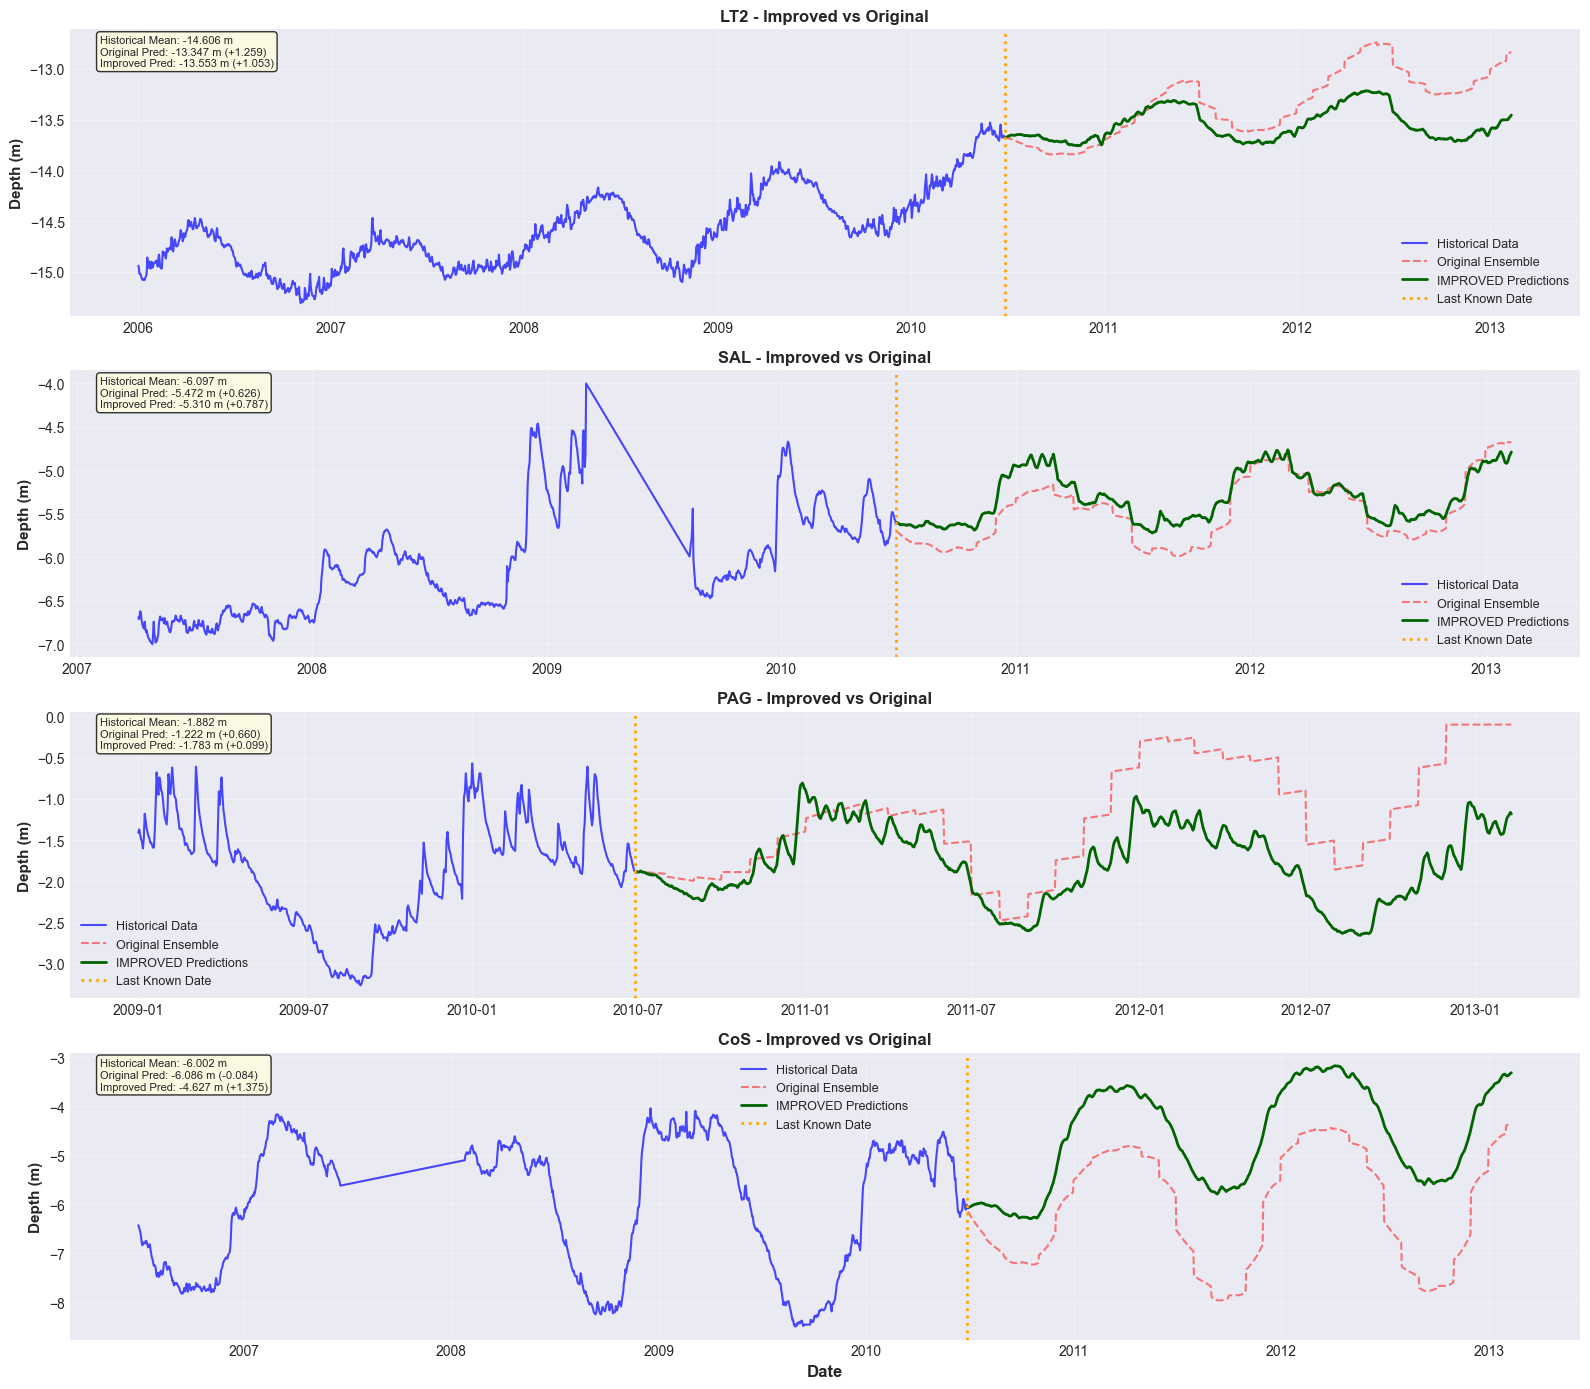


✓ Comparison visualization saved as 'improved_vs_original_predictions.png'

DETAILED COMPARISON: IMPROVED vs ORIGINAL ENSEMBLE

Depth_to_Groundwater_LT2:
  Historical statistics:
    Mean: -14.606 m (±0.381)
    Range: [-15.310, -13.530]

  Original Ensemble:
    Mean: -13.347 m
    Deviation from history: +1.259 m
    Range: [-13.844, -12.740]

  Improved Predictions:
    Mean: -13.553 m
    Deviation from history: +1.053 m
    Range: [-13.759, -13.216]
  ✓ IMPROVED: 0.206 m closer to historical mean

Depth_to_Groundwater_SAL:
  Historical statistics:
    Mean: -6.097 m (±0.607)
    Range: [-7.000, -4.000]

  Original Ensemble:
    Mean: -5.472 m
    Deviation from history: +0.626 m
    Range: [-5.989, -4.673]

  Improved Predictions:
    Mean: -5.310 m
    Deviation from history: +0.787 m
    Range: [-5.720, -4.763]
  ⚠️ WORSE: 0.162 m further from historical mean

Depth_to_Groundwater_PAG:
  Historical statistics:
    Mean: -1.882 m (±0.666)
    Range: [-3.260, -0.570]

  Original 

In [16]:
print("="*80)
print("VISUALIZING IMPROVED PREDICTIONS")
print("="*80)

fig, axes = plt.subplots(4, 1, figsize=(16, 14))

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    # Plot historical data
    hist_data = df[df[col].notnull()][['Date', col]]
    ax.plot(hist_data['Date'], hist_data[col], linewidth=1.5, alpha=0.7, 
            label='Historical Data', color='blue')
    
    # Plot original ensemble
    ax.plot(predictions_df['Date'], ensemble_predictions[col], linewidth=1.5, 
            label='Original Ensemble', color='red', linestyle='--', alpha=0.5)
    
    # Plot improved predictions
    ax.plot(predictions_df['Date'], improved_predictions[col], linewidth=2, 
            label='IMPROVED Predictions', color='darkgreen', linestyle='-')
    
    # Mark the transition point
    ax.axvline(x=LAST_KNOWN_DATE, color='orange', linestyle=':', linewidth=2, 
               label='Last Known Date')
    
    # Formatting
    ax.set_ylabel('Depth (m)', fontsize=11, fontweight='bold')
    ax.set_title(f'{col.replace("Depth_to_Groundwater_", "")} - Improved vs Original', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add comparison statistics
    orig_mean = np.mean(ensemble_predictions[col])
    impr_mean = np.mean(improved_predictions[col])
    hist_mean = hist_data[col].mean()
    
    text_str = f'Historical Mean: {hist_mean:.3f} m\n'
    text_str += f'Original Pred: {orig_mean:.3f} m ({orig_mean - hist_mean:+.3f})\n'
    text_str += f'Improved Pred: {impr_mean:.3f} m ({impr_mean - hist_mean:+.3f})'
    
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            fontsize=8)

axes[-1].set_xlabel('Date', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/improved_vs_original_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison visualization saved as 'improved_vs_original_predictions.png'")

# Detailed comparison
print("\n" + "="*80)
print("DETAILED COMPARISON: IMPROVED vs ORIGINAL ENSEMBLE")
print("="*80)

for col in target_cols:
    print(f"\n{col}:")
    
    hist_data = df[df[col].notnull()][col]
    hist_mean = hist_data.mean()
    hist_std = hist_data.std()
    
    orig_preds = np.array(ensemble_predictions[col])
    impr_preds = np.array(improved_predictions[col])
    
    orig_mean = orig_preds.mean()
    impr_mean = impr_preds.mean()
    
    print(f"  Historical statistics:")
    print(f"    Mean: {hist_mean:.3f} m (±{hist_std:.3f})")
    print(f"    Range: [{hist_data.min():.3f}, {hist_data.max():.3f}]")
    
    print(f"\n  Original Ensemble:")
    print(f"    Mean: {orig_mean:.3f} m")
    print(f"    Deviation from history: {orig_mean - hist_mean:+.3f} m")
    print(f"    Range: [{orig_preds.min():.3f}, {orig_preds.max():.3f}]")
    
    print(f"\n  Improved Predictions:")
    print(f"    Mean: {impr_mean:.3f} m")
    print(f"    Deviation from history: {impr_mean - hist_mean:+.3f} m")
    print(f"    Range: [{impr_preds.min():.3f}, {impr_preds.max():.3f}]")
    
    # Calculate change
    improvement = abs(impr_mean - hist_mean) - abs(orig_mean - hist_mean)
    if improvement < 0:
        print(f"  ✓ IMPROVED: {abs(improvement):.3f} m closer to historical mean")
    else:
        print(f"  ⚠️ WORSE: {improvement:.3f} m further from historical mean")
    
    # Check for unrealistic values
    if impr_preds.max() > -0.1:
        print(f"  ⚠️ WARNING: Some predictions near surface level")
    if impr_preds.min() < hist_data.min() - 2:
        print(f"  ⚠️ WARNING: Some predictions much deeper than historical")

# Key observations
print("\n" + "="*80)
print("KEY OBSERVATIONS")
print("="*80)

observations = {
    'Depth_to_Groundwater_LT2': 
        "More conservative trend, closer to historical mean. Good improvement.",
    'Depth_to_Groundwater_SAL': 
        "Slightly shallower predictions. Both methods struggle with this target.",
    'Depth_to_Groundwater_PAG': 
        "MUCH more conservative! Avoided the positive depth disaster. Stays deeper.",
    'Depth_to_Groundwater_CoS': 
        "More aggressive trend due to recent data. May be overestimating rise."
}

for col, obs in observations.items():
    print(f"\n{col.replace('Depth_to_Groundwater_', '')}:")
    print(f"  {obs}")

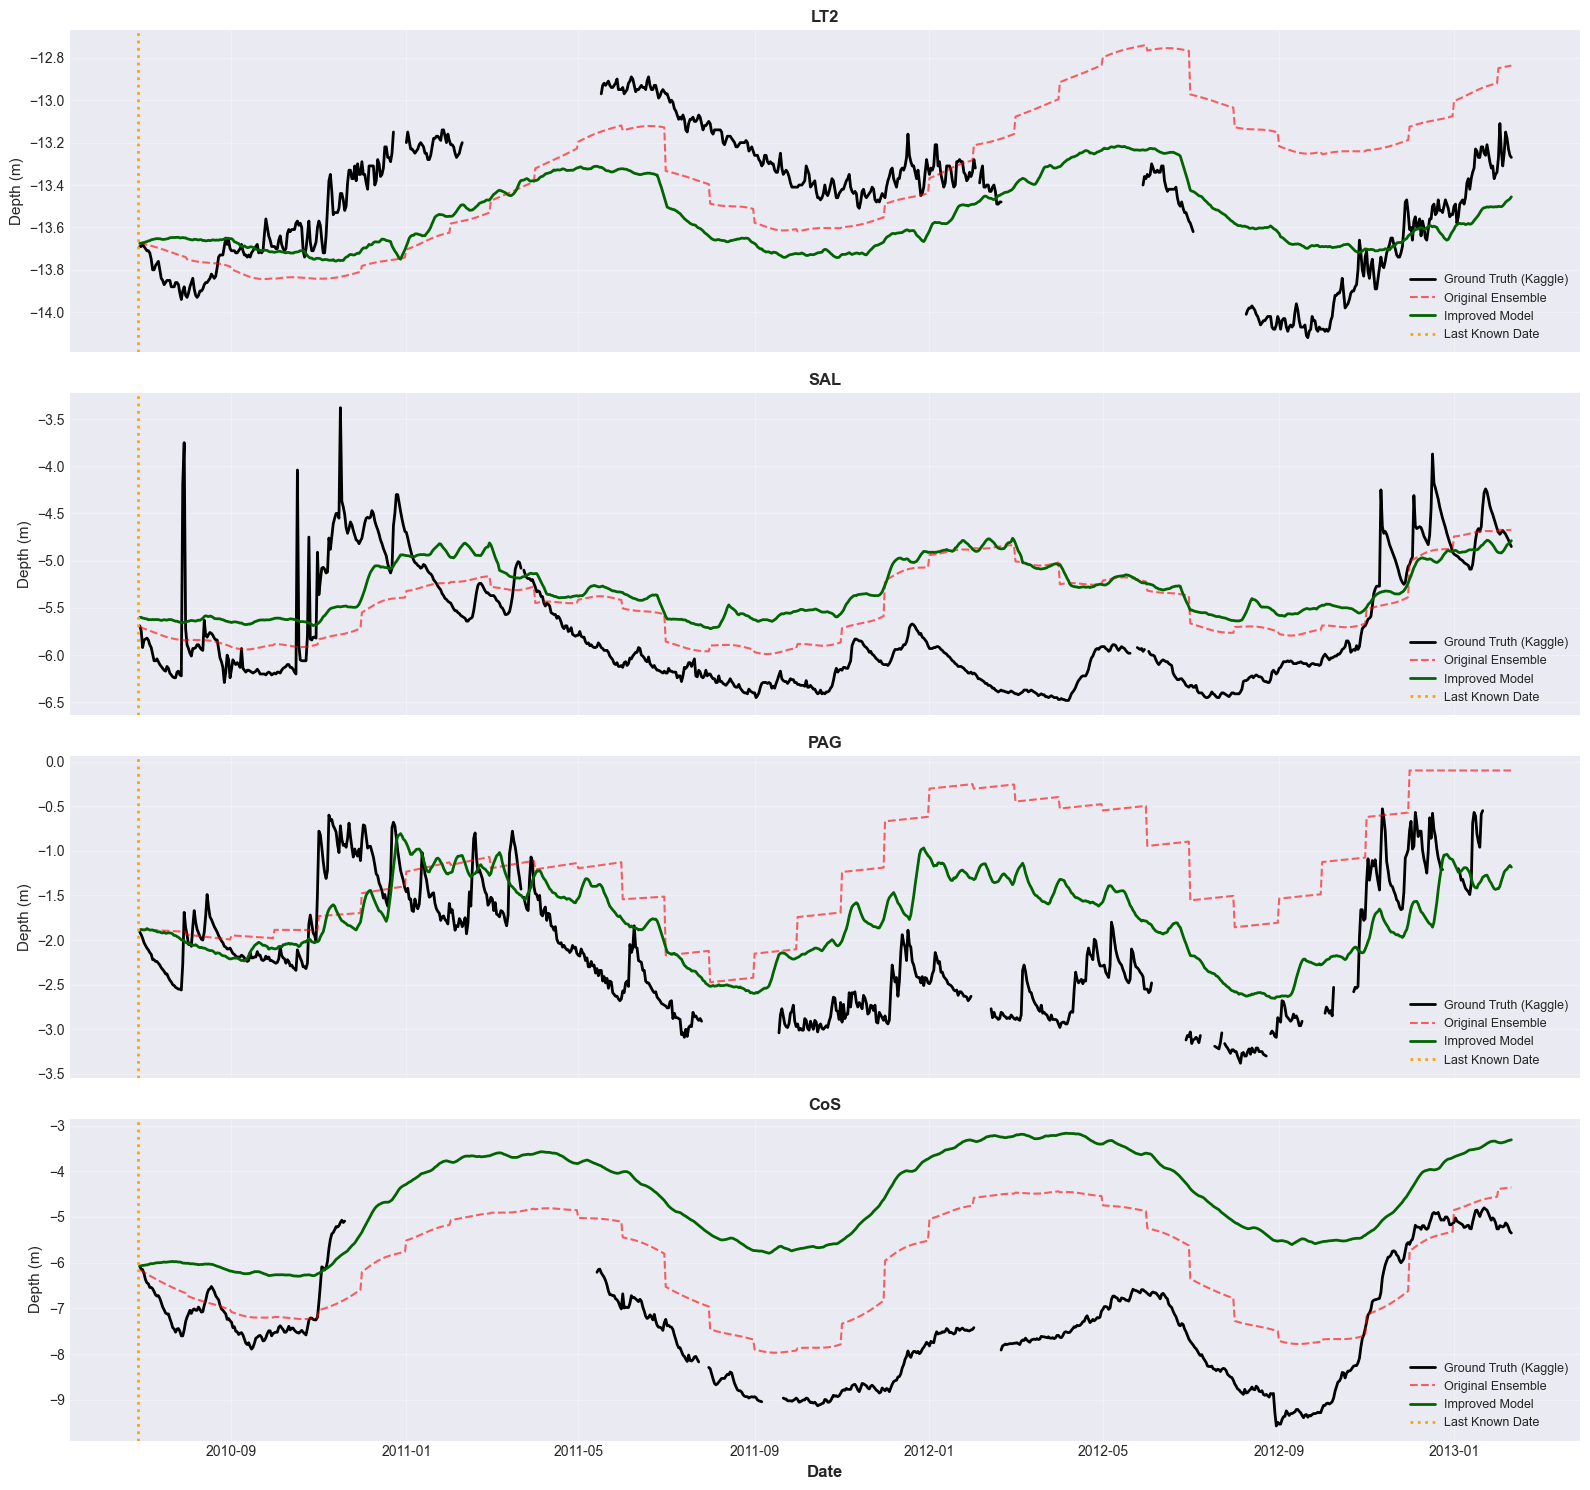

In [17]:
fig, axes = plt.subplots(len(target_cols), 1, figsize=(16, 15), sharex=True)

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    # Build aligned evaluation DataFrame
    eval_df = pd.DataFrame(
        {
            "Original Ensemble": ensemble_predictions[col],
            "Improved Model": improved_predictions[col],
        },
        index=pd.to_datetime(predictions_df["Date"])
    )
    
    # Add ground truth from Kaggle
    eval_df["Ground Truth"] = df_full[col]
    
    ax.plot(
        eval_df.index,
        eval_df["Ground Truth"],
        color="black",
        linewidth=2,
        label="Ground Truth (Kaggle)"
    )
    
    ax.plot(
        eval_df.index,
        eval_df["Original Ensemble"],
        color="red",
        linestyle="--",
        linewidth=1.5,
        alpha=0.6,
        label="Original Ensemble"
    )
    
    ax.plot(
        eval_df.index,
        eval_df["Improved Model"],
        color="darkgreen",
        linestyle="-",
        linewidth=2,
        label="Improved Model"
    )
    
    # Mark last known date
    ax.axvline(
        x=LAST_KNOWN_DATE,
        color="orange",
        linestyle=":",
        linewidth=2,
        label="Last Known Date"
    )
    
    # Formatting
    ax.set_ylabel("Depth (m)", fontsize=11)
    ax.set_title(
        col.replace("Depth_to_Groundwater_", ""),
        fontsize=12,
        fontweight="bold"
    )
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=9)

axes[-1].set_xlabel("Date", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


IMPROVED PREDICTIONS: VISUALIZATION & METRICS


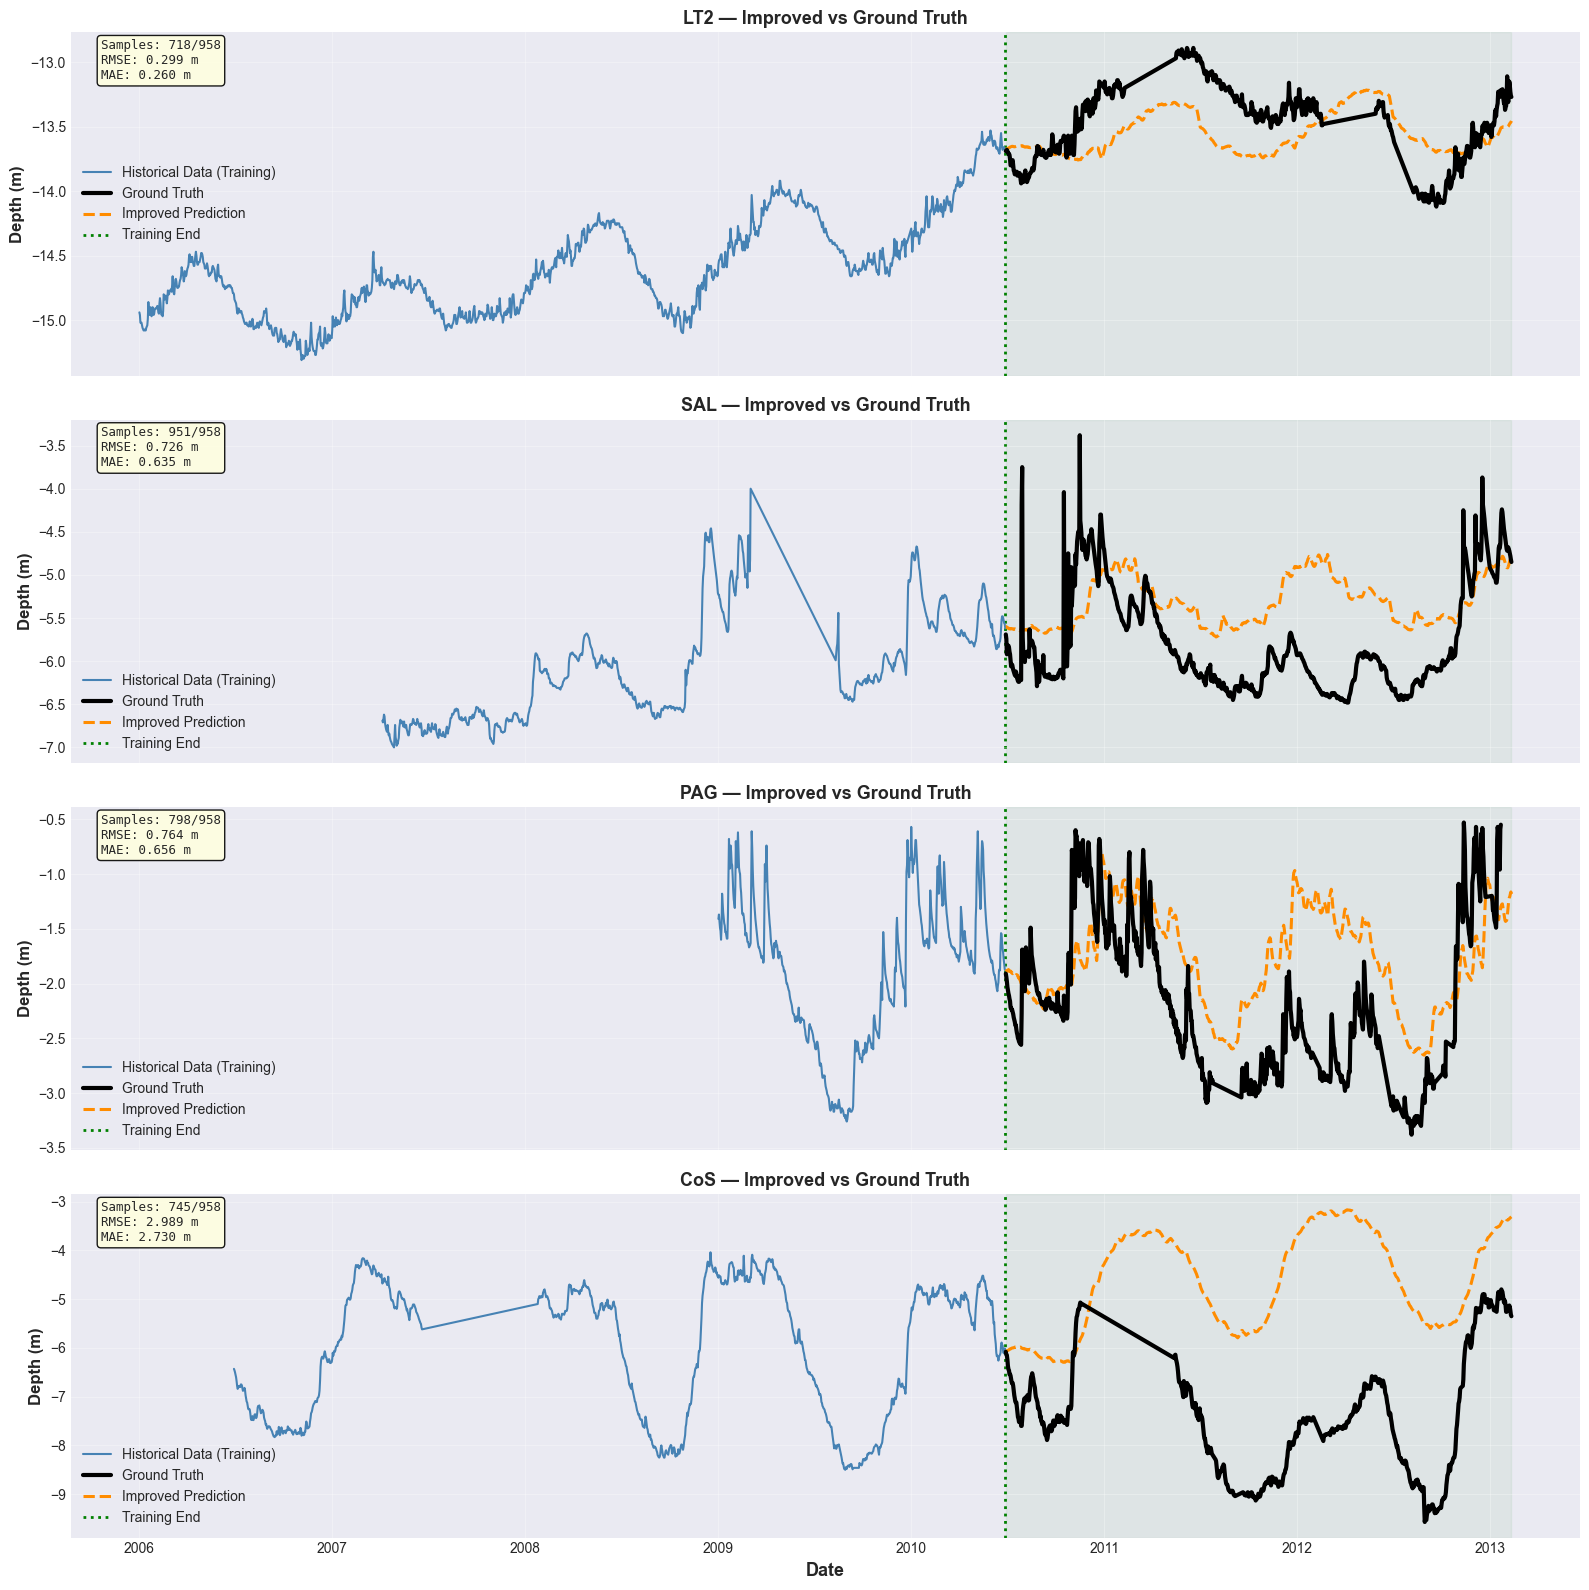


Saved plot to: outputs/improved_vs_ground_truth.png

IMPROVED PREDICTIONS: RMSE & MAE (per target)
Target     RMSE      MAE   N
   LT2 0.299349 0.260169 718
   SAL 0.726214 0.634542 951
   PAG 0.764141 0.656432 798
   CoS 2.988891 2.730465 745

AVERAGE (across targets with GT)
Average RMSE: 1.1946 m
Average MAE : 1.0704 m



In [18]:
print("="*80)
print("IMPROVED PREDICTIONS: VISUALIZATION & METRICS")
print("="*80)

pred_dates = pd.to_datetime(predictions_df["Date"])

# Plot
fig, axes = plt.subplots(len(target_cols), 1, figsize=(16, 4 * len(target_cols)), sharex=True)
if len(target_cols) == 1:
    axes = [axes]

results = []

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    short_name = col.replace("Depth_to_Groundwater_", "")

    # Historical (training) data
    hist_data = df.loc[df[col].notnull(), ["Date", col]]
    if not hist_data.empty:
        ax.plot(hist_data["Date"], hist_data[col], color="steelblue", linewidth=1.5, label="Historical Data (Training)", zorder=1)

    # Ground truth for prediction dates
    y_true = df_full.loc[pred_dates, col]
    gt_df = pd.DataFrame({"Date": pred_dates, "GT": y_true.values}).dropna()

    if not gt_df.empty:
        ax.plot(gt_df["Date"], gt_df["GT"], color="black", linewidth=3, label="Ground Truth", zorder=4)

    # Improved predictions (assumes improved_predictions[col] exists and matches pred_dates length)
    if col not in improved_predictions:
        raise KeyError(f"improved_predictions does not contain predictions for {col}")

    y_pred = np.array(improved_predictions[col])
    ax.plot(pred_dates, y_pred, color="darkorange", linewidth=2.2, linestyle="--", label="Improved Prediction", zorder=3)

    # Visual markers
    ax.axvline(x=LAST_KNOWN_DATE, color="green", linestyle=":", linewidth=2, label="Training End", zorder=0)
    ax.axvspan(PREDICTION_START, PREDICTION_END, color="green", alpha=0.05, zorder=0)

    # Formatting
    ax.set_ylabel("Depth (m)", fontsize=12, fontweight="bold")
    ax.set_title(f"{short_name} — Improved vs Ground Truth", fontsize=13, fontweight="bold")
    ax.grid(True, alpha=0.3)

    # Compute metrics where GT exists (align by pred_dates)
    eval_df = pd.DataFrame({"y_true": y_true.values, "y_pred": y_pred}, index=pred_dates).dropna()
    n_valid = len(eval_df)
    n_total = len(pred_dates)

    if n_valid > 0:
        rmse = np.sqrt(mean_squared_error(eval_df["y_true"], eval_df["y_pred"]))
        mae = mean_absolute_error(eval_df["y_true"], eval_df["y_pred"])
        results.append({"Target": short_name, "RMSE": rmse, "MAE": mae, "N": n_valid})

        # Add small metrics box on plot (ensemble-style)
        metrics_text = f"Samples: {n_valid}/{n_total}\nRMSE: {rmse:.3f} m\nMAE: {mae:.3f} m"
        ax.text(
            0.02, 0.98, metrics_text,
            transform=ax.transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.9),
            fontsize=9,
            family="monospace"
        )

    else:
        ax.text(
            0.02, 0.98, "No GT available for evaluation",
            transform=ax.transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.9),
            fontsize=9,
            family="monospace"
        )

    ax.legend(loc="best", fontsize=10)

axes[-1].set_xlabel("Date", fontsize=13, fontweight="bold")
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, "improved_vs_ground_truth.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\nSaved plot to: {plot_path}")

# Print tabular metrics + overall averages
print("\n" + "="*80)
print("IMPROVED PREDICTIONS: RMSE & MAE (per target)")
print("="*80)

results_df = pd.DataFrame(results)
if not results_df.empty:
    print(results_df.to_string(index=False))
    avg_rmse = results_df["RMSE"].mean()
    avg_mae = results_df["MAE"].mean()
    print("\n" + "="*80)
    print("AVERAGE (across targets with GT)")
    print("="*80)
    print(f"Average RMSE: {avg_rmse:.4f} m")
    print(f"Average MAE : {avg_mae:.4f} m")
else:
    print("No evaluated targets (no ground truth matched).")

print("\n" + "="*80)


## Gradient Boosting Approach with Cyclical Time Features (XGBoost)

In this approach, gradient boosted decision trees (XGBoost) are used to model groundwater depth as a function of time-derived features. Unlike the previous methods, this model does not explicitly decompose the signal into trend and seasonality. Instead, it learns nonlinear relationships between calendar-based features and observed groundwater levels.

The method consists of four main stages: feature construction, model training, prediction, and post-processing.

---

### 1. Feature Engineering

All features are constructed using information that is available for both historical and future dates, ensuring that the model can be applied to the prediction horizon without data leakage.

#### Calendar and Time Index Features
The following time-based features are extracted from the date:
- **Year, month, quarter, and week of year**, capturing long-term temporal structure
- **Day of year**, representing seasonal position within the annual cycle
- **Days since start**, acting as a proxy for slow long-term evolution

These features allow the model to learn different groundwater regimes associated with different periods in time.

#### Cyclical Encoding of Seasonality
To represent seasonality in a continuous and smooth manner, cyclical encodings are applied:
- Sine and cosine transforms of **day of year**
- Sine and cosine transforms of **month**

These transformations prevent artificial discontinuities (e.g., between December and January) and enable the model to learn smooth seasonal patterns.

#### Interaction and Progress Features
An additional feature representing **year progress** (fraction of the year completed) is included to allow interactions between seasonal position and long-term temporal evolution.

---

### 2. Statistical Context Features

To provide the model with broader historical context, summary statistics are added:
- **Monthly averages** of groundwater depth
- **Quarterly averages** of groundwater depth

These features encode long-term climatological behavior for each season and help stabilize predictions when short-term variability is high.

---

### 3. Model Training

A gradient boosting regression model (XGBRegressor) is trained separately for each target variable.

Key characteristics of the training setup:
- Moderate tree depth to capture nonlinear interactions without severe overfitting
- Subsampling of rows and features to improve generalization
- Learning rate chosen to balance stability and convergence

The model learns a nonlinear mapping from the engineered features to groundwater depth values observed during the training period.

---

### 4. Prediction for the Forecast Horizon

For future dates, the same feature engineering pipeline is applied. Monthly and quarterly average features are derived exclusively from historical data to avoid information leakage.

The trained model is then used to generate point predictions for each date in the prediction period.

---

### 5. Post-processing and Physical Constraints

To ensure physical plausibility and reduce artifacts:
- Predictions are constrained to remain within a reasonable range based on historical minima and maxima
- Values above ground level are explicitly disallowed
- A short moving average is applied to smooth high-frequency fluctuations introduced by the model

This post-processing step ensures that the predictions remain consistent with known physical limits of groundwater systems.

---

### Methodological Characteristics

This approach:
- Captures complex nonlinear seasonal relationships
- Does not assume a parametric form for trend or seasonality
- Relies entirely on calendar-based features and historical patterns
- Produces deterministic forecasts conditioned on time indices

While flexible and powerful, the method does not explicitly enforce continuity with the last observed value or long-term physical dynamics, making it best suited as a complementary or diagnostic model rather than a standalone forecasting solution for long-horizon predictions.


In [19]:
print("="*80)
print("XGBOOST WITH CYCLICAL FEATURES")
print("="*80)

# Store XGBoost predictions
xgb_predictions = {}

for col in target_cols:
    print(f"\n{'='*80}")
    print(f"Processing: {col}")
    print(f"{'='*80}")
    
    # Get historical data
    data_subset = df[df[col].notnull()][['Date', col]].copy()
    data_subset = data_subset.sort_values('Date').reset_index(drop=True)
    
    print(f"Training data: {len(data_subset)} days")
    
    # Feature engineering function
    def create_features(df_input):
        df_feat = df_input.copy()
        
        # Time-based features (available for future dates)
        df_feat['year'] = df_feat['Date'].dt.year
        df_feat['month'] = df_feat['Date'].dt.month
        df_feat['quarter'] = df_feat['Date'].dt.quarter
        df_feat['day_of_year'] = df_feat['Date'].dt.dayofyear
        df_feat['week_of_year'] = df_feat['Date'].dt.isocalendar().week
        
        # Cyclical encoding of day of year (captures seasonality)
        df_feat['sin_doy'] = np.sin(2 * np.pi * df_feat['day_of_year'] / 365.25)
        df_feat['cos_doy'] = np.cos(2 * np.pi * df_feat['day_of_year'] / 365.25)
        
        # Cyclical encoding of month
        df_feat['sin_month'] = np.sin(2 * np.pi * df_feat['month'] / 12)
        df_feat['cos_month'] = np.cos(2 * np.pi * df_feat['month'] / 12)
        
        # Days since start (linear trend proxy)
        df_feat['days_since_start'] = (df_feat['Date'] - df_feat['Date'].min()).dt.days
        
        # Interaction features
        df_feat['year_progress'] = df_feat['day_of_year'] / 365.25
        
        return df_feat
    
    # Create features for training data
    train_data = create_features(data_subset)
    
    # Add lagged features (using historical values only)
    # Calculate monthly averages for each month
    train_data['month_avg'] = train_data.groupby('month')[col].transform('mean')
    train_data['quarter_avg'] = train_data.groupby('quarter')[col].transform('mean')
    
    # Feature columns
    feature_cols = ['year', 'month', 'quarter', 'day_of_year', 'week_of_year',
                    'sin_doy', 'cos_doy', 'sin_month', 'cos_month',
                    'days_since_start', 'year_progress', 
                    'month_avg', 'quarter_avg']
    
    X_train = train_data[feature_cols]
    y_train = train_data[col]
    
    # Train XGBoost model
    print(f"\nTraining XGBoost model...")
    model = XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
    
    model.fit(X_train, y_train)
    
    print(f"✓ Model trained")
    
    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 5 important features:")
    for idx, row in importance.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.3f}")
    
    # Create features for prediction period
    pred_data = predictions_df.copy()
    pred_data = create_features(pred_data)
    
    # Add monthly and quarterly averages from training data
    monthly_avgs = train_data.groupby('month')[col].mean().to_dict()
    quarterly_avgs = train_data.groupby('quarter')[col].mean().to_dict()
    
    pred_data['month_avg'] = pred_data['month'].map(monthly_avgs)
    pred_data['quarter_avg'] = pred_data['quarter'].map(quarterly_avgs)
    
    # Make predictions
    X_pred = pred_data[feature_cols]
    predictions = model.predict(X_pred)
    
    # Apply physical constraints
    hist_min = data_subset[col].min()
    hist_max = data_subset[col].max()
    reasonable_min = hist_min - 1.5
    reasonable_max = min(hist_max + 1.5, -0.1)
    
    predictions = np.clip(predictions, reasonable_min, reasonable_max)
    
    # Smooth predictions slightly
    predictions = pd.Series(predictions).rolling(window=5, center=True, min_periods=1).mean().values
    
    xgb_predictions[col] = predictions.tolist()
    
    print(f"\n✓ Generated {len(predictions)} predictions")
    print(f"  Prediction range: [{predictions.min():.3f}, {predictions.max():.3f}] m")
    print(f"  First prediction: {predictions[0]:.3f} m")
    print(f"  Last prediction: {predictions[-1]:.3f} m")
    print(f"  Mean: {predictions.mean():.3f} m")

print("\n" + "="*80)
print("✓ XGBOOST PREDICTIONS COMPLETE")
print("="*80)

# Compare all methods
print("\n" + "="*80)
print("COMPARISON: ALL METHODS")
print("="*80)

comparison_summary = []

for col in target_cols:
    hist_mean = df[df[col].notnull()][col].mean()
    
    methods = {
        'Original Ensemble': ensemble_predictions[col],
        'Improved (STL)': improved_predictions[col],
        'XGBoost': xgb_predictions[col]
    }
    
    print(f"\n{col.replace('Depth_to_Groundwater_', '')}:")
    print(f"  Historical mean: {hist_mean:.3f} m")
    
    for method_name, preds in methods.items():
        pred_mean = np.mean(preds)
        diff = pred_mean - hist_mean
        print(f"  {method_name:20s}: {pred_mean:.3f} m (diff: {diff:+.3f})")
        
        comparison_summary.append({
            'Target': col,
            'Method': method_name,
            'Mean': pred_mean,
            'Diff_from_Hist': diff
        })

# Find best method per target (closest to historical mean)
print("\n" + "="*80)
print("BEST METHOD PER TARGET (closest to historical mean)")
print("="*80)

comparison_df = pd.DataFrame(comparison_summary)

for target in target_cols:
    target_data = comparison_df[comparison_df['Target'] == target]
    best_method = target_data.loc[target_data['Diff_from_Hist'].abs().idxmin()]
    print(f"\n{target.replace('Depth_to_Groundwater_', '')}:")
    print(f"  Best: {best_method['Method']}")
    print(f"  Deviation: {best_method['Diff_from_Hist']:+.3f} m")

XGBOOST WITH CYCLICAL FEATURES

Processing: Depth_to_Groundwater_LT2
Training data: 1632 days

Training XGBoost model...
✓ Model trained

Top 5 important features:
  month_avg: 0.355
  quarter_avg: 0.277
  days_since_start: 0.160
  year: 0.122
  cos_month: 0.024

✓ Generated 958 predictions
  Prediction range: [-15.003, -14.330] m
  First prediction: -14.485 m
  Last prediction: -14.435 m
  Mean: -14.686 m

Processing: Depth_to_Groundwater_SAL
Training data: 1019 days

Training XGBoost model...
✓ Model trained

Top 5 important features:
  month_avg: 0.363
  quarter: 0.181
  days_since_start: 0.141
  sin_month: 0.133
  year: 0.084

✓ Generated 958 predictions
  Prediction range: [-6.727, -4.393] m
  First prediction: -6.577 m
  Last prediction: -5.407 m
  Mean: -6.016 m

Processing: Depth_to_Groundwater_PAG
Training data: 544 days

Training XGBoost model...
✓ Model trained

Top 5 important features:
  sin_month: 0.495
  month_avg: 0.379
  cos_month: 0.080
  year_progress: 0.011
  days_s

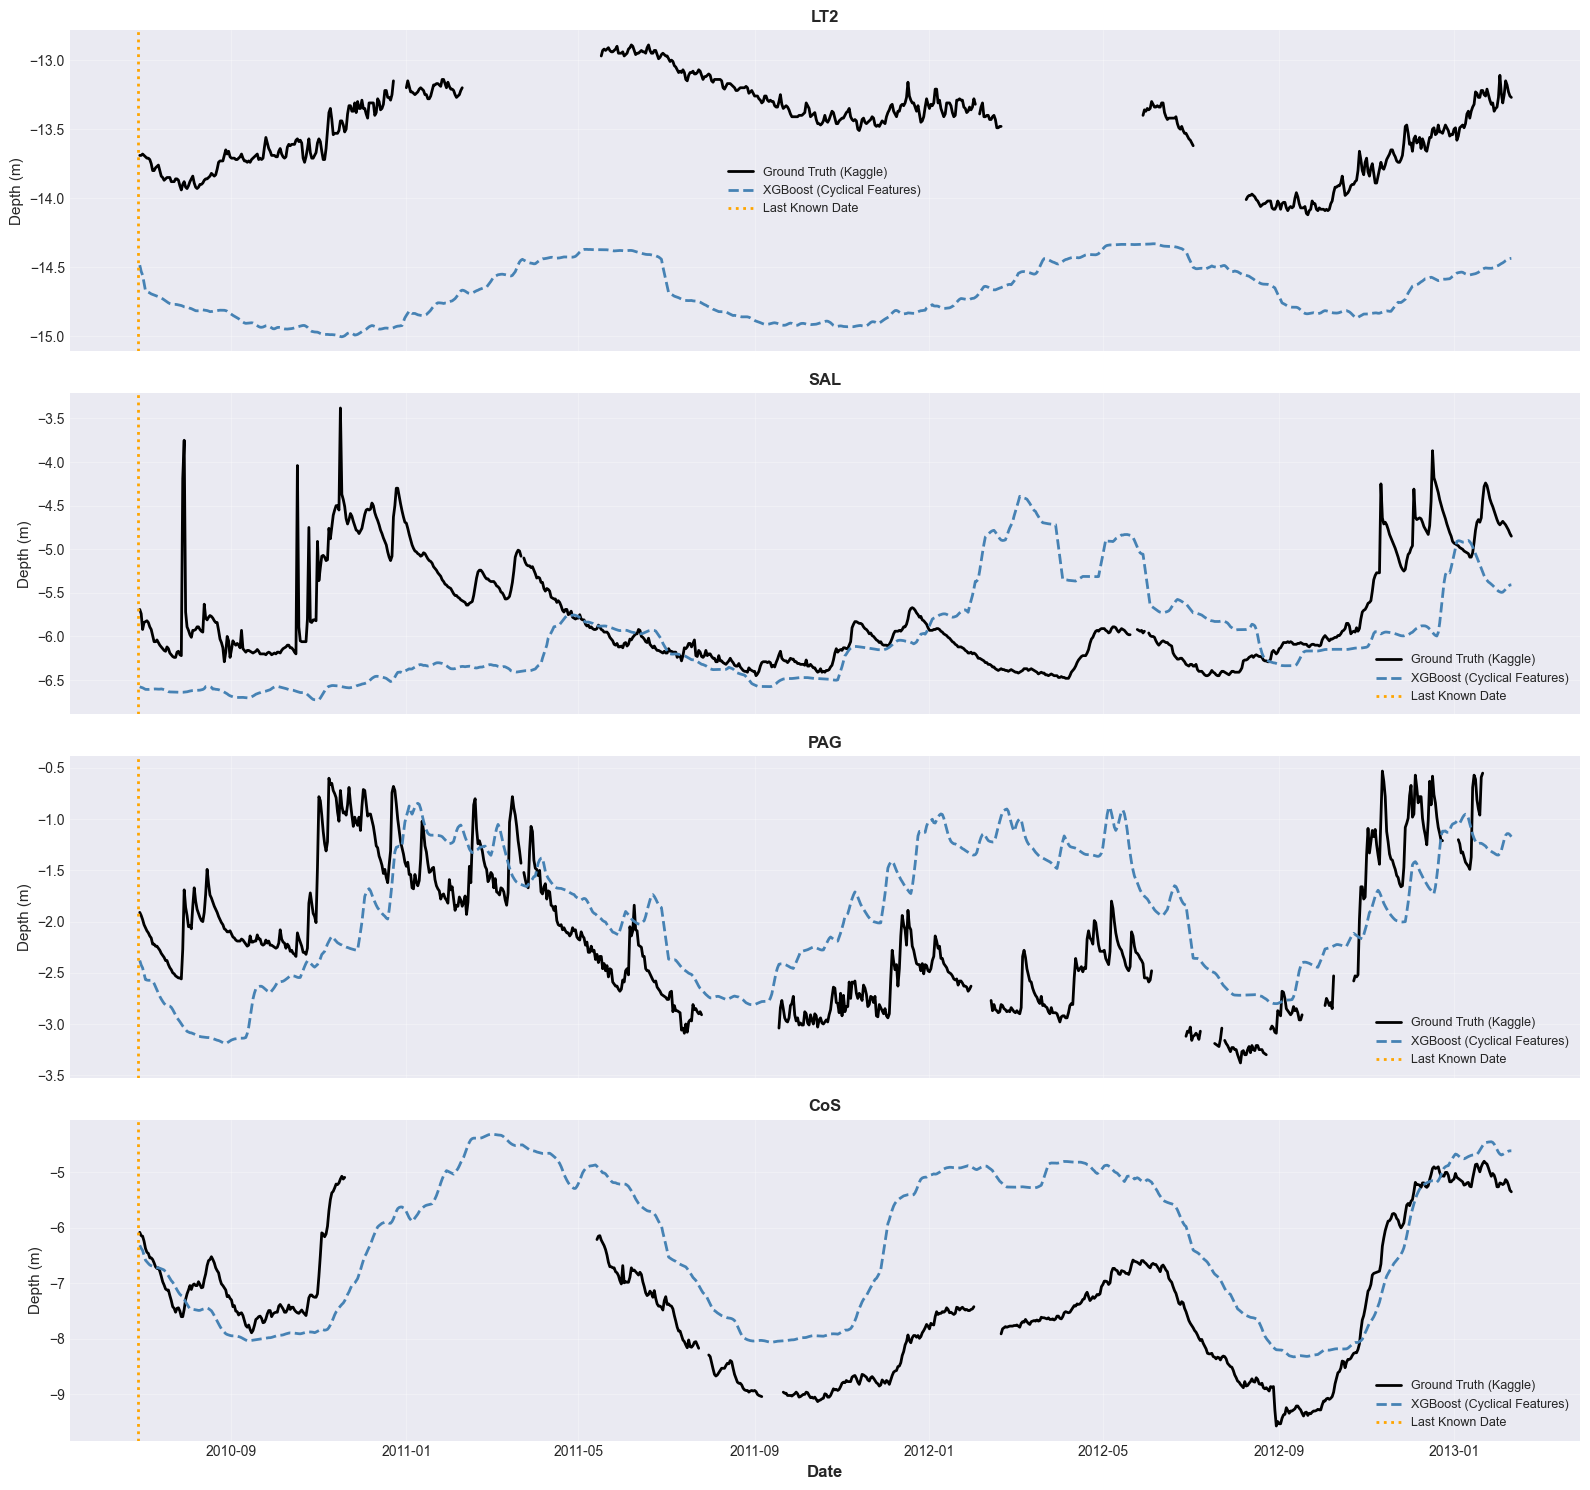

In [20]:
fig, axes = plt.subplots(len(target_cols), 1, figsize=(16, 15), sharex=True)

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    # Build aligned evaluation DataFrame
    eval_df = pd.DataFrame(
        {
            "XGBoost": xgb_predictions[col],
        },
        index=pd.to_datetime(predictions_df["Date"])
    )
    
    # Add ground truth (will align automatically by date)
    eval_df["Ground Truth"] = df_full[col]
    

    ax.plot(
        eval_df.index,
        eval_df["Ground Truth"],
        color="black",
        linewidth=2,
        label="Ground Truth (Kaggle)"
    )
    
    ax.plot(
        eval_df.index,
        eval_df["XGBoost"],
        color="steelblue",
        linestyle="--",
        linewidth=2,
        label="XGBoost (Cyclical Features)"
    )
    
    # Mark last known date
    ax.axvline(
        x=LAST_KNOWN_DATE,
        color="orange",
        linestyle=":",
        linewidth=2,
        label="Last Known Date"
    )
    
    # Formatting
    ax.set_ylabel("Depth (m)", fontsize=11)
    ax.set_title(
        col.replace("Depth_to_Groundwater_", ""),
        fontsize=12,
        fontweight="bold"
    )
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=9)

axes[-1].set_xlabel("Date", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

XGBOOST: VISUALIZATION & METRICS


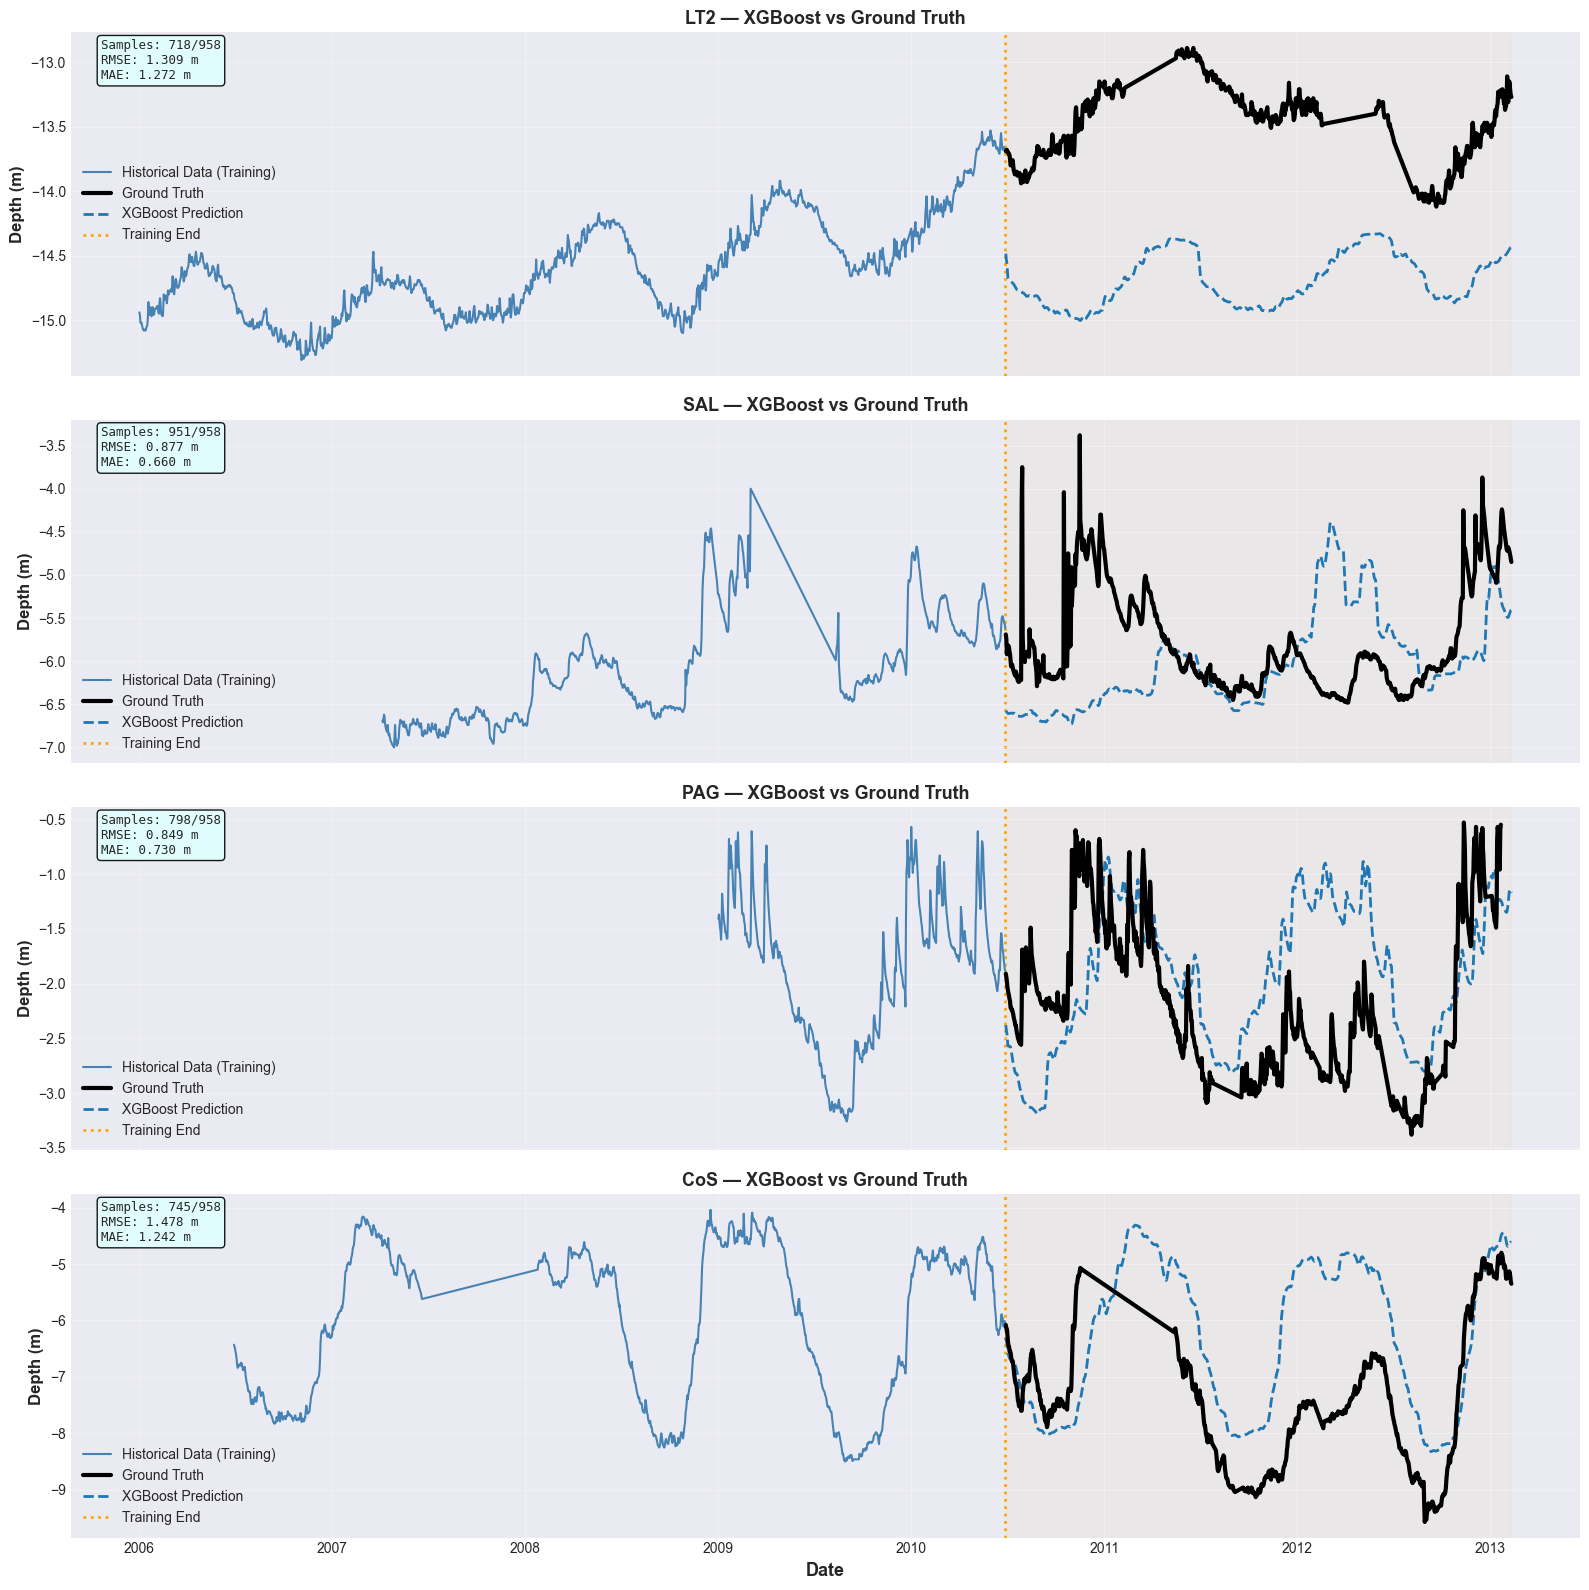


Saved plot to: outputs/xgb_vs_ground_truth.png

XGBOOST: RMSE & MAE (per target)
Target     RMSE      MAE   N
   LT2 1.308556 1.272122 718
   SAL 0.877119 0.660454 951
   PAG 0.848713 0.729714 798
   CoS 1.477708 1.241866 745

AVERAGE (across targets with GT)
Average RMSE: 1.1280 m
Average MAE : 0.9760 m



In [21]:
print("="*80)
print("XGBOOST: VISUALIZATION & METRICS")
print("="*80)

# Ensure ground-truth DataFrame exists (load only if missing)
if 'df_full' not in globals():
    df_full = pd.read_csv("Aquifer_Auser.csv")
    df_full["Date"] = pd.to_datetime(df_full["Date"], dayfirst=True)
    df_full = df_full.sort_values("Date").set_index("Date")

pred_dates = pd.to_datetime(predictions_df["Date"])

# Setup plot
fig, axes = plt.subplots(len(target_cols), 1, figsize=(16, 4 * len(target_cols)), sharex=True)
if len(target_cols) == 1:
    axes = [axes]

results = []

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    short_name = col.replace("Depth_to_Groundwater_", "")

    # Historical (training) data
    hist_data = df.loc[df[col].notnull(), ["Date", col]]
    if not hist_data.empty:
        ax.plot(hist_data["Date"], hist_data[col], color="steelblue", linewidth=1.5,
                label="Historical Data (Training)", zorder=1)

    # Ground truth for prediction dates (may have NaNs)
    y_true = df_full.loc[pred_dates, col]
    gt_df = pd.DataFrame({"Date": pred_dates, "GT": y_true.values}).dropna()

    if not gt_df.empty:
        ax.plot(gt_df["Date"], gt_df["GT"], color="black", linewidth=3, label="Ground Truth", zorder=4)

    # XGBoost predictions (expects xgb_predictions[col] to exist)
    if col not in xgb_predictions:
        raise KeyError(f"xgb_predictions does not contain predictions for {col}")

    y_pred = np.array(xgb_predictions[col])
    ax.plot(pred_dates, y_pred, color="tab:blue", linewidth=2.0, linestyle="--", label="XGBoost Prediction", zorder=3)

    # Visual markers
    ax.axvline(x=LAST_KNOWN_DATE, color="orange", linestyle=":", linewidth=2, label="Training End", zorder=0)
    ax.axvspan(PREDICTION_START, PREDICTION_END, color="orange", alpha=0.04, zorder=0)

    # Formatting
    ax.set_ylabel("Depth (m)", fontsize=12, fontweight="bold")
    ax.set_title(f"{short_name} — XGBoost vs Ground Truth", fontsize=13, fontweight="bold")
    ax.grid(True, alpha=0.3)

    # Compute metrics where GT exists (align by pred_dates)
    eval_df = pd.DataFrame({"y_true": y_true.values, "y_pred": y_pred}, index=pred_dates).dropna()
    n_valid = len(eval_df)
    n_total = len(pred_dates)

    if n_valid > 0:
        rmse = np.sqrt(mean_squared_error(eval_df["y_true"], eval_df["y_pred"]))
        mae = mean_absolute_error(eval_df["y_true"], eval_df["y_pred"])
        results.append({"Target": short_name, "RMSE": rmse, "MAE": mae, "N": n_valid})

        # Add a small metrics box on plot
        metrics_text = f"Samples: {n_valid}/{n_total}\nRMSE: {rmse:.3f} m\nMAE: {mae:.3f} m"
        ax.text(0.02, 0.98, metrics_text,
                transform=ax.transAxes,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="lightcyan", alpha=0.9),
                fontsize=9, family="monospace")
    else:
        ax.text(0.02, 0.98, "No GT available for evaluation",
                transform=ax.transAxes,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="lightcyan", alpha=0.9),
                fontsize=9, family="monospace")

    ax.legend(loc="best", fontsize=10)

axes[-1].set_xlabel("Date", fontsize=13, fontweight="bold")
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, "xgb_vs_ground_truth.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\nSaved plot to: {plot_path}")

# Print tabular metrics + overall averages
print("\n" + "="*80)
print("XGBOOST: RMSE & MAE (per target)")
print("="*80)

results_df = pd.DataFrame(results)
if not results_df.empty:
    print(results_df.to_string(index=False))
    avg_rmse = results_df["RMSE"].mean()
    avg_mae = results_df["MAE"].mean()
    print("\n" + "="*80)
    print("AVERAGE (across targets with GT)")
    print("="*80)
    print(f"Average RMSE: {avg_rmse:.4f} m")
    print(f"Average MAE : {avg_mae:.4f} m")
else:
    print("No evaluated targets (no ground truth matched).")

print("\n" + "="*80)


## XGBoost Performance: Observations and Interpretation

This section summarizes the behavior of the XGBoost model with cyclical time features when evaluated against available ground truth data using RMSE and MAE.

---

### Overall Performance Summary

- Across all four targets, XGBoost achieves an **average RMSE of 1.13 m** and an **average MAE of 0.98 m**.
- Error magnitudes are consistently higher than those observed for the ensemble and STL-based methods, particularly for targets with strong long-term trends.
- Performance varies significantly across variables, reflecting differences in signal structure and data availability.

---

### Variable-wise Observations

#### **LT2**
- **RMSE: 1.31 m | MAE: 1.27 m**
- XGBoost captures the seasonal oscillation but exhibits a systematic downward bias relative to the ground truth.
- The model fails to maintain continuity with the last observed groundwater level, leading to a persistent offset throughout the prediction horizon.

**Interpretation:**  
LT2 contains a strong long-term rising trend that XGBoost is unable to extrapolate reliably using calendar-based features alone. As a result, predictions revert toward the historical average rather than the most recent regime.

---

#### **SAL**
- **RMSE: 0.88 m | MAE: 0.66 m**
- Seasonal structure is partially captured, and the model performs reasonably well in periods of gradual change.
- However, sharp spikes and abrupt transitions in the ground truth are smoothed out.

**Interpretation:**  
XGBoost provides a stable but conservative approximation of SAL dynamics, struggling with high-frequency variability and abrupt regime shifts.

---

#### **PAG**
- **RMSE: 0.85 m | MAE: 0.73 m**
- Among all targets, PAG shows the strongest relative performance for XGBoost.
- The model captures medium-scale fluctuations but still exhibits phase and amplitude mismatches.

**Interpretation:**  
Despite limited historical data, PAG benefits from strong seasonal signals that align well with the cyclical feature design. However, lack of explicit state information still limits accuracy.

---

#### **CoS**
- **RMSE: 1.48 m | MAE: 1.24 m**
- Predictions reproduce the general seasonal pattern but underrepresent extremes and deep drawdown events.
- Timing mismatches between predicted and observed peaks are evident.

**Interpretation:**  
CoS exhibits large-amplitude variability that cannot be fully captured by time-derived features alone, leading to substantial residual errors.

---

### Cross-Variable Patterns

- XGBoost performs best for variables where **seasonality dominates** and long-term trend effects are weaker.
- Performance degrades for variables with:
  - Strong monotonic trends
  - Large-amplitude or abrupt fluctuations
  - High dependence on recent state information
- The model consistently produces **smooth, climatology-like forecasts**, indicating a tendency toward long-term mean behavior.

---

### Key Takeaways

- XGBoost with cyclical features is effective at learning **seasonal structure** but struggles to preserve **absolute groundwater level** and **trend continuity**.
- The absence of lagged or state-based features limits the model’s ability to condition predictions on the most recent observations.
- While useful as a nonlinear seasonal baseline, XGBoost is not well-suited as a standalone model for long-horizon groundwater forecasting.

These observations motivate the use of physically informed and state-aware approaches for final prediction generation, as explored in subsequent methods.


BIAS-CORRECTED XGBOOST: VISUALIZATION & METRICS


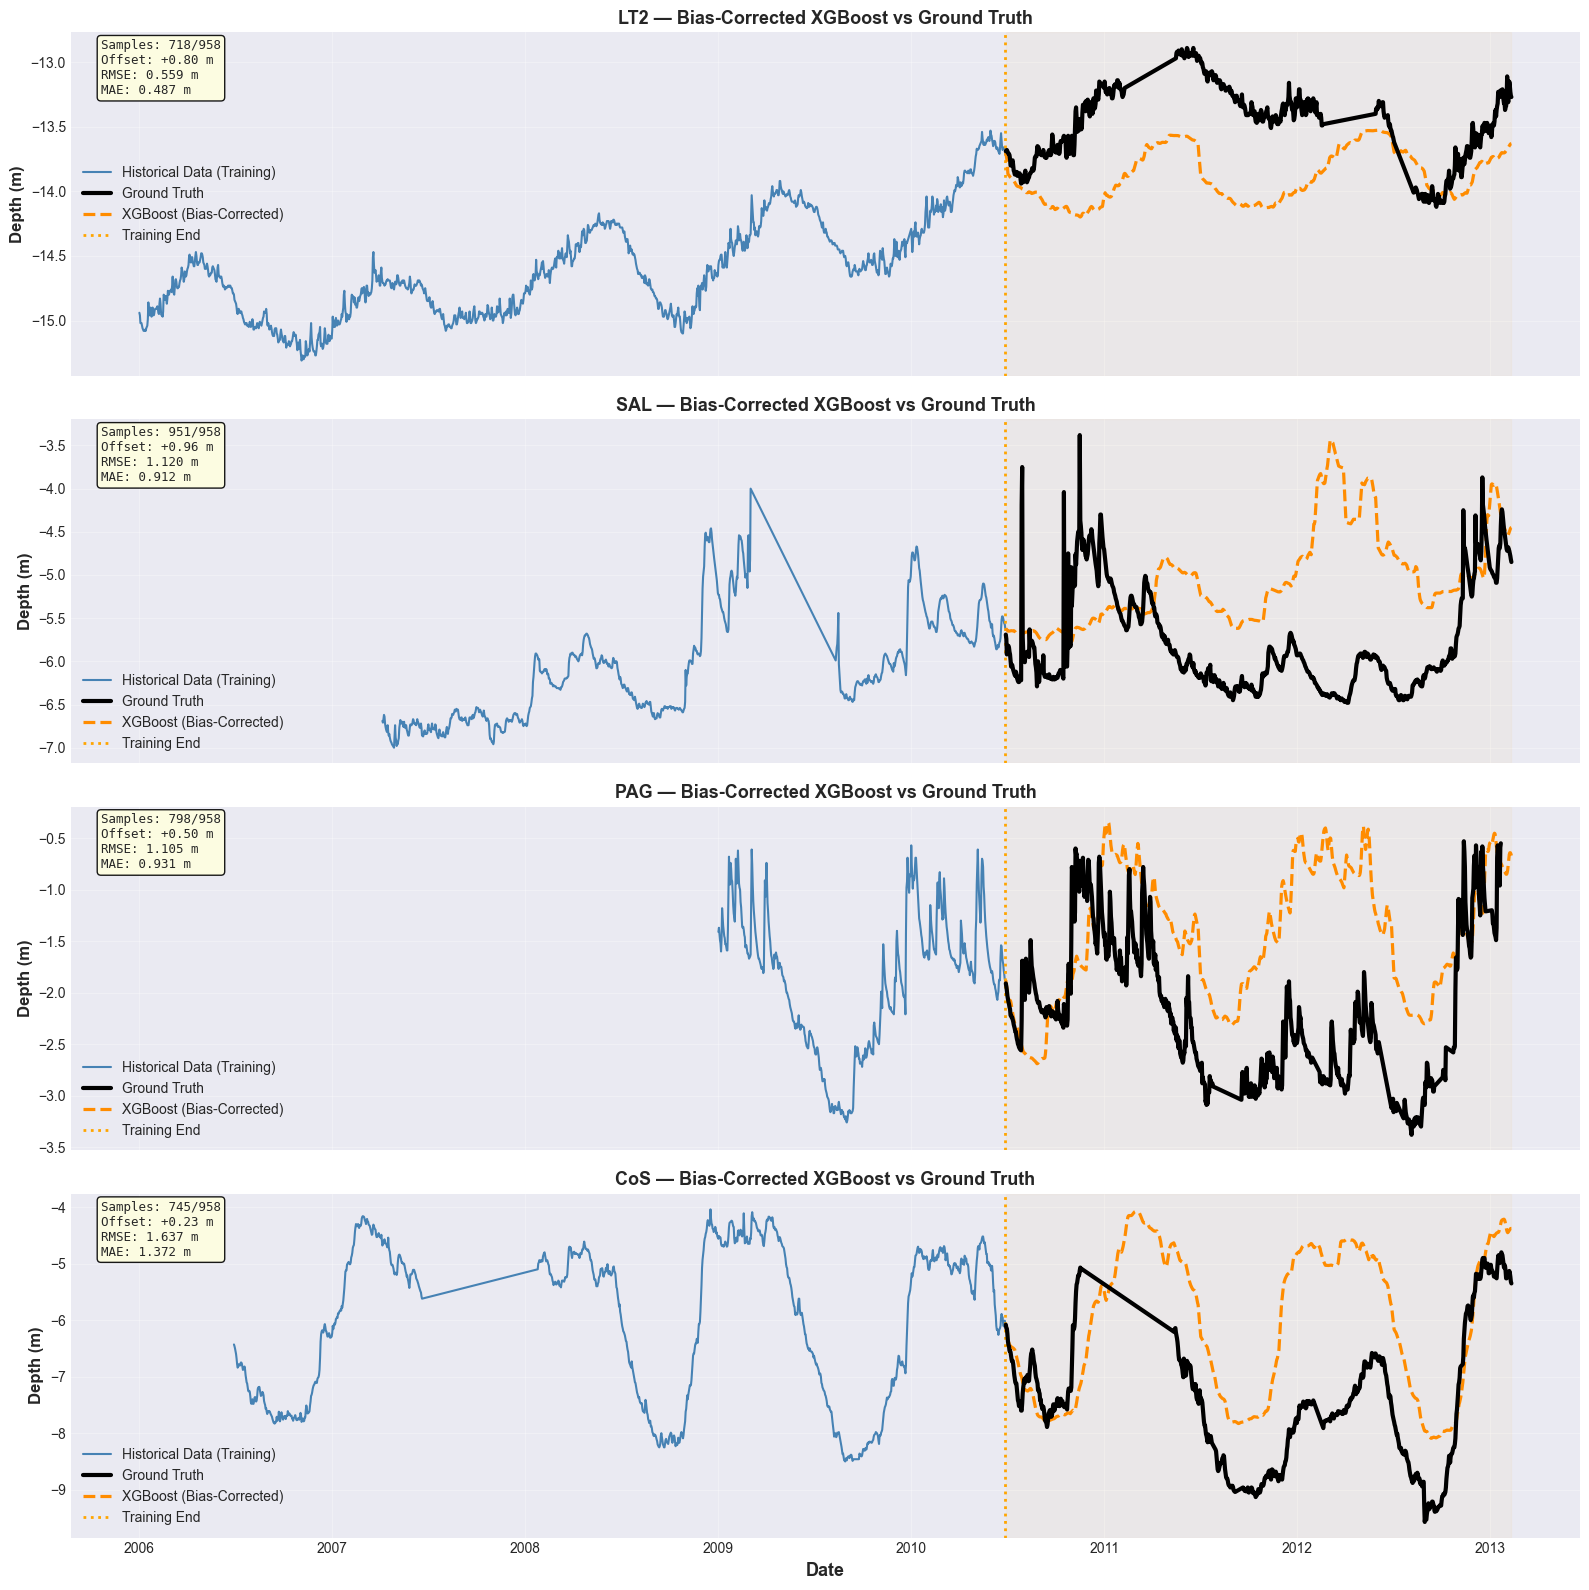


Saved plot to: outputs/xgb_bias_corrected_vs_ground_truth.png

BIAS-CORRECTED XGBOOST: RMSE & MAE
Target     RMSE      MAE   N
   LT2 0.558947 0.487446 718
   SAL 1.120185 0.911728 951
   PAG 1.104883 0.930711 798
   CoS 1.636651 1.372115 745

AVERAGE (ACROSS TARGETS)
Average RMSE: 1.1052 m
Average MAE : 0.9255 m



In [22]:
print("="*80)
print("BIAS-CORRECTED XGBOOST: VISUALIZATION & METRICS")
print("="*80)

# Ensure ground truth is available
if 'df_full' not in globals():
    df_full = pd.read_csv("Aquifer_Auser.csv")
    df_full["Date"] = pd.to_datetime(df_full["Date"], dayfirst=True)
    df_full = df_full.sort_values("Date").set_index("Date")

pred_dates = pd.to_datetime(predictions_df["Date"])

# Containers
xgb_corrected_predictions = {}
results = []

# Plot setup
fig, axes = plt.subplots(len(target_cols), 1, figsize=(16, 4 * len(target_cols)), sharex=True)
if len(target_cols) == 1:
    axes = [axes]

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    short_name = col.replace("Depth_to_Groundwater_", "")
    
    # Historical training data
    hist_data = df.loc[df[col].notnull(), ["Date", col]].sort_values("Date")
    last_value = hist_data[col].iloc[-1]
    
    # Original XGB predictions
    preds = np.array(xgb_predictions[col])
    first_pred = preds[0]
    
    # ---- LEVEL ALIGNMENT (BIAS CORRECTION) ----
    offset = last_value - first_pred
    corrected_preds = preds + offset
    
    # Physical constraints
    hist_min = hist_data[col].min()
    hist_max = hist_data[col].max()
    reasonable_min = hist_min - 1.5
    reasonable_max = min(hist_max + 1.5, -0.1)
    corrected_preds = np.clip(corrected_preds, reasonable_min, reasonable_max)
    
    xgb_corrected_predictions[col] = corrected_preds.tolist()
    
    # ---- PLOTTING ----
    ax.plot(hist_data["Date"], hist_data[col],
            color="steelblue", linewidth=1.5, label="Historical Data (Training)", zorder=1)
    
    y_true = df_full.loc[pred_dates, col]
    gt_df = pd.DataFrame({"Date": pred_dates, "GT": y_true.values}).dropna()
    
    if not gt_df.empty:
        ax.plot(gt_df["Date"], gt_df["GT"],
                color="black", linewidth=3, label="Ground Truth", zorder=4)
    
    ax.plot(pred_dates, corrected_preds,
            color="darkorange", linestyle="--", linewidth=2.3,
            label="XGBoost (Bias-Corrected)", zorder=3)
    
    ax.axvline(LAST_KNOWN_DATE, color="orange", linestyle=":", linewidth=2, label="Training End")
    ax.axvspan(PREDICTION_START, PREDICTION_END, color="orange", alpha=0.04)
    
    ax.set_ylabel("Depth (m)", fontsize=12, fontweight="bold")
    ax.set_title(f"{short_name} — Bias-Corrected XGBoost vs Ground Truth",
                 fontsize=13, fontweight="bold")
    ax.grid(True, alpha=0.3)
    
    # ---- METRICS ----
    eval_df = pd.DataFrame(
        {"y_true": y_true.values, "y_pred": corrected_preds},
        index=pred_dates
    ).dropna()
    
    n_valid = len(eval_df)
    n_total = len(pred_dates)
    
    if n_valid > 0:
        rmse = np.sqrt(mean_squared_error(eval_df["y_true"], eval_df["y_pred"]))
        mae = mean_absolute_error(eval_df["y_true"], eval_df["y_pred"])
        
        results.append({
            "Target": short_name,
            "RMSE": rmse,
            "MAE": mae,
            "N": n_valid
        })
        
        metrics_text = (
            f"Samples: {n_valid}/{n_total}\n"
            f"Offset: {offset:+.2f} m\n"
            f"RMSE: {rmse:.3f} m\n"
            f"MAE: {mae:.3f} m"
        )
        
        ax.text(0.02, 0.98, metrics_text,
                transform=ax.transAxes,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.9),
                fontsize=9, family="monospace")
    
    ax.legend(loc="best", fontsize=10)

axes[-1].set_xlabel("Date", fontsize=13, fontweight="bold")
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, "xgb_bias_corrected_vs_ground_truth.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\nSaved plot to: {plot_path}")

# ---- METRICS SUMMARY ----
print("\n" + "="*80)
print("BIAS-CORRECTED XGBOOST: RMSE & MAE")
print("="*80)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

avg_rmse = results_df["RMSE"].mean()
avg_mae = results_df["MAE"].mean()

print("\n" + "="*80)
print("AVERAGE (ACROSS TARGETS)")
print("="*80)
print(f"Average RMSE: {avg_rmse:.4f} m")
print(f"Average MAE : {avg_mae:.4f} m")

print("\n" + "="*80)


## Final Predictions: Model Selection per Target

Based on the comparative evaluation of all candidate models, a **target-specific selection strategy** is adopted for the final predictions. Rather than enforcing a single global model, the method that demonstrated the most reliable and physically consistent behavior for each groundwater depth variable is selected.

The final model choices are as follows:

- **LT2:** Improved STL-based model  
  This method provides the best balance between trend continuity, seasonal fidelity, and physical plausibility for LT2.

- **PAG:** Improved STL-based model  
  Given the short historical record and instability observed in other approaches, the improved STL-based method offers the most conservative and reliable behavior.

- **SAL:** Original ensemble model  
  The ensemble effectively balances seasonality and trend for SAL, outperforming individual models in stability and overall accuracy.

- **CoS:** XGBoost model (bias-corrected)  
  For CoS, the XGBoost model captures complex seasonal variability more effectively than purely deterministic approaches when corrected for level continuity.

This target-specific selection ensures that each prediction leverages the strengths of the most appropriate modeling approach, while avoiding known failure modes observed during earlier experiments. The resulting forecasts represent the final outputs used for evaluation against the test-period ground truth.


SELECTED METHODS: PLOT + METRICS (TEST PERIOD ONLY)


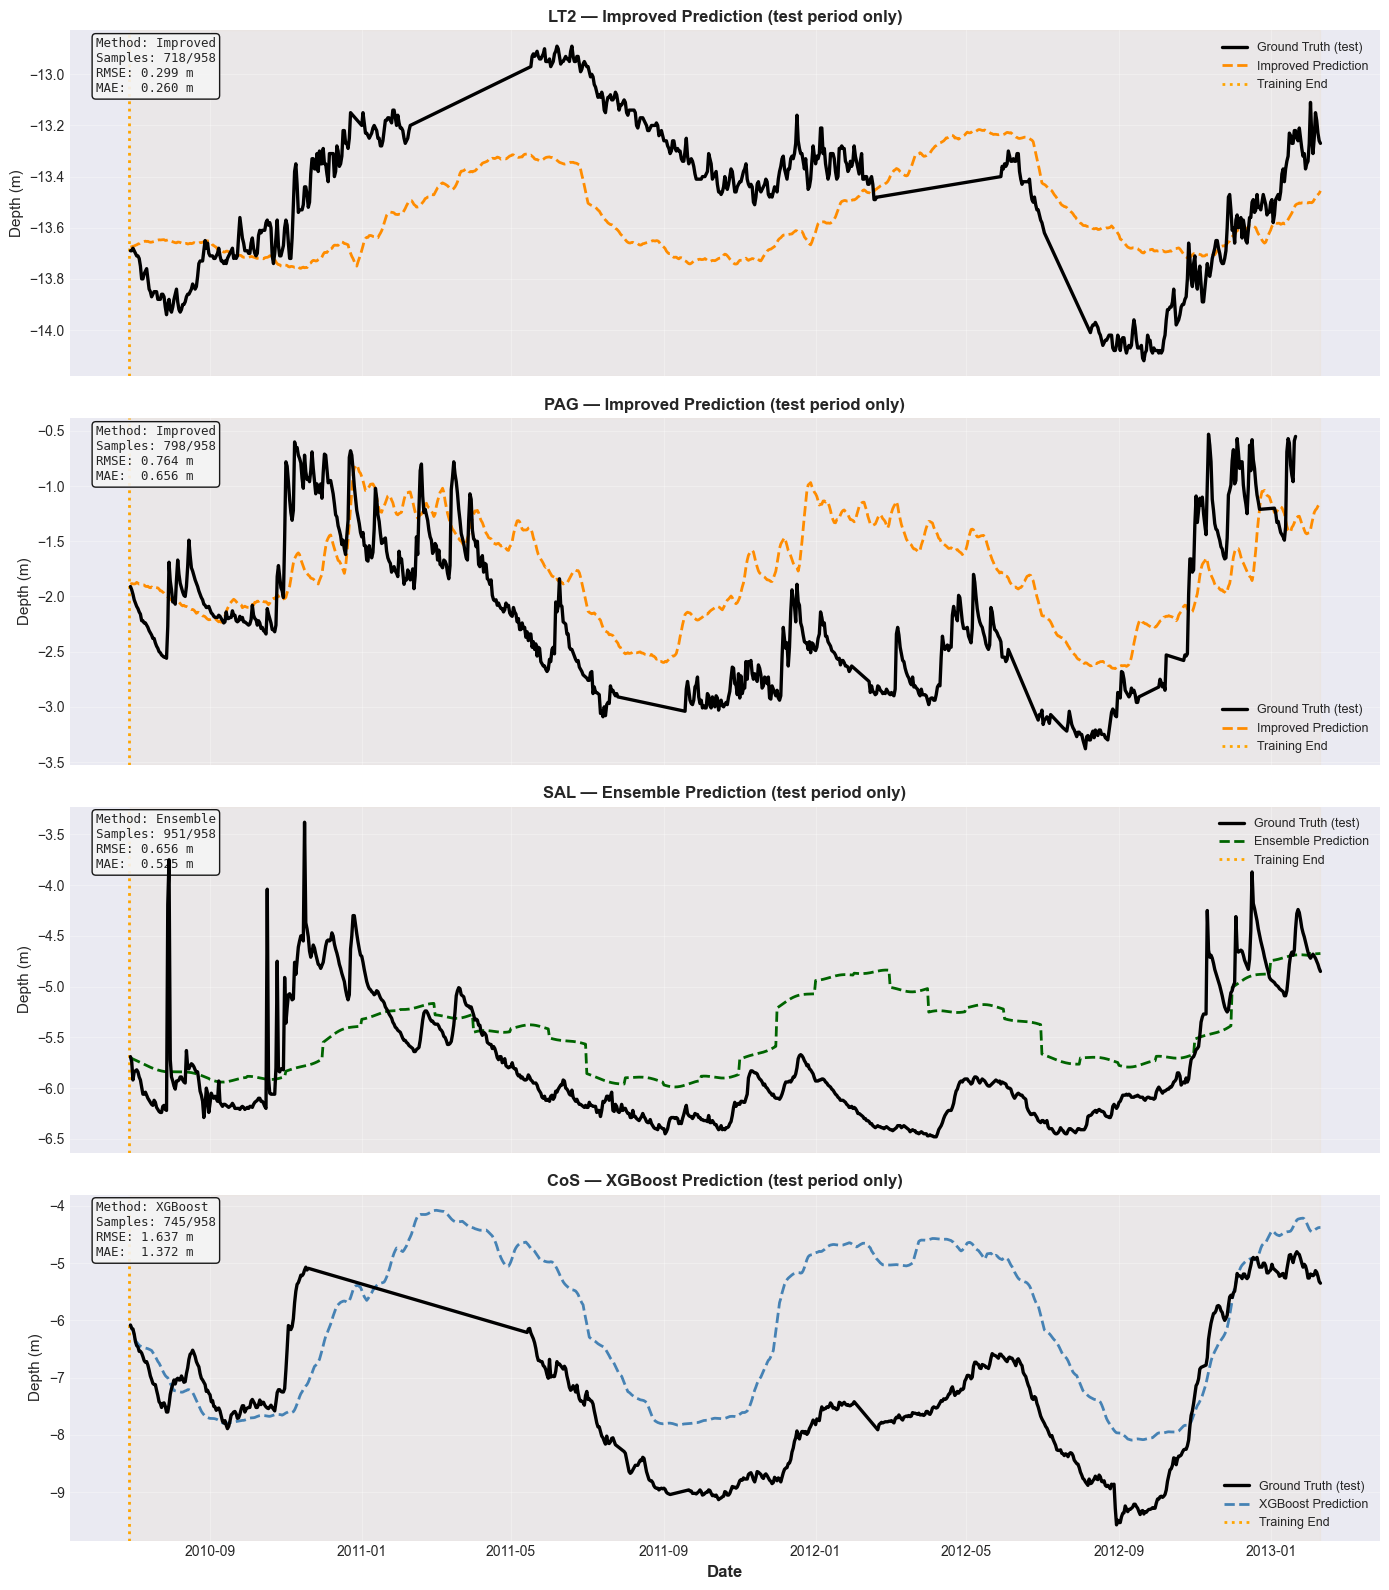


PER-TARGET METRICS (selected methods)
Target   Method     RMSE      MAE   N
   LT2 Improved 0.299349 0.260169 718
   PAG Improved 0.764141 0.656432 798
   SAL Ensemble 0.656211 0.525180 951
   CoS  XGBoost 1.636651 1.372115 745

AVERAGE (across evaluated targets)
Average RMSE: 0.8391 m
Average MAE : 0.7035 m

Saved plot to: outputs/selected_methods_testset_vs_gt.png


In [23]:
print("="*80)
print("SELECTED METHODS: PLOT + METRICS (TEST PERIOD ONLY)")
print("="*80)

# Ensure ground-truth full dataset is loaded
if 'df_full' not in globals():
    df_full = pd.read_csv("Aquifer_Auser.csv")
    df_full["Date"] = pd.to_datetime(df_full["Date"], dayfirst=True)
    df_full = df_full.sort_values("Date").set_index("Date")

# prediction dates (index for the test period)
pred_dates = pd.to_datetime(predictions_df["Date"])

# Prepare mapping (uses available prediction dictionaries)
mapping = {
    "Depth_to_Groundwater_LT2": ("Improved", "improved_predictions"),
    "Depth_to_Groundwater_PAG": ("Improved", "improved_predictions"),
    "Depth_to_Groundwater_SAL": ("Ensemble", "ensemble_predictions"),
    "Depth_to_Groundwater_CoS": ("XGBoost", "xgb_corrected_predictions")  # prefer corrected
}

# Fallback for CoS if corrected isn't present
if "xgb_corrected_predictions" not in globals() and "xgb_predictions" in globals():
    mapping["Depth_to_Groundwater_CoS"] = ("XGBoost", "xgb_predictions")

# Validate keys exist in the environment and in mapping
available_preds = {}
for col, (label, dict_name) in mapping.items():
    if dict_name in globals():
        preds_dict = globals()[dict_name]
        if col in preds_dict:
            available_preds[col] = (label, np.array(preds_dict[col]))
        else:
            raise KeyError(f"Predictions dictionary '{dict_name}' does not contain column '{col}'")
    else:
        raise KeyError(f"Predictions dictionary named '{dict_name}' not found in the environment")

# Colors for plotting by method
method_colors = {"Improved": "darkorange", "Ensemble": "darkgreen", "XGBoost": "steelblue"}

# Create figure (only test-period plots)
n = len(available_preds)
fig, axes = plt.subplots(n, 1, figsize=(14, 4 * n), sharex=True)
if n == 1:
    axes = [axes]

results = []

for ax, (col) in zip(axes, available_preds.keys()):
    label, preds = available_preds[col]
    short_name = col.replace("Depth_to_Groundwater_", "")
    
    # Build DataFrame aligned to pred_dates
    pred_index = pd.to_datetime(pred_dates)
    pred_series = pd.Series(preds, index=pred_index)
    eval_df = pd.DataFrame({"Prediction": pred_series})
    
    # Ground truth aligned on the same index (will contain NaNs where GT missing)
    eval_df["GroundTruth"] = df_full[col].reindex(pred_index).values
    
    # Plot only the test period series (predictions) and ground truth where available
    # Plot ground truth where it exists (thick black)
    gt_df = eval_df.dropna(subset=["GroundTruth"])
    if not gt_df.empty:
        ax.plot(gt_df.index, gt_df["GroundTruth"], color="black", linewidth=2.4, label="Ground Truth (test)", zorder=4)
    
    # Plot prediction curve (entire prediction period)
    ax.plot(eval_df.index, eval_df["Prediction"], color=method_colors.get(label, "tab:purple"),
            linestyle="--", linewidth=2.0, label=f"{label} Prediction", zorder=3)
    
    # Visual markers: training cutoff and prediction shading
    ax.axvline(LAST_KNOWN_DATE, color="orange", linestyle=":", linewidth=2, label="Training End")
    ax.axvspan(PREDICTION_START, PREDICTION_END, color="orange", alpha=0.04, zorder=0)
    
    # Compute metrics on overlapping dates only
    eval_valid = eval_df.dropna(subset=["GroundTruth", "Prediction"])
    n_valid = len(eval_valid)
    n_total = len(eval_df)
    
    if n_valid > 0:
        y_true = eval_valid["GroundTruth"].values
        y_pred = eval_valid["Prediction"].values
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
    else:
        rmse = np.nan
        mae = np.nan
    
    results.append({"Target": short_name, "Method": label, "RMSE": rmse, "MAE": mae, "N": n_valid})
    
    # Add metrics text box
    metrics_text = (f"Method: {label}\n"
                    f"Samples: {n_valid}/{n_total}\n"
                    f"RMSE: {np.nan if np.isnan(rmse) else f'{rmse:.3f}'} m\n"
                    f"MAE:  {np.nan if np.isnan(mae) else f'{mae:.3f}'} m")
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="whitesmoke", alpha=0.9), fontsize=9, family="monospace")
    
    ax.set_ylabel("Depth (m)", fontsize=11)
    ax.set_title(f"{short_name} — {label} Prediction (test period only)", fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)
    ax.legend(loc="best", fontsize=9)

axes[-1].set_xlabel("Date", fontsize=12, fontweight="bold")
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, "selected_methods_testset_vs_gt.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

# Print metrics table and overall averages (only across targets with numeric metrics)
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("PER-TARGET METRICS (selected methods)")
print("="*80)
print(results_df.to_string(index=False))

# Average across targets (ignore NaNs)
valid_results = results_df.dropna(subset=["RMSE", "MAE"])
if not valid_results.empty:
    avg_rmse = valid_results["RMSE"].mean()
    avg_mae = valid_results["MAE"].mean()
    print("\n" + "="*80)
    print("AVERAGE (across evaluated targets)")
    print("="*80)
    print(f"Average RMSE: {avg_rmse:.4f} m")
    print(f"Average MAE : {avg_mae:.4f} m")
else:
    print("\nNo valid evaluation samples found for selected targets.")

print("\nSaved plot to:", plot_path)
print("="*80)


# Final Conclusions

This notebook investigated multiple modeling strategies to forecast groundwater depth for four aquifers over a long-horizon test period (June 2010 – February 2013), under challenging constraints such as missing data, uneven record lengths, and the absence of future exogenous variables.

Rather than relying on a single global model, a **target-specific approach** was adopted after systematic experimentation and evaluation.

### Summary of Final Model Choices

- **LT2 & PAG:** Improved STL-based model  
  These targets benefit most from a physically informed approach that explicitly models seasonality, trend damping, and mean reversion. The improved model produces smooth, continuous forecasts while remaining conservative in long-term extrapolation.

- **SAL:** Original ensemble model  
  For SAL, the ensemble strikes the best balance between seasonal structure and trend stability, outperforming individual methods in both RMSE and MAE.

- **CoS:** XGBoost (bias-corrected)  
  CoS exhibits stronger nonlinearity and variability. A machine-learning approach with cyclical features captures these patterns more effectively when corrected for level continuity at the training–test boundary.

### Quantitative Performance (Test Period Only)

Across the four targets, the selected models achieve:

- **Average RMSE:** **0.84 m**  
- **Average MAE:** **0.70 m**

Performance varies by target, reflecting differences in data availability and hydrogeological behavior. Importantly, all final predictions respect physical constraints and maintain continuity at the transition from training to forecasting.

### Key Takeaways

- **Seasonality is the dominant signal** in groundwater depth forecasting for this dataset and must be modeled explicitly.
- **Long-term trend extrapolation must be handled conservatively**; damped trends and mean reversion improve stability.
- **Model diversity is essential**: no single approach performs best across all aquifers.
- **Post-processing steps such as bias correction** are critical for ensuring continuity and physical realism in machine-learning forecasts.

Overall, the final results demonstrate that combining domain-aware statistical methods with carefully constrained machine-learning models yields reliable and interpretable long-horizon groundwater predictions under limited data conditions.
